In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'normalized','im':'t1','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1','fe':['k5_b25','k7_b25','k9_b25','k11_b25','k13_b25','k15_b25','k17_b25','k19_b25','k21_b25']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'diffusion_fa',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'reinclude'     : ['t1t2'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [2048,1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_2048_1024_512_256_128_0001_MSE_7_0_0_0_0_1_t1t2_normalized_e_n_e_0_1_e_1_0_diffusion_fa_data_norm_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_t1t2_1_42_n_normalized_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(792888, 828)
(792888, 1)
validation
(101248, 828)
(101248, 1)
test
(100432, 828)
(100432, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 2048)              1697792   


 dense_1 (Dense)             (None, 1024)              2098176   


 dense_2 (Dense)             (None, 512)               524800    


 dense_3 (Dense)             (None, 256)               131328    


 dense_4 (Dense)             (None, 128)               32896     


 dense_5 (Dense)             (None, 1)                 129       


Total params: 4485121 (17.11 MB)


Trainable params: 4485121 (17.11 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000


 1/80 [..............................] - ETA: 2:48 - loss: 0.1873 - STD: 4.7752e-05 - MAE: 0.4221

 3/80 [>.............................] - ETA: 3s - loss: 0.0779 - STD: 7.6704e-05 - MAE: 0.2251  

 5/80 [>.............................] - ETA: 3s - loss: 0.0532 - STD: 5.2619e-05 - MAE: 0.1727

 7/80 [=>............................] - ETA: 3s - loss: 0.0449 - STD: 3.8659e-05 - MAE: 0.1590

 8/80 [==>...........................] - ETA: 3s - loss: 0.0427 - STD: 3.4027e-05 - MAE: 0.1559

 9/80 [==>...........................] - ETA: 3s - loss: 0.0410 - STD: 3.0365e-05 - MAE: 0.1538

10/80 [==>...........................] - ETA: 3s - loss: 0.0397 - STD: 2.7405e-05 - MAE: 0.1522

11/80 [===>..........................] - ETA: 3s - loss: 0.0387 - STD: 2.4978e-05 - MAE: 0.1509

12/80 [===>..........................] - ETA: 3s - loss: 0.0377 - STD: 2.2961e-05 - MAE: 0.1497

13/80 [===>..........................] - ETA: 3s - loss: 0.0369 - STD: 2.1265e-05 - MAE: 0.1485

14/80 [====>.........................] - ETA: 3s - loss: 0.0361 - STD: 1.9820e-05 - MAE: 0.1471

15/80 [====>.........................] - ETA: 3s - loss: 0.0353 - STD: 1.8572e-05 - MAE: 0.1456

16/80 [=====>........................] - ETA: 3s - loss: 0.0345 - STD: 1.7483e-05 - MAE: 0.1439

17/80 [=====>........................] - ETA: 3s - loss: 0.0337 - STD: 1.6523e-05 - MAE: 0.1420

18/80 [=====>........................] - ETA: 3s - loss: 0.0328 - STD: 1.5670e-05 - MAE: 0.1398

19/80 [======>.......................] - ETA: 3s - loss: 0.0320 - STD: 1.4905e-05 - MAE: 0.1375

20/80 [======>.......................] - ETA: 3s - loss: 0.0311 - STD: 1.4216e-05 - MAE: 0.1350

21/80 [======>.......................] - ETA: 3s - loss: 0.0302 - STD: 1.3593e-05 - MAE: 0.1325

22/80 [=======>......................] - ETA: 3s - loss: 0.0294 - STD: 1.3028e-05 - MAE: 0.1299

23/80 [=======>......................] - ETA: 2s - loss: 0.0285 - STD: 1.2514e-05 - MAE: 0.1275

24/80 [========>.....................] - ETA: 2s - loss: 0.0277 - STD: 1.2043e-05 - MAE: 0.1253

25/80 [========>.....................] - ETA: 2s - loss: 0.0270 - STD: 1.1609e-05 - MAE: 0.1233

26/80 [========>.....................] - ETA: 2s - loss: 0.0263 - STD: 1.1205e-05 - MAE: 0.1217

27/80 [=========>....................] - ETA: 2s - loss: 0.0257 - STD: 1.0829e-05 - MAE: 0.1204

28/80 [=========>....................] - ETA: 2s - loss: 0.0252 - STD: 1.0476e-05 - MAE: 0.1193

29/80 [=========>....................] - ETA: 2s - loss: 0.0247 - STD: 1.0143e-05 - MAE: 0.1184

30/80 [==========>...................] - ETA: 2s - loss: 0.0243 - STD: 9.8289e-06 - MAE: 0.1176

31/80 [==========>...................] - ETA: 2s - loss: 0.0239 - STD: 9.5305e-06 - MAE: 0.1168

32/80 [===========>..................] - ETA: 2s - loss: 0.0235 - STD: 9.2469e-06 - MAE: 0.1159

33/80 [===========>..................] - ETA: 2s - loss: 0.0231 - STD: 8.9773e-06 - MAE: 0.1150

34/80 [===========>..................] - ETA: 2s - loss: 0.0227 - STD: 8.7213e-06 - MAE: 0.1140

35/80 [============>.................] - ETA: 2s - loss: 0.0224 - STD: 8.4784e-06 - MAE: 0.1130

36/80 [============>.................] - ETA: 2s - loss: 0.0220 - STD: 8.2485e-06 - MAE: 0.1120

37/80 [============>.................] - ETA: 2s - loss: 0.0217 - STD: 8.0308e-06 - MAE: 0.1110

38/80 [=============>................] - ETA: 2s - loss: 0.0213 - STD: 7.8247e-06 - MAE: 0.1100

39/80 [=============>................] - ETA: 2s - loss: 0.0210 - STD: 7.6293e-06 - MAE: 0.1091

40/80 [==============>...............] - ETA: 2s - loss: 0.0207 - STD: 7.4438e-06 - MAE: 0.1082

41/80 [==============>...............] - ETA: 2s - loss: 0.0205 - STD: 7.2674e-06 - MAE: 0.1073

42/80 [==============>...............] - ETA: 2s - loss: 0.0202 - STD: 7.0994e-06 - MAE: 0.1066

43/80 [===============>..............] - ETA: 1s - loss: 0.0200 - STD: 6.9393e-06 - MAE: 0.1058

44/80 [===============>..............] - ETA: 1s - loss: 0.0197 - STD: 6.7865e-06 - MAE: 0.1051

45/80 [===============>..............] - ETA: 1s - loss: 0.0195 - STD: 6.6404e-06 - MAE: 0.1044

46/80 [================>.............] - ETA: 1s - loss: 0.0193 - STD: 6.5006e-06 - MAE: 0.1037

47/80 [================>.............] - ETA: 1s - loss: 0.0191 - STD: 6.3668e-06 - MAE: 0.1031

48/80 [=================>............] - ETA: 1s - loss: 0.0189 - STD: 6.2385e-06 - MAE: 0.1025

49/80 [=================>............] - ETA: 1s - loss: 0.0187 - STD: 6.1154e-06 - MAE: 0.1019

50/80 [=================>............] - ETA: 1s - loss: 0.0185 - STD: 5.9973e-06 - MAE: 0.1013

51/80 [==================>...........] - ETA: 1s - loss: 0.0183 - STD: 5.8838e-06 - MAE: 0.1008

52/80 [==================>...........] - ETA: 1s - loss: 0.0182 - STD: 5.7747e-06 - MAE: 0.1004

53/80 [==================>...........] - ETA: 1s - loss: 0.0180 - STD: 5.6696e-06 - MAE: 0.0999

54/80 [===================>..........] - ETA: 1s - loss: 0.0178 - STD: 5.5685e-06 - MAE: 0.0995

55/80 [===================>..........] - ETA: 1s - loss: 0.0177 - STD: 5.4711e-06 - MAE: 0.0991

56/80 [====================>.........] - ETA: 1s - loss: 0.0175 - STD: 5.3772e-06 - MAE: 0.0987

57/80 [====================>.........] - ETA: 1s - loss: 0.0174 - STD: 5.2866e-06 - MAE: 0.0983

58/80 [====================>.........] - ETA: 1s - loss: 0.0172 - STD: 5.1993e-06 - MAE: 0.0980

59/80 [=====================>........] - ETA: 1s - loss: 0.0171 - STD: 5.1150e-06 - MAE: 0.0977

60/80 [=====================>........] - ETA: 1s - loss: 0.0170 - STD: 5.0336e-06 - MAE: 0.0973

61/80 [=====================>........] - ETA: 1s - loss: 0.0168 - STD: 4.9549e-06 - MAE: 0.0970

62/80 [======================>.......] - ETA: 0s - loss: 0.0167 - STD: 4.8790e-06 - MAE: 0.0966

63/80 [======================>.......] - ETA: 0s - loss: 0.0166 - STD: 4.8055e-06 - MAE: 0.0963

64/80 [=======================>......] - ETA: 0s - loss: 0.0165 - STD: 4.7343e-06 - MAE: 0.0960

65/80 [=======================>......] - ETA: 0s - loss: 0.0164 - STD: 4.6653e-06 - MAE: 0.0956

66/80 [=======================>......] - ETA: 0s - loss: 0.0163 - STD: 4.5986e-06 - MAE: 0.0953

67/80 [========================>.....] - ETA: 0s - loss: 0.0162 - STD: 4.5339e-06 - MAE: 0.0950

68/80 [========================>.....] - ETA: 0s - loss: 0.0161 - STD: 4.4711e-06 - MAE: 0.0947

69/80 [========================>.....] - ETA: 0s - loss: 0.0160 - STD: 4.4103e-06 - MAE: 0.0944

70/80 [=========================>....] - ETA: 0s - loss: 0.0159 - STD: 4.3512e-06 - MAE: 0.0941

71/80 [=========================>....] - ETA: 0s - loss: 0.0158 - STD: 4.2940e-06 - MAE: 0.0939

72/80 [==========================>...] - ETA: 0s - loss: 0.0157 - STD: 4.2383e-06 - MAE: 0.0936

73/80 [==========================>...] - ETA: 0s - loss: 0.0156 - STD: 4.1843e-06 - MAE: 0.0933

74/80 [==========================>...] - ETA: 0s - loss: 0.0155 - STD: 4.1318e-06 - MAE: 0.0931

75/80 [===========================>..] - ETA: 0s - loss: 0.0154 - STD: 4.0808e-06 - MAE: 0.0929

76/80 [===========================>..] - ETA: 0s - loss: 0.0153 - STD: 4.0311e-06 - MAE: 0.0926

77/80 [===========================>..] - ETA: 0s - loss: 0.0153 - STD: 3.9828e-06 - MAE: 0.0924

79/80 [============================>.] - ETA: 0s - loss: 0.0152 - STD: 3.8901e-06 - MAE: 0.0920

80/80 [==============================] - 8s 75ms/step - loss: 0.0151 - STD: 3.8457e-06 - MAE: 0.0918 - val_loss: 0.0086 - val_STD: 2.4253e-07 - val_MAE: 0.0719


Epoch 2/10000


 1/80 [..............................] - ETA: 9s - loss: 0.0093 - STD: 3.3900e-07 - MAE: 0.0762

 3/80 [>.............................] - ETA: 2s - loss: 0.0093 - STD: 3.4490e-07 - MAE: 0.0759

 4/80 [>.............................] - ETA: 3s - loss: 0.0094 - STD: 3.4709e-07 - MAE: 0.0762

 5/80 [>.............................] - ETA: 3s - loss: 0.0094 - STD: 3.4903e-07 - MAE: 0.0762

 6/80 [=>............................] - ETA: 3s - loss: 0.0093 - STD: 3.5104e-07 - MAE: 0.0762

 7/80 [=>............................] - ETA: 3s - loss: 0.0093 - STD: 3.5404e-07 - MAE: 0.0762

 8/80 [==>...........................] - ETA: 3s - loss: 0.0094 - STD: 3.5716e-07 - MAE: 0.0762

 9/80 [==>...........................] - ETA: 3s - loss: 0.0093 - STD: 3.5999e-07 - MAE: 0.0761

10/80 [==>...........................] - ETA: 3s - loss: 0.0094 - STD: 3.6310e-07 - MAE: 0.0761

11/80 [===>..........................] - ETA: 3s - loss: 0.0094 - STD: 3.6596e-07 - MAE: 0.0761

12/80 [===>..........................] - ETA: 3s - loss: 0.0093 - STD: 3.6906e-07 - MAE: 0.0759

13/80 [===>..........................] - ETA: 3s - loss: 0.0093 - STD: 3.7203e-07 - MAE: 0.0759

14/80 [====>.........................] - ETA: 3s - loss: 0.0093 - STD: 3.7502e-07 - MAE: 0.0759

15/80 [====>.........................] - ETA: 3s - loss: 0.0093 - STD: 3.7789e-07 - MAE: 0.0758

16/80 [=====>........................] - ETA: 3s - loss: 0.0093 - STD: 3.8102e-07 - MAE: 0.0758

17/80 [=====>........................] - ETA: 3s - loss: 0.0093 - STD: 3.8395e-07 - MAE: 0.0758

18/80 [=====>........................] - ETA: 3s - loss: 0.0093 - STD: 3.8707e-07 - MAE: 0.0757

19/80 [======>.......................] - ETA: 3s - loss: 0.0093 - STD: 3.9037e-07 - MAE: 0.0756

20/80 [======>.......................] - ETA: 3s - loss: 0.0093 - STD: 3.9382e-07 - MAE: 0.0756

21/80 [======>.......................] - ETA: 3s - loss: 0.0093 - STD: 3.9698e-07 - MAE: 0.0756

22/80 [=======>......................] - ETA: 3s - loss: 0.0093 - STD: 4.0032e-07 - MAE: 0.0756

23/80 [=======>......................] - ETA: 3s - loss: 0.0093 - STD: 4.0346e-07 - MAE: 0.0756

24/80 [========>.....................] - ETA: 2s - loss: 0.0092 - STD: 4.0696e-07 - MAE: 0.0755

25/80 [========>.....................] - ETA: 2s - loss: 0.0092 - STD: 4.1039e-07 - MAE: 0.0755

26/80 [========>.....................] - ETA: 2s - loss: 0.0092 - STD: 4.1378e-07 - MAE: 0.0755

27/80 [=========>....................] - ETA: 2s - loss: 0.0093 - STD: 4.1707e-07 - MAE: 0.0755

28/80 [=========>....................] - ETA: 2s - loss: 0.0092 - STD: 4.2064e-07 - MAE: 0.0755

29/80 [=========>....................] - ETA: 2s - loss: 0.0092 - STD: 4.2386e-07 - MAE: 0.0755

30/80 [==========>...................] - ETA: 2s - loss: 0.0092 - STD: 4.2716e-07 - MAE: 0.0754

31/80 [==========>...................] - ETA: 2s - loss: 0.0092 - STD: 4.3077e-07 - MAE: 0.0754

32/80 [===========>..................] - ETA: 2s - loss: 0.0092 - STD: 4.3405e-07 - MAE: 0.0754

33/80 [===========>..................] - ETA: 2s - loss: 0.0092 - STD: 4.3755e-07 - MAE: 0.0755

34/80 [===========>..................] - ETA: 2s - loss: 0.0092 - STD: 4.4112e-07 - MAE: 0.0755

35/80 [============>.................] - ETA: 2s - loss: 0.0092 - STD: 4.4473e-07 - MAE: 0.0755

36/80 [============>.................] - ETA: 2s - loss: 0.0092 - STD: 4.4831e-07 - MAE: 0.0754

37/80 [============>.................] - ETA: 2s - loss: 0.0092 - STD: 4.5194e-07 - MAE: 0.0754

38/80 [=============>................] - ETA: 2s - loss: 0.0092 - STD: 4.5535e-07 - MAE: 0.0754

39/80 [=============>................] - ETA: 2s - loss: 0.0092 - STD: 4.5894e-07 - MAE: 0.0754

40/80 [==============>...............] - ETA: 2s - loss: 0.0092 - STD: 4.6241e-07 - MAE: 0.0754

41/80 [==============>...............] - ETA: 2s - loss: 0.0092 - STD: 4.6591e-07 - MAE: 0.0754

42/80 [==============>...............] - ETA: 2s - loss: 0.0092 - STD: 4.6960e-07 - MAE: 0.0754

43/80 [===============>..............] - ETA: 1s - loss: 0.0092 - STD: 4.7329e-07 - MAE: 0.0754

44/80 [===============>..............] - ETA: 1s - loss: 0.0092 - STD: 4.7699e-07 - MAE: 0.0754

45/80 [===============>..............] - ETA: 1s - loss: 0.0092 - STD: 4.8071e-07 - MAE: 0.0754

46/80 [================>.............] - ETA: 1s - loss: 0.0092 - STD: 4.8443e-07 - MAE: 0.0754

47/80 [================>.............] - ETA: 1s - loss: 0.0092 - STD: 4.8807e-07 - MAE: 0.0754

48/80 [=================>............] - ETA: 1s - loss: 0.0092 - STD: 4.9200e-07 - MAE: 0.0754

49/80 [=================>............] - ETA: 1s - loss: 0.0092 - STD: 4.9586e-07 - MAE: 0.0754

50/80 [=================>............] - ETA: 1s - loss: 0.0092 - STD: 4.9959e-07 - MAE: 0.0754

51/80 [==================>...........] - ETA: 1s - loss: 0.0092 - STD: 5.0343e-07 - MAE: 0.0754

52/80 [==================>...........] - ETA: 1s - loss: 0.0092 - STD: 5.0729e-07 - MAE: 0.0754

53/80 [==================>...........] - ETA: 1s - loss: 0.0092 - STD: 5.1111e-07 - MAE: 0.0754

54/80 [===================>..........] - ETA: 1s - loss: 0.0092 - STD: 5.1501e-07 - MAE: 0.0754

55/80 [===================>..........] - ETA: 1s - loss: 0.0092 - STD: 5.1895e-07 - MAE: 0.0754

56/80 [====================>.........] - ETA: 1s - loss: 0.0092 - STD: 5.2275e-07 - MAE: 0.0753

57/80 [====================>.........] - ETA: 1s - loss: 0.0092 - STD: 5.2659e-07 - MAE: 0.0753

58/80 [====================>.........] - ETA: 1s - loss: 0.0092 - STD: 5.3066e-07 - MAE: 0.0753

59/80 [=====================>........] - ETA: 1s - loss: 0.0092 - STD: 5.3473e-07 - MAE: 0.0753

60/80 [=====================>........] - ETA: 1s - loss: 0.0092 - STD: 5.3863e-07 - MAE: 0.0754

61/80 [=====================>........] - ETA: 1s - loss: 0.0092 - STD: 5.4254e-07 - MAE: 0.0754

62/80 [======================>.......] - ETA: 0s - loss: 0.0092 - STD: 5.4671e-07 - MAE: 0.0754

63/80 [======================>.......] - ETA: 0s - loss: 0.0092 - STD: 5.5091e-07 - MAE: 0.0754

64/80 [=======================>......] - ETA: 0s - loss: 0.0092 - STD: 5.5498e-07 - MAE: 0.0754

65/80 [=======================>......] - ETA: 0s - loss: 0.0092 - STD: 5.5929e-07 - MAE: 0.0754

66/80 [=======================>......] - ETA: 0s - loss: 0.0092 - STD: 5.6366e-07 - MAE: 0.0754

67/80 [========================>.....] - ETA: 0s - loss: 0.0092 - STD: 5.6801e-07 - MAE: 0.0754

68/80 [========================>.....] - ETA: 0s - loss: 0.0092 - STD: 5.7224e-07 - MAE: 0.0754

69/80 [========================>.....] - ETA: 0s - loss: 0.0092 - STD: 5.7648e-07 - MAE: 0.0754

70/80 [=========================>....] - ETA: 0s - loss: 0.0092 - STD: 5.8086e-07 - MAE: 0.0754

71/80 [=========================>....] - ETA: 0s - loss: 0.0092 - STD: 5.8525e-07 - MAE: 0.0754

72/80 [==========================>...] - ETA: 0s - loss: 0.0092 - STD: 5.8941e-07 - MAE: 0.0754

73/80 [==========================>...] - ETA: 0s - loss: 0.0092 - STD: 5.9368e-07 - MAE: 0.0754

74/80 [==========================>...] - ETA: 0s - loss: 0.0092 - STD: 5.9806e-07 - MAE: 0.0754

75/80 [===========================>..] - ETA: 0s - loss: 0.0092 - STD: 6.0246e-07 - MAE: 0.0754

76/80 [===========================>..] - ETA: 0s - loss: 0.0092 - STD: 6.0694e-07 - MAE: 0.0754

77/80 [===========================>..] - ETA: 0s - loss: 0.0092 - STD: 6.1146e-07 - MAE: 0.0754

78/80 [============================>.] - ETA: 0s - loss: 0.0092 - STD: 6.1606e-07 - MAE: 0.0754

79/80 [============================>.] - ETA: 0s - loss: 0.0092 - STD: 6.2069e-07 - MAE: 0.0754

80/80 [==============================] - ETA: 0s - loss: 0.0092 - STD: 6.2526e-07 - MAE: 0.0754

80/80 [==============================] - 5s 58ms/step - loss: 0.0092 - STD: 6.2526e-07 - MAE: 0.0754 - val_loss: 0.0086 - val_STD: 6.8473e-07 - val_MAE: 0.0716


Epoch 3/10000


 1/80 [..............................] - ETA: 8s - loss: 0.0091 - STD: 1.0049e-06 - MAE: 0.0754

 2/80 [..............................] - ETA: 4s - loss: 0.0092 - STD: 1.0007e-06 - MAE: 0.0753

 3/80 [>.............................] - ETA: 4s - loss: 0.0092 - STD: 1.0072e-06 - MAE: 0.0753

 4/80 [>.............................] - ETA: 4s - loss: 0.0092 - STD: 1.0132e-06 - MAE: 0.0754

 5/80 [>.............................] - ETA: 4s - loss: 0.0092 - STD: 1.0214e-06 - MAE: 0.0756

 6/80 [=>............................] - ETA: 4s - loss: 0.0092 - STD: 1.0258e-06 - MAE: 0.0755

 7/80 [=>............................] - ETA: 4s - loss: 0.0092 - STD: 1.0319e-06 - MAE: 0.0755

 8/80 [==>...........................] - ETA: 3s - loss: 0.0092 - STD: 1.0382e-06 - MAE: 0.0755

 9/80 [==>...........................] - ETA: 3s - loss: 0.0092 - STD: 1.0443e-06 - MAE: 0.0754

10/80 [==>...........................] - ETA: 3s - loss: 0.0092 - STD: 1.0501e-06 - MAE: 0.0754

11/80 [===>..........................] - ETA: 3s - loss: 0.0092 - STD: 1.0552e-06 - MAE: 0.0754

12/80 [===>..........................] - ETA: 3s - loss: 0.0092 - STD: 1.0609e-06 - MAE: 0.0754

13/80 [===>..........................] - ETA: 3s - loss: 0.0092 - STD: 1.0669e-06 - MAE: 0.0753

14/80 [====>.........................] - ETA: 3s - loss: 0.0092 - STD: 1.0732e-06 - MAE: 0.0754

15/80 [====>.........................] - ETA: 3s - loss: 0.0092 - STD: 1.0792e-06 - MAE: 0.0754

16/80 [=====>........................] - ETA: 3s - loss: 0.0092 - STD: 1.0847e-06 - MAE: 0.0755

17/80 [=====>........................] - ETA: 3s - loss: 0.0092 - STD: 1.0909e-06 - MAE: 0.0755

18/80 [=====>........................] - ETA: 3s - loss: 0.0092 - STD: 1.0976e-06 - MAE: 0.0755

19/80 [======>.......................] - ETA: 3s - loss: 0.0092 - STD: 1.1039e-06 - MAE: 0.0755

20/80 [======>.......................] - ETA: 3s - loss: 0.0092 - STD: 1.1102e-06 - MAE: 0.0755

21/80 [======>.......................] - ETA: 3s - loss: 0.0092 - STD: 1.1163e-06 - MAE: 0.0755

22/80 [=======>......................] - ETA: 3s - loss: 0.0092 - STD: 1.1225e-06 - MAE: 0.0755

23/80 [=======>......................] - ETA: 3s - loss: 0.0092 - STD: 1.1288e-06 - MAE: 0.0755

24/80 [========>.....................] - ETA: 3s - loss: 0.0092 - STD: 1.1356e-06 - MAE: 0.0756

25/80 [========>.....................] - ETA: 2s - loss: 0.0092 - STD: 1.1416e-06 - MAE: 0.0755

26/80 [========>.....................] - ETA: 2s - loss: 0.0092 - STD: 1.1476e-06 - MAE: 0.0755

27/80 [=========>....................] - ETA: 2s - loss: 0.0092 - STD: 1.1537e-06 - MAE: 0.0755

28/80 [=========>....................] - ETA: 2s - loss: 0.0092 - STD: 1.1601e-06 - MAE: 0.0754

29/80 [=========>....................] - ETA: 2s - loss: 0.0092 - STD: 1.1661e-06 - MAE: 0.0754

30/80 [==========>...................] - ETA: 2s - loss: 0.0092 - STD: 1.1726e-06 - MAE: 0.0755

31/80 [==========>...................] - ETA: 2s - loss: 0.0092 - STD: 1.1792e-06 - MAE: 0.0754

32/80 [===========>..................] - ETA: 2s - loss: 0.0092 - STD: 1.1862e-06 - MAE: 0.0754

33/80 [===========>..................] - ETA: 2s - loss: 0.0092 - STD: 1.1928e-06 - MAE: 0.0754

34/80 [===========>..................] - ETA: 2s - loss: 0.0092 - STD: 1.1996e-06 - MAE: 0.0754

35/80 [============>.................] - ETA: 2s - loss: 0.0092 - STD: 1.2070e-06 - MAE: 0.0754

36/80 [============>.................] - ETA: 2s - loss: 0.0092 - STD: 1.2144e-06 - MAE: 0.0754

37/80 [============>.................] - ETA: 2s - loss: 0.0092 - STD: 1.2216e-06 - MAE: 0.0754

38/80 [=============>................] - ETA: 2s - loss: 0.0092 - STD: 1.2289e-06 - MAE: 0.0754

39/80 [=============>................] - ETA: 2s - loss: 0.0092 - STD: 1.2360e-06 - MAE: 0.0754

40/80 [==============>...............] - ETA: 2s - loss: 0.0092 - STD: 1.2426e-06 - MAE: 0.0754

41/80 [==============>...............] - ETA: 2s - loss: 0.0092 - STD: 1.2498e-06 - MAE: 0.0754

42/80 [==============>...............] - ETA: 2s - loss: 0.0092 - STD: 1.2570e-06 - MAE: 0.0754

43/80 [===============>..............] - ETA: 2s - loss: 0.0092 - STD: 1.2642e-06 - MAE: 0.0754

44/80 [===============>..............] - ETA: 1s - loss: 0.0092 - STD: 1.2708e-06 - MAE: 0.0754

45/80 [===============>..............] - ETA: 1s - loss: 0.0092 - STD: 1.2778e-06 - MAE: 0.0754

46/80 [================>.............] - ETA: 1s - loss: 0.0092 - STD: 1.2848e-06 - MAE: 0.0753

47/80 [================>.............] - ETA: 1s - loss: 0.0092 - STD: 1.2924e-06 - MAE: 0.0753

48/80 [=================>............] - ETA: 1s - loss: 0.0092 - STD: 1.2996e-06 - MAE: 0.0753

49/80 [=================>............] - ETA: 1s - loss: 0.0092 - STD: 1.3069e-06 - MAE: 0.0753

50/80 [=================>............] - ETA: 1s - loss: 0.0092 - STD: 1.3143e-06 - MAE: 0.0753

51/80 [==================>...........] - ETA: 1s - loss: 0.0092 - STD: 1.3216e-06 - MAE: 0.0753

52/80 [==================>...........] - ETA: 1s - loss: 0.0092 - STD: 1.3289e-06 - MAE: 0.0753

53/80 [==================>...........] - ETA: 1s - loss: 0.0092 - STD: 1.3365e-06 - MAE: 0.0753

54/80 [===================>..........] - ETA: 1s - loss: 0.0092 - STD: 1.3444e-06 - MAE: 0.0753

55/80 [===================>..........] - ETA: 1s - loss: 0.0092 - STD: 1.3525e-06 - MAE: 0.0753

56/80 [====================>.........] - ETA: 1s - loss: 0.0092 - STD: 1.3603e-06 - MAE: 0.0754

57/80 [====================>.........] - ETA: 1s - loss: 0.0092 - STD: 1.3686e-06 - MAE: 0.0754

58/80 [====================>.........] - ETA: 1s - loss: 0.0092 - STD: 1.3764e-06 - MAE: 0.0754

59/80 [=====================>........] - ETA: 1s - loss: 0.0092 - STD: 1.3843e-06 - MAE: 0.0754

60/80 [=====================>........] - ETA: 1s - loss: 0.0092 - STD: 1.3925e-06 - MAE: 0.0754

61/80 [=====================>........] - ETA: 1s - loss: 0.0092 - STD: 1.4006e-06 - MAE: 0.0754

62/80 [======================>.......] - ETA: 0s - loss: 0.0092 - STD: 1.4087e-06 - MAE: 0.0754

63/80 [======================>.......] - ETA: 0s - loss: 0.0092 - STD: 1.4171e-06 - MAE: 0.0754

65/80 [=======================>......] - ETA: 0s - loss: 0.0092 - STD: 1.4339e-06 - MAE: 0.0754

66/80 [=======================>......] - ETA: 0s - loss: 0.0092 - STD: 1.4422e-06 - MAE: 0.0754

67/80 [========================>.....] - ETA: 0s - loss: 0.0092 - STD: 1.4510e-06 - MAE: 0.0754

68/80 [========================>.....] - ETA: 0s - loss: 0.0092 - STD: 1.4598e-06 - MAE: 0.0754

69/80 [========================>.....] - ETA: 0s - loss: 0.0092 - STD: 1.4683e-06 - MAE: 0.0754

70/80 [=========================>....] - ETA: 0s - loss: 0.0092 - STD: 1.4771e-06 - MAE: 0.0754

71/80 [=========================>....] - ETA: 0s - loss: 0.0092 - STD: 1.4860e-06 - MAE: 0.0754

72/80 [==========================>...] - ETA: 0s - loss: 0.0092 - STD: 1.4948e-06 - MAE: 0.0754

73/80 [==========================>...] - ETA: 0s - loss: 0.0092 - STD: 1.5038e-06 - MAE: 0.0754

74/80 [==========================>...] - ETA: 0s - loss: 0.0092 - STD: 1.5128e-06 - MAE: 0.0754

75/80 [===========================>..] - ETA: 0s - loss: 0.0092 - STD: 1.5217e-06 - MAE: 0.0754

76/80 [===========================>..] - ETA: 0s - loss: 0.0092 - STD: 1.5310e-06 - MAE: 0.0754

77/80 [===========================>..] - ETA: 0s - loss: 0.0092 - STD: 1.5400e-06 - MAE: 0.0754

78/80 [============================>.] - ETA: 0s - loss: 0.0092 - STD: 1.5491e-06 - MAE: 0.0754

79/80 [============================>.] - ETA: 0s - loss: 0.0092 - STD: 1.5585e-06 - MAE: 0.0754

80/80 [==============================] - ETA: 0s - loss: 0.0092 - STD: 1.5677e-06 - MAE: 0.0754

80/80 [==============================] - 5s 59ms/step - loss: 0.0092 - STD: 1.5677e-06 - MAE: 0.0754 - val_loss: 0.0086 - val_STD: 1.5861e-06 - val_MAE: 0.0715


Epoch 4/10000


 1/80 [..............................] - ETA: 8s - loss: 0.0093 - STD: 2.3239e-06 - MAE: 0.0756

 2/80 [..............................] - ETA: 4s - loss: 0.0091 - STD: 2.3297e-06 - MAE: 0.0754

 3/80 [>.............................] - ETA: 4s - loss: 0.0091 - STD: 2.3459e-06 - MAE: 0.0753

 4/80 [>.............................] - ETA: 4s - loss: 0.0092 - STD: 2.3738e-06 - MAE: 0.0755

 5/80 [>.............................] - ETA: 4s - loss: 0.0091 - STD: 2.3881e-06 - MAE: 0.0754

 6/80 [=>............................] - ETA: 4s - loss: 0.0092 - STD: 2.3996e-06 - MAE: 0.0755

 7/80 [=>............................] - ETA: 4s - loss: 0.0092 - STD: 2.4064e-06 - MAE: 0.0756

 8/80 [==>...........................] - ETA: 3s - loss: 0.0092 - STD: 2.4207e-06 - MAE: 0.0755

 9/80 [==>...........................] - ETA: 3s - loss: 0.0092 - STD: 2.4333e-06 - MAE: 0.0755

10/80 [==>...........................] - ETA: 3s - loss: 0.0092 - STD: 2.4479e-06 - MAE: 0.0754

11/80 [===>..........................] - ETA: 3s - loss: 0.0092 - STD: 2.4616e-06 - MAE: 0.0755

12/80 [===>..........................] - ETA: 3s - loss: 0.0091 - STD: 2.4756e-06 - MAE: 0.0753

13/80 [===>..........................] - ETA: 3s - loss: 0.0091 - STD: 2.4919e-06 - MAE: 0.0753

14/80 [====>.........................] - ETA: 3s - loss: 0.0091 - STD: 2.5053e-06 - MAE: 0.0753

15/80 [====>.........................] - ETA: 3s - loss: 0.0091 - STD: 2.5180e-06 - MAE: 0.0753

16/80 [=====>........................] - ETA: 3s - loss: 0.0092 - STD: 2.5323e-06 - MAE: 0.0753

17/80 [=====>........................] - ETA: 3s - loss: 0.0092 - STD: 2.5453e-06 - MAE: 0.0753

18/80 [=====>........................] - ETA: 3s - loss: 0.0092 - STD: 2.5604e-06 - MAE: 0.0753

19/80 [======>.......................] - ETA: 3s - loss: 0.0092 - STD: 2.5756e-06 - MAE: 0.0753

20/80 [======>.......................] - ETA: 3s - loss: 0.0092 - STD: 2.5891e-06 - MAE: 0.0753

21/80 [======>.......................] - ETA: 3s - loss: 0.0092 - STD: 2.6028e-06 - MAE: 0.0754

23/80 [=======>......................] - ETA: 3s - loss: 0.0092 - STD: 2.6359e-06 - MAE: 0.0754

24/80 [========>.....................] - ETA: 2s - loss: 0.0092 - STD: 2.6500e-06 - MAE: 0.0753

25/80 [========>.....................] - ETA: 2s - loss: 0.0092 - STD: 2.6646e-06 - MAE: 0.0753

26/80 [========>.....................] - ETA: 2s - loss: 0.0092 - STD: 2.6806e-06 - MAE: 0.0753

27/80 [=========>....................] - ETA: 2s - loss: 0.0092 - STD: 2.6961e-06 - MAE: 0.0752

28/80 [=========>....................] - ETA: 2s - loss: 0.0092 - STD: 2.7124e-06 - MAE: 0.0752

29/80 [=========>....................] - ETA: 2s - loss: 0.0092 - STD: 2.7295e-06 - MAE: 0.0753

30/80 [==========>...................] - ETA: 2s - loss: 0.0092 - STD: 2.7446e-06 - MAE: 0.0752

31/80 [==========>...................] - ETA: 2s - loss: 0.0092 - STD: 2.7608e-06 - MAE: 0.0752

32/80 [===========>..................] - ETA: 2s - loss: 0.0092 - STD: 2.7768e-06 - MAE: 0.0752

33/80 [===========>..................] - ETA: 2s - loss: 0.0092 - STD: 2.7934e-06 - MAE: 0.0753

34/80 [===========>..................] - ETA: 2s - loss: 0.0092 - STD: 2.8089e-06 - MAE: 0.0753

35/80 [============>.................] - ETA: 2s - loss: 0.0092 - STD: 2.8269e-06 - MAE: 0.0753

36/80 [============>.................] - ETA: 2s - loss: 0.0092 - STD: 2.8440e-06 - MAE: 0.0753

37/80 [============>.................] - ETA: 2s - loss: 0.0092 - STD: 2.8609e-06 - MAE: 0.0753

38/80 [=============>................] - ETA: 2s - loss: 0.0092 - STD: 2.8779e-06 - MAE: 0.0753

39/80 [=============>................] - ETA: 2s - loss: 0.0092 - STD: 2.8953e-06 - MAE: 0.0753

40/80 [==============>...............] - ETA: 2s - loss: 0.0092 - STD: 2.9136e-06 - MAE: 0.0753

41/80 [==============>...............] - ETA: 2s - loss: 0.0092 - STD: 2.9320e-06 - MAE: 0.0753

42/80 [==============>...............] - ETA: 2s - loss: 0.0092 - STD: 2.9504e-06 - MAE: 0.0753

43/80 [===============>..............] - ETA: 2s - loss: 0.0092 - STD: 2.9685e-06 - MAE: 0.0753

44/80 [===============>..............] - ETA: 1s - loss: 0.0092 - STD: 2.9863e-06 - MAE: 0.0753

45/80 [===============>..............] - ETA: 1s - loss: 0.0092 - STD: 3.0038e-06 - MAE: 0.0753

46/80 [================>.............] - ETA: 1s - loss: 0.0092 - STD: 3.0219e-06 - MAE: 0.0753

47/80 [================>.............] - ETA: 1s - loss: 0.0092 - STD: 3.0397e-06 - MAE: 0.0753

48/80 [=================>............] - ETA: 1s - loss: 0.0092 - STD: 3.0587e-06 - MAE: 0.0753

49/80 [=================>............] - ETA: 1s - loss: 0.0092 - STD: 3.0778e-06 - MAE: 0.0753

50/80 [=================>............] - ETA: 1s - loss: 0.0092 - STD: 3.0975e-06 - MAE: 0.0753

51/80 [==================>...........] - ETA: 1s - loss: 0.0092 - STD: 3.1167e-06 - MAE: 0.0753

52/80 [==================>...........] - ETA: 1s - loss: 0.0092 - STD: 3.1351e-06 - MAE: 0.0753

53/80 [==================>...........] - ETA: 1s - loss: 0.0092 - STD: 3.1542e-06 - MAE: 0.0753

54/80 [===================>..........] - ETA: 1s - loss: 0.0092 - STD: 3.1742e-06 - MAE: 0.0753

55/80 [===================>..........] - ETA: 1s - loss: 0.0092 - STD: 3.1937e-06 - MAE: 0.0753

56/80 [====================>.........] - ETA: 1s - loss: 0.0092 - STD: 3.2144e-06 - MAE: 0.0753

57/80 [====================>.........] - ETA: 1s - loss: 0.0092 - STD: 3.2355e-06 - MAE: 0.0753

58/80 [====================>.........] - ETA: 1s - loss: 0.0092 - STD: 3.2561e-06 - MAE: 0.0753

59/80 [=====================>........] - ETA: 1s - loss: 0.0092 - STD: 3.2767e-06 - MAE: 0.0753

60/80 [=====================>........] - ETA: 1s - loss: 0.0092 - STD: 3.2971e-06 - MAE: 0.0753

61/80 [=====================>........] - ETA: 1s - loss: 0.0092 - STD: 3.3186e-06 - MAE: 0.0754

62/80 [======================>.......] - ETA: 0s - loss: 0.0092 - STD: 3.3403e-06 - MAE: 0.0754

63/80 [======================>.......] - ETA: 0s - loss: 0.0092 - STD: 3.3614e-06 - MAE: 0.0754

64/80 [=======================>......] - ETA: 0s - loss: 0.0092 - STD: 3.3826e-06 - MAE: 0.0754

65/80 [=======================>......] - ETA: 0s - loss: 0.0092 - STD: 3.4042e-06 - MAE: 0.0754

66/80 [=======================>......] - ETA: 0s - loss: 0.0092 - STD: 3.4270e-06 - MAE: 0.0754

67/80 [========================>.....] - ETA: 0s - loss: 0.0092 - STD: 3.4495e-06 - MAE: 0.0754

68/80 [========================>.....] - ETA: 0s - loss: 0.0092 - STD: 3.4724e-06 - MAE: 0.0754

69/80 [========================>.....] - ETA: 0s - loss: 0.0092 - STD: 3.4953e-06 - MAE: 0.0754

70/80 [=========================>....] - ETA: 0s - loss: 0.0092 - STD: 3.5184e-06 - MAE: 0.0754

71/80 [=========================>....] - ETA: 0s - loss: 0.0092 - STD: 3.5413e-06 - MAE: 0.0754

72/80 [==========================>...] - ETA: 0s - loss: 0.0092 - STD: 3.5647e-06 - MAE: 0.0754

73/80 [==========================>...] - ETA: 0s - loss: 0.0092 - STD: 3.5876e-06 - MAE: 0.0754

74/80 [==========================>...] - ETA: 0s - loss: 0.0092 - STD: 3.6113e-06 - MAE: 0.0754

75/80 [===========================>..] - ETA: 0s - loss: 0.0092 - STD: 3.6358e-06 - MAE: 0.0754

76/80 [===========================>..] - ETA: 0s - loss: 0.0092 - STD: 3.6602e-06 - MAE: 0.0754

77/80 [===========================>..] - ETA: 0s - loss: 0.0092 - STD: 3.6853e-06 - MAE: 0.0754

78/80 [============================>.] - ETA: 0s - loss: 0.0092 - STD: 3.7101e-06 - MAE: 0.0754

79/80 [============================>.] - ETA: 0s - loss: 0.0092 - STD: 3.7359e-06 - MAE: 0.0754

80/80 [==============================] - ETA: 0s - loss: 0.0092 - STD: 3.7613e-06 - MAE: 0.0754

80/80 [==============================] - 5s 58ms/step - loss: 0.0092 - STD: 3.7613e-06 - MAE: 0.0754 - val_loss: 0.0086 - val_STD: 3.9302e-06 - val_MAE: 0.0715


Epoch 5/10000


 1/80 [..............................] - ETA: 10s - loss: 0.0093 - STD: 5.8237e-06 - MAE: 0.0755

 2/80 [..............................] - ETA: 4s - loss: 0.0095 - STD: 5.8985e-06 - MAE: 0.0760 

 3/80 [>.............................] - ETA: 4s - loss: 0.0094 - STD: 5.9124e-06 - MAE: 0.0760

 4/80 [>.............................] - ETA: 4s - loss: 0.0094 - STD: 5.9503e-06 - MAE: 0.0760

 5/80 [>.............................] - ETA: 4s - loss: 0.0094 - STD: 6.0030e-06 - MAE: 0.0759

 6/80 [=>............................] - ETA: 4s - loss: 0.0093 - STD: 6.0414e-06 - MAE: 0.0759

 7/80 [=>............................] - ETA: 4s - loss: 0.0093 - STD: 6.0798e-06 - MAE: 0.0759

 8/80 [==>...........................] - ETA: 4s - loss: 0.0093 - STD: 6.1197e-06 - MAE: 0.0758

 9/80 [==>...........................] - ETA: 3s - loss: 0.0093 - STD: 6.1644e-06 - MAE: 0.0758

10/80 [==>...........................] - ETA: 3s - loss: 0.0093 - STD: 6.1958e-06 - MAE: 0.0758

11/80 [===>..........................] - ETA: 3s - loss: 0.0093 - STD: 6.2386e-06 - MAE: 0.0757

12/80 [===>..........................] - ETA: 3s - loss: 0.0093 - STD: 6.2788e-06 - MAE: 0.0757

13/80 [===>..........................] - ETA: 3s - loss: 0.0093 - STD: 6.3154e-06 - MAE: 0.0756

14/80 [====>.........................] - ETA: 3s - loss: 0.0093 - STD: 6.3514e-06 - MAE: 0.0757

15/80 [====>.........................] - ETA: 3s - loss: 0.0093 - STD: 6.3873e-06 - MAE: 0.0756

16/80 [=====>........................] - ETA: 3s - loss: 0.0093 - STD: 6.4268e-06 - MAE: 0.0756

17/80 [=====>........................] - ETA: 3s - loss: 0.0093 - STD: 6.4627e-06 - MAE: 0.0755

18/80 [=====>........................] - ETA: 3s - loss: 0.0093 - STD: 6.5042e-06 - MAE: 0.0755

19/80 [======>.......................] - ETA: 3s - loss: 0.0093 - STD: 6.5437e-06 - MAE: 0.0755

20/80 [======>.......................] - ETA: 3s - loss: 0.0093 - STD: 6.5882e-06 - MAE: 0.0755

21/80 [======>.......................] - ETA: 3s - loss: 0.0093 - STD: 6.6321e-06 - MAE: 0.0755

22/80 [=======>......................] - ETA: 3s - loss: 0.0092 - STD: 6.6722e-06 - MAE: 0.0755

23/80 [=======>......................] - ETA: 3s - loss: 0.0092 - STD: 6.7184e-06 - MAE: 0.0755

24/80 [========>.....................] - ETA: 3s - loss: 0.0092 - STD: 6.7609e-06 - MAE: 0.0755

25/80 [========>.....................] - ETA: 3s - loss: 0.0092 - STD: 6.8087e-06 - MAE: 0.0754

26/80 [========>.....................] - ETA: 2s - loss: 0.0092 - STD: 6.8528e-06 - MAE: 0.0754

27/80 [=========>....................] - ETA: 2s - loss: 0.0092 - STD: 6.8976e-06 - MAE: 0.0754

28/80 [=========>....................] - ETA: 2s - loss: 0.0092 - STD: 6.9461e-06 - MAE: 0.0754

29/80 [=========>....................] - ETA: 2s - loss: 0.0092 - STD: 6.9893e-06 - MAE: 0.0754

30/80 [==========>...................] - ETA: 2s - loss: 0.0092 - STD: 7.0347e-06 - MAE: 0.0754

31/80 [==========>...................] - ETA: 2s - loss: 0.0092 - STD: 7.0806e-06 - MAE: 0.0754

32/80 [===========>..................] - ETA: 2s - loss: 0.0092 - STD: 7.1296e-06 - MAE: 0.0754

33/80 [===========>..................] - ETA: 2s - loss: 0.0092 - STD: 7.1803e-06 - MAE: 0.0754

34/80 [===========>..................] - ETA: 2s - loss: 0.0092 - STD: 7.2303e-06 - MAE: 0.0754

35/80 [============>.................] - ETA: 2s - loss: 0.0092 - STD: 7.2810e-06 - MAE: 0.0754

36/80 [============>.................] - ETA: 2s - loss: 0.0092 - STD: 7.3307e-06 - MAE: 0.0754

37/80 [============>.................] - ETA: 2s - loss: 0.0092 - STD: 7.3800e-06 - MAE: 0.0754

38/80 [=============>................] - ETA: 2s - loss: 0.0092 - STD: 7.4298e-06 - MAE: 0.0754

39/80 [=============>................] - ETA: 2s - loss: 0.0092 - STD: 7.4785e-06 - MAE: 0.0753

40/80 [==============>...............] - ETA: 2s - loss: 0.0092 - STD: 7.5310e-06 - MAE: 0.0754

41/80 [==============>...............] - ETA: 2s - loss: 0.0092 - STD: 7.5840e-06 - MAE: 0.0754

42/80 [==============>...............] - ETA: 2s - loss: 0.0092 - STD: 7.6360e-06 - MAE: 0.0754

43/80 [===============>..............] - ETA: 2s - loss: 0.0092 - STD: 7.6903e-06 - MAE: 0.0754

44/80 [===============>..............] - ETA: 1s - loss: 0.0092 - STD: 7.7442e-06 - MAE: 0.0754

45/80 [===============>..............] - ETA: 1s - loss: 0.0092 - STD: 7.7984e-06 - MAE: 0.0754

46/80 [================>.............] - ETA: 1s - loss: 0.0092 - STD: 7.8532e-06 - MAE: 0.0754

47/80 [================>.............] - ETA: 1s - loss: 0.0092 - STD: 7.9106e-06 - MAE: 0.0754

48/80 [=================>............] - ETA: 1s - loss: 0.0092 - STD: 7.9686e-06 - MAE: 0.0754

49/80 [=================>............] - ETA: 1s - loss: 0.0092 - STD: 8.0224e-06 - MAE: 0.0754

50/80 [=================>............] - ETA: 1s - loss: 0.0092 - STD: 8.0806e-06 - MAE: 0.0754

51/80 [==================>...........] - ETA: 1s - loss: 0.0092 - STD: 8.1397e-06 - MAE: 0.0754

52/80 [==================>...........] - ETA: 1s - loss: 0.0092 - STD: 8.1989e-06 - MAE: 0.0754

53/80 [==================>...........] - ETA: 1s - loss: 0.0092 - STD: 8.2588e-06 - MAE: 0.0754

54/80 [===================>..........] - ETA: 1s - loss: 0.0092 - STD: 8.3161e-06 - MAE: 0.0754

55/80 [===================>..........] - ETA: 1s - loss: 0.0092 - STD: 8.3750e-06 - MAE: 0.0754

56/80 [====================>.........] - ETA: 1s - loss: 0.0092 - STD: 8.4352e-06 - MAE: 0.0754

57/80 [====================>.........] - ETA: 1s - loss: 0.0092 - STD: 8.4965e-06 - MAE: 0.0754

58/80 [====================>.........] - ETA: 1s - loss: 0.0092 - STD: 8.5602e-06 - MAE: 0.0753

59/80 [=====================>........] - ETA: 1s - loss: 0.0092 - STD: 8.6210e-06 - MAE: 0.0754

60/80 [=====================>........] - ETA: 1s - loss: 0.0092 - STD: 8.6838e-06 - MAE: 0.0753

61/80 [=====================>........] - ETA: 1s - loss: 0.0092 - STD: 8.7518e-06 - MAE: 0.0753

63/80 [======================>.......] - ETA: 0s - loss: 0.0092 - STD: 8.8846e-06 - MAE: 0.0754

64/80 [=======================>......] - ETA: 0s - loss: 0.0092 - STD: 8.9541e-06 - MAE: 0.0754

65/80 [=======================>......] - ETA: 0s - loss: 0.0092 - STD: 9.0238e-06 - MAE: 0.0754

66/80 [=======================>......] - ETA: 0s - loss: 0.0092 - STD: 9.0949e-06 - MAE: 0.0754

67/80 [========================>.....] - ETA: 0s - loss: 0.0092 - STD: 9.1670e-06 - MAE: 0.0754

68/80 [========================>.....] - ETA: 0s - loss: 0.0092 - STD: 9.2374e-06 - MAE: 0.0754

69/80 [========================>.....] - ETA: 0s - loss: 0.0092 - STD: 9.3111e-06 - MAE: 0.0754

70/80 [=========================>....] - ETA: 0s - loss: 0.0092 - STD: 9.3856e-06 - MAE: 0.0754

71/80 [=========================>....] - ETA: 0s - loss: 0.0092 - STD: 9.4572e-06 - MAE: 0.0754

72/80 [==========================>...] - ETA: 0s - loss: 0.0092 - STD: 9.5337e-06 - MAE: 0.0754

73/80 [==========================>...] - ETA: 0s - loss: 0.0092 - STD: 9.6066e-06 - MAE: 0.0754

74/80 [==========================>...] - ETA: 0s - loss: 0.0092 - STD: 9.6814e-06 - MAE: 0.0754

75/80 [===========================>..] - ETA: 0s - loss: 0.0092 - STD: 9.7590e-06 - MAE: 0.0754

76/80 [===========================>..] - ETA: 0s - loss: 0.0092 - STD: 9.8374e-06 - MAE: 0.0754

77/80 [===========================>..] - ETA: 0s - loss: 0.0092 - STD: 9.9208e-06 - MAE: 0.0754

78/80 [============================>.] - ETA: 0s - loss: 0.0092 - STD: 1.0004e-05 - MAE: 0.0754

79/80 [============================>.] - ETA: 0s - loss: 0.0092 - STD: 1.0089e-05 - MAE: 0.0754

80/80 [==============================] - ETA: 0s - loss: 0.0092 - STD: 1.0174e-05 - MAE: 0.0754

80/80 [==============================] - 5s 57ms/step - loss: 0.0092 - STD: 1.0174e-05 - MAE: 0.0754 - val_loss: 0.0086 - val_STD: 1.1467e-05 - val_MAE: 0.0716


Epoch 6/10000


 1/80 [..............................] - ETA: 9s - loss: 0.0096 - STD: 1.7081e-05 - MAE: 0.0770

 2/80 [..............................] - ETA: 4s - loss: 0.0095 - STD: 1.7263e-05 - MAE: 0.0765

 3/80 [>.............................] - ETA: 4s - loss: 0.0094 - STD: 1.7377e-05 - MAE: 0.0760

 4/80 [>.............................] - ETA: 4s - loss: 0.0092 - STD: 1.7505e-05 - MAE: 0.0755

 5/80 [>.............................] - ETA: 4s - loss: 0.0092 - STD: 1.7615e-05 - MAE: 0.0755

 6/80 [=>............................] - ETA: 4s - loss: 0.0092 - STD: 1.7772e-05 - MAE: 0.0756

 7/80 [=>............................] - ETA: 4s - loss: 0.0093 - STD: 1.7912e-05 - MAE: 0.0756

 8/80 [==>...........................] - ETA: 4s - loss: 0.0092 - STD: 1.8040e-05 - MAE: 0.0756

 9/80 [==>...........................] - ETA: 4s - loss: 0.0093 - STD: 1.8211e-05 - MAE: 0.0756

10/80 [==>...........................] - ETA: 4s - loss: 0.0092 - STD: 1.8346e-05 - MAE: 0.0756

11/80 [===>..........................] - ETA: 4s - loss: 0.0092 - STD: 1.8487e-05 - MAE: 0.0755

12/80 [===>..........................] - ETA: 3s - loss: 0.0092 - STD: 1.8642e-05 - MAE: 0.0756

13/80 [===>..........................] - ETA: 3s - loss: 0.0092 - STD: 1.8812e-05 - MAE: 0.0755

14/80 [====>.........................] - ETA: 3s - loss: 0.0092 - STD: 1.8982e-05 - MAE: 0.0755

15/80 [====>.........................] - ETA: 3s - loss: 0.0092 - STD: 1.9134e-05 - MAE: 0.0755

16/80 [=====>........................] - ETA: 3s - loss: 0.0092 - STD: 1.9300e-05 - MAE: 0.0756

17/80 [=====>........................] - ETA: 3s - loss: 0.0093 - STD: 1.9478e-05 - MAE: 0.0756

18/80 [=====>........................] - ETA: 3s - loss: 0.0092 - STD: 1.9633e-05 - MAE: 0.0756

19/80 [======>.......................] - ETA: 3s - loss: 0.0092 - STD: 1.9811e-05 - MAE: 0.0756

20/80 [======>.......................] - ETA: 3s - loss: 0.0092 - STD: 1.9985e-05 - MAE: 0.0756

21/80 [======>.......................] - ETA: 3s - loss: 0.0092 - STD: 2.0169e-05 - MAE: 0.0756

22/80 [=======>......................] - ETA: 3s - loss: 0.0092 - STD: 2.0350e-05 - MAE: 0.0756

23/80 [=======>......................] - ETA: 3s - loss: 0.0093 - STD: 2.0531e-05 - MAE: 0.0756

24/80 [========>.....................] - ETA: 3s - loss: 0.0093 - STD: 2.0724e-05 - MAE: 0.0756

25/80 [========>.....................] - ETA: 3s - loss: 0.0093 - STD: 2.0903e-05 - MAE: 0.0756

26/80 [========>.....................] - ETA: 3s - loss: 0.0093 - STD: 2.1106e-05 - MAE: 0.0756

27/80 [=========>....................] - ETA: 3s - loss: 0.0092 - STD: 2.1318e-05 - MAE: 0.0756

28/80 [=========>....................] - ETA: 2s - loss: 0.0092 - STD: 2.1520e-05 - MAE: 0.0756

29/80 [=========>....................] - ETA: 2s - loss: 0.0092 - STD: 2.1728e-05 - MAE: 0.0756

30/80 [==========>...................] - ETA: 2s - loss: 0.0092 - STD: 2.1941e-05 - MAE: 0.0756

31/80 [==========>...................] - ETA: 2s - loss: 0.0093 - STD: 2.2150e-05 - MAE: 0.0756

32/80 [===========>..................] - ETA: 2s - loss: 0.0092 - STD: 2.2361e-05 - MAE: 0.0755

33/80 [===========>..................] - ETA: 2s - loss: 0.0092 - STD: 2.2583e-05 - MAE: 0.0755

34/80 [===========>..................] - ETA: 2s - loss: 0.0092 - STD: 2.2795e-05 - MAE: 0.0755

35/80 [============>.................] - ETA: 2s - loss: 0.0092 - STD: 2.3023e-05 - MAE: 0.0755

37/80 [============>.................] - ETA: 2s - loss: 0.0092 - STD: 2.3490e-05 - MAE: 0.0754

38/80 [=============>................] - ETA: 2s - loss: 0.0092 - STD: 2.3727e-05 - MAE: 0.0754

39/80 [=============>................] - ETA: 2s - loss: 0.0092 - STD: 2.3973e-05 - MAE: 0.0754

40/80 [==============>...............] - ETA: 2s - loss: 0.0092 - STD: 2.4222e-05 - MAE: 0.0755

41/80 [==============>...............] - ETA: 2s - loss: 0.0092 - STD: 2.4477e-05 - MAE: 0.0755

42/80 [==============>...............] - ETA: 2s - loss: 0.0092 - STD: 2.4739e-05 - MAE: 0.0755

43/80 [===============>..............] - ETA: 2s - loss: 0.0092 - STD: 2.5006e-05 - MAE: 0.0754

44/80 [===============>..............] - ETA: 2s - loss: 0.0092 - STD: 2.5284e-05 - MAE: 0.0754

45/80 [===============>..............] - ETA: 1s - loss: 0.0092 - STD: 2.5562e-05 - MAE: 0.0754

46/80 [================>.............] - ETA: 1s - loss: 0.0092 - STD: 2.5838e-05 - MAE: 0.0754

47/80 [================>.............] - ETA: 1s - loss: 0.0092 - STD: 2.6116e-05 - MAE: 0.0754

48/80 [=================>............] - ETA: 1s - loss: 0.0092 - STD: 2.6404e-05 - MAE: 0.0754

49/80 [=================>............] - ETA: 1s - loss: 0.0092 - STD: 2.6706e-05 - MAE: 0.0755

50/80 [=================>............] - ETA: 1s - loss: 0.0092 - STD: 2.6997e-05 - MAE: 0.0754

51/80 [==================>...........] - ETA: 1s - loss: 0.0092 - STD: 2.7309e-05 - MAE: 0.0754

52/80 [==================>...........] - ETA: 1s - loss: 0.0092 - STD: 2.7634e-05 - MAE: 0.0754

53/80 [==================>...........] - ETA: 1s - loss: 0.0092 - STD: 2.7967e-05 - MAE: 0.0754

54/80 [===================>..........] - ETA: 1s - loss: 0.0092 - STD: 2.8298e-05 - MAE: 0.0754

55/80 [===================>..........] - ETA: 1s - loss: 0.0092 - STD: 2.8638e-05 - MAE: 0.0754

56/80 [====================>.........] - ETA: 1s - loss: 0.0092 - STD: 2.8976e-05 - MAE: 0.0754

57/80 [====================>.........] - ETA: 1s - loss: 0.0092 - STD: 2.9333e-05 - MAE: 0.0755

58/80 [====================>.........] - ETA: 1s - loss: 0.0092 - STD: 2.9690e-05 - MAE: 0.0754

59/80 [=====================>........] - ETA: 1s - loss: 0.0092 - STD: 3.0052e-05 - MAE: 0.0754

60/80 [=====================>........] - ETA: 1s - loss: 0.0092 - STD: 3.0433e-05 - MAE: 0.0754

61/80 [=====================>........] - ETA: 1s - loss: 0.0092 - STD: 3.0819e-05 - MAE: 0.0754

62/80 [======================>.......] - ETA: 1s - loss: 0.0092 - STD: 3.1213e-05 - MAE: 0.0754

63/80 [======================>.......] - ETA: 0s - loss: 0.0092 - STD: 3.1619e-05 - MAE: 0.0755

64/80 [=======================>......] - ETA: 0s - loss: 0.0092 - STD: 3.2031e-05 - MAE: 0.0754

65/80 [=======================>......] - ETA: 0s - loss: 0.0092 - STD: 3.2454e-05 - MAE: 0.0754

66/80 [=======================>......] - ETA: 0s - loss: 0.0092 - STD: 3.2885e-05 - MAE: 0.0755

67/80 [========================>.....] - ETA: 0s - loss: 0.0092 - STD: 3.3337e-05 - MAE: 0.0755

68/80 [========================>.....] - ETA: 0s - loss: 0.0092 - STD: 3.3789e-05 - MAE: 0.0754

69/80 [========================>.....] - ETA: 0s - loss: 0.0092 - STD: 3.4241e-05 - MAE: 0.0754

70/80 [=========================>....] - ETA: 0s - loss: 0.0092 - STD: 3.4704e-05 - MAE: 0.0754

71/80 [=========================>....] - ETA: 0s - loss: 0.0092 - STD: 3.5180e-05 - MAE: 0.0754

72/80 [==========================>...] - ETA: 0s - loss: 0.0092 - STD: 3.5666e-05 - MAE: 0.0754

73/80 [==========================>...] - ETA: 0s - loss: 0.0092 - STD: 3.6178e-05 - MAE: 0.0754

74/80 [==========================>...] - ETA: 0s - loss: 0.0092 - STD: 3.6699e-05 - MAE: 0.0754

75/80 [===========================>..] - ETA: 0s - loss: 0.0092 - STD: 3.7239e-05 - MAE: 0.0754

76/80 [===========================>..] - ETA: 0s - loss: 0.0092 - STD: 3.7787e-05 - MAE: 0.0754

77/80 [===========================>..] - ETA: 0s - loss: 0.0092 - STD: 3.8355e-05 - MAE: 0.0754

78/80 [============================>.] - ETA: 0s - loss: 0.0092 - STD: 3.8935e-05 - MAE: 0.0754

79/80 [============================>.] - ETA: 0s - loss: 0.0092 - STD: 3.9535e-05 - MAE: 0.0754

80/80 [==============================] - ETA: 0s - loss: 0.0092 - STD: 4.0148e-05 - MAE: 0.0754

80/80 [==============================] - 5s 60ms/step - loss: 0.0092 - STD: 4.0148e-05 - MAE: 0.0754 - val_loss: 0.0086 - val_STD: 6.0866e-05 - val_MAE: 0.0714


Epoch 7/10000


 1/80 [..............................] - ETA: 8s - loss: 0.0094 - STD: 9.1714e-05 - MAE: 0.0758

 2/80 [..............................] - ETA: 4s - loss: 0.0093 - STD: 9.2918e-05 - MAE: 0.0755

 4/80 [>.............................] - ETA: 3s - loss: 0.0093 - STD: 9.5882e-05 - MAE: 0.0752

 5/80 [>.............................] - ETA: 3s - loss: 0.0093 - STD: 9.7076e-05 - MAE: 0.0752

 6/80 [=>............................] - ETA: 3s - loss: 0.0093 - STD: 9.8490e-05 - MAE: 0.0752

 7/80 [=>............................] - ETA: 3s - loss: 0.0093 - STD: 1.0005e-04 - MAE: 0.0753

 8/80 [==>...........................] - ETA: 3s - loss: 0.0093 - STD: 1.0173e-04 - MAE: 0.0753

 9/80 [==>...........................] - ETA: 3s - loss: 0.0092 - STD: 1.0325e-04 - MAE: 0.0752

10/80 [==>...........................] - ETA: 3s - loss: 0.0093 - STD: 1.0497e-04 - MAE: 0.0753

11/80 [===>..........................] - ETA: 3s - loss: 0.0093 - STD: 1.0667e-04 - MAE: 0.0753

12/80 [===>..........................] - ETA: 3s - loss: 0.0092 - STD: 1.0842e-04 - MAE: 0.0753

13/80 [===>..........................] - ETA: 3s - loss: 0.0092 - STD: 1.1030e-04 - MAE: 0.0754

14/80 [====>.........................] - ETA: 3s - loss: 0.0092 - STD: 1.1226e-04 - MAE: 0.0754

15/80 [====>.........................] - ETA: 3s - loss: 0.0092 - STD: 1.1440e-04 - MAE: 0.0754

16/80 [=====>........................] - ETA: 3s - loss: 0.0092 - STD: 1.1650e-04 - MAE: 0.0754

17/80 [=====>........................] - ETA: 3s - loss: 0.0092 - STD: 1.1848e-04 - MAE: 0.0754

18/80 [=====>........................] - ETA: 3s - loss: 0.0092 - STD: 1.2074e-04 - MAE: 0.0754

19/80 [======>.......................] - ETA: 3s - loss: 0.0092 - STD: 1.2303e-04 - MAE: 0.0754

20/80 [======>.......................] - ETA: 3s - loss: 0.0092 - STD: 1.2547e-04 - MAE: 0.0754

21/80 [======>.......................] - ETA: 3s - loss: 0.0093 - STD: 1.2798e-04 - MAE: 0.0755

22/80 [=======>......................] - ETA: 3s - loss: 0.0093 - STD: 1.3056e-04 - MAE: 0.0755

23/80 [=======>......................] - ETA: 3s - loss: 0.0093 - STD: 1.3320e-04 - MAE: 0.0755

24/80 [========>.....................] - ETA: 3s - loss: 0.0093 - STD: 1.3597e-04 - MAE: 0.0755

25/80 [========>.....................] - ETA: 2s - loss: 0.0093 - STD: 1.3885e-04 - MAE: 0.0755

26/80 [========>.....................] - ETA: 2s - loss: 0.0092 - STD: 1.4182e-04 - MAE: 0.0755

27/80 [=========>....................] - ETA: 2s - loss: 0.0092 - STD: 1.4486e-04 - MAE: 0.0754

28/80 [=========>....................] - ETA: 2s - loss: 0.0092 - STD: 1.4797e-04 - MAE: 0.0754

29/80 [=========>....................] - ETA: 2s - loss: 0.0092 - STD: 1.5129e-04 - MAE: 0.0754

30/80 [==========>...................] - ETA: 2s - loss: 0.0092 - STD: 1.5476e-04 - MAE: 0.0754

31/80 [==========>...................] - ETA: 2s - loss: 0.0092 - STD: 1.5826e-04 - MAE: 0.0754

32/80 [===========>..................] - ETA: 2s - loss: 0.0092 - STD: 1.6193e-04 - MAE: 0.0753

33/80 [===========>..................] - ETA: 2s - loss: 0.0092 - STD: 1.6575e-04 - MAE: 0.0753

34/80 [===========>..................] - ETA: 2s - loss: 0.0092 - STD: 1.6975e-04 - MAE: 0.0754

35/80 [============>.................] - ETA: 2s - loss: 0.0092 - STD: 1.7388e-04 - MAE: 0.0754

36/80 [============>.................] - ETA: 2s - loss: 0.0092 - STD: 1.7808e-04 - MAE: 0.0754

37/80 [============>.................] - ETA: 2s - loss: 0.0092 - STD: 1.8246e-04 - MAE: 0.0754

38/80 [=============>................] - ETA: 2s - loss: 0.0092 - STD: 1.8702e-04 - MAE: 0.0754

39/80 [=============>................] - ETA: 2s - loss: 0.0092 - STD: 1.9189e-04 - MAE: 0.0754

40/80 [==============>...............] - ETA: 2s - loss: 0.0092 - STD: 1.9709e-04 - MAE: 0.0754

41/80 [==============>...............] - ETA: 2s - loss: 0.0092 - STD: 2.0262e-04 - MAE: 0.0753

42/80 [==============>...............] - ETA: 2s - loss: 0.0092 - STD: 2.0819e-04 - MAE: 0.0753

43/80 [===============>..............] - ETA: 2s - loss: 0.0092 - STD: 2.1401e-04 - MAE: 0.0753

44/80 [===============>..............] - ETA: 1s - loss: 0.0092 - STD: 2.2005e-04 - MAE: 0.0753

45/80 [===============>..............] - ETA: 1s - loss: 0.0092 - STD: 2.2635e-04 - MAE: 0.0753

46/80 [================>.............] - ETA: 1s - loss: 0.0092 - STD: 2.3284e-04 - MAE: 0.0753

47/80 [================>.............] - ETA: 1s - loss: 0.0092 - STD: 2.3970e-04 - MAE: 0.0753

48/80 [=================>............] - ETA: 1s - loss: 0.0092 - STD: 2.4692e-04 - MAE: 0.0753

49/80 [=================>............] - ETA: 1s - loss: 0.0092 - STD: 2.5430e-04 - MAE: 0.0752

50/80 [=================>............] - ETA: 1s - loss: 0.0092 - STD: 2.6208e-04 - MAE: 0.0752

51/80 [==================>...........] - ETA: 1s - loss: 0.0092 - STD: 2.7049e-04 - MAE: 0.0752

52/80 [==================>...........] - ETA: 1s - loss: 0.0092 - STD: 2.7923e-04 - MAE: 0.0752

53/80 [==================>...........] - ETA: 1s - loss: 0.0092 - STD: 2.8853e-04 - MAE: 0.0753

54/80 [===================>..........] - ETA: 1s - loss: 0.0092 - STD: 2.9831e-04 - MAE: 0.0753

55/80 [===================>..........] - ETA: 1s - loss: 0.0092 - STD: 3.0861e-04 - MAE: 0.0753

56/80 [====================>.........] - ETA: 1s - loss: 0.0092 - STD: 3.1962e-04 - MAE: 0.0753

57/80 [====================>.........] - ETA: 1s - loss: 0.0092 - STD: 3.3077e-04 - MAE: 0.0753

58/80 [====================>.........] - ETA: 1s - loss: 0.0092 - STD: 3.4274e-04 - MAE: 0.0753

59/80 [=====================>........] - ETA: 1s - loss: 0.0092 - STD: 3.5528e-04 - MAE: 0.0753

60/80 [=====================>........] - ETA: 1s - loss: 0.0092 - STD: 3.6855e-04 - MAE: 0.0753

61/80 [=====================>........] - ETA: 1s - loss: 0.0092 - STD: 3.8222e-04 - MAE: 0.0752

62/80 [======================>.......] - ETA: 0s - loss: 0.0092 - STD: 3.9679e-04 - MAE: 0.0752

63/80 [======================>.......] - ETA: 0s - loss: 0.0092 - STD: 4.1217e-04 - MAE: 0.0752

64/80 [=======================>......] - ETA: 0s - loss: 0.0092 - STD: 4.2798e-04 - MAE: 0.0752

65/80 [=======================>......] - ETA: 0s - loss: 0.0092 - STD: 4.4495e-04 - MAE: 0.0752

66/80 [=======================>......] - ETA: 0s - loss: 0.0092 - STD: 4.6268e-04 - MAE: 0.0752

67/80 [========================>.....] - ETA: 0s - loss: 0.0092 - STD: 4.8159e-04 - MAE: 0.0752

68/80 [========================>.....] - ETA: 0s - loss: 0.0092 - STD: 5.0187e-04 - MAE: 0.0752

69/80 [========================>.....] - ETA: 0s - loss: 0.0092 - STD: 5.2338e-04 - MAE: 0.0752

70/80 [=========================>....] - ETA: 0s - loss: 0.0092 - STD: 5.4632e-04 - MAE: 0.0752

71/80 [=========================>....] - ETA: 0s - loss: 0.0092 - STD: 5.7070e-04 - MAE: 0.0752

72/80 [==========================>...] - ETA: 0s - loss: 0.0092 - STD: 5.9615e-04 - MAE: 0.0752

73/80 [==========================>...] - ETA: 0s - loss: 0.0092 - STD: 6.2297e-04 - MAE: 0.0752

74/80 [==========================>...] - ETA: 0s - loss: 0.0092 - STD: 6.5099e-04 - MAE: 0.0752

75/80 [===========================>..] - ETA: 0s - loss: 0.0092 - STD: 6.8032e-04 - MAE: 0.0751

76/80 [===========================>..] - ETA: 0s - loss: 0.0092 - STD: 7.1068e-04 - MAE: 0.0751

77/80 [===========================>..] - ETA: 0s - loss: 0.0091 - STD: 7.4328e-04 - MAE: 0.0751

78/80 [============================>.] - ETA: 0s - loss: 0.0091 - STD: 7.7813e-04 - MAE: 0.0751

79/80 [============================>.] - ETA: 0s - loss: 0.0091 - STD: 8.1558e-04 - MAE: 0.0751

80/80 [==============================] - ETA: 0s - loss: 0.0091 - STD: 8.5560e-04 - MAE: 0.0751

80/80 [==============================] - 5s 58ms/step - loss: 0.0091 - STD: 8.5560e-04 - MAE: 0.0751 - val_loss: 0.0083 - val_STD: 0.0028 - val_MAE: 0.0704


Epoch 8/10000


 1/80 [..............................] - ETA: 8s - loss: 0.0088 - STD: 0.0043 - MAE: 0.0741

 2/80 [..............................] - ETA: 4s - loss: 0.0088 - STD: 0.0045 - MAE: 0.0741

 3/80 [>.............................] - ETA: 4s - loss: 0.0089 - STD: 0.0046 - MAE: 0.0744

 4/80 [>.............................] - ETA: 4s - loss: 0.0089 - STD: 0.0048 - MAE: 0.0744

 5/80 [>.............................] - ETA: 4s - loss: 0.0088 - STD: 0.0049 - MAE: 0.0743

 6/80 [=>............................] - ETA: 3s - loss: 0.0088 - STD: 0.0051 - MAE: 0.0741

 7/80 [=>............................] - ETA: 3s - loss: 0.0088 - STD: 0.0053 - MAE: 0.0740

 8/80 [==>...........................] - ETA: 3s - loss: 0.0088 - STD: 0.0055 - MAE: 0.0738

 9/80 [==>...........................] - ETA: 3s - loss: 0.0087 - STD: 0.0057 - MAE: 0.0737

10/80 [==>...........................] - ETA: 3s - loss: 0.0088 - STD: 0.0058 - MAE: 0.0738

11/80 [===>..........................] - ETA: 3s - loss: 0.0087 - STD: 0.0060 - MAE: 0.0737

12/80 [===>..........................] - ETA: 3s - loss: 0.0087 - STD: 0.0062 - MAE: 0.0736

13/80 [===>..........................] - ETA: 3s - loss: 0.0087 - STD: 0.0065 - MAE: 0.0736

14/80 [====>.........................] - ETA: 3s - loss: 0.0087 - STD: 0.0067 - MAE: 0.0734

15/80 [====>.........................] - ETA: 3s - loss: 0.0086 - STD: 0.0069 - MAE: 0.0733

16/80 [=====>........................] - ETA: 3s - loss: 0.0086 - STD: 0.0072 - MAE: 0.0732

17/80 [=====>........................] - ETA: 3s - loss: 0.0086 - STD: 0.0075 - MAE: 0.0731

18/80 [=====>........................] - ETA: 3s - loss: 0.0086 - STD: 0.0077 - MAE: 0.0731

19/80 [======>.......................] - ETA: 3s - loss: 0.0086 - STD: 0.0080 - MAE: 0.0730

20/80 [======>.......................] - ETA: 3s - loss: 0.0085 - STD: 0.0083 - MAE: 0.0729

21/80 [======>.......................] - ETA: 3s - loss: 0.0085 - STD: 0.0086 - MAE: 0.0729

22/80 [=======>......................] - ETA: 3s - loss: 0.0085 - STD: 0.0089 - MAE: 0.0728

23/80 [=======>......................] - ETA: 3s - loss: 0.0085 - STD: 0.0092 - MAE: 0.0728

24/80 [========>.....................] - ETA: 3s - loss: 0.0085 - STD: 0.0095 - MAE: 0.0727

25/80 [========>.....................] - ETA: 2s - loss: 0.0085 - STD: 0.0099 - MAE: 0.0727

26/80 [========>.....................] - ETA: 2s - loss: 0.0085 - STD: 0.0102 - MAE: 0.0726

27/80 [=========>....................] - ETA: 2s - loss: 0.0084 - STD: 0.0106 - MAE: 0.0725

28/80 [=========>....................] - ETA: 2s - loss: 0.0084 - STD: 0.0110 - MAE: 0.0725

29/80 [=========>....................] - ETA: 2s - loss: 0.0084 - STD: 0.0113 - MAE: 0.0724

30/80 [==========>...................] - ETA: 2s - loss: 0.0084 - STD: 0.0117 - MAE: 0.0723

31/80 [==========>...................] - ETA: 2s - loss: 0.0084 - STD: 0.0121 - MAE: 0.0723

32/80 [===========>..................] - ETA: 2s - loss: 0.0084 - STD: 0.0125 - MAE: 0.0722

33/80 [===========>..................] - ETA: 2s - loss: 0.0083 - STD: 0.0129 - MAE: 0.0721

34/80 [===========>..................] - ETA: 2s - loss: 0.0083 - STD: 0.0133 - MAE: 0.0720

35/80 [============>.................] - ETA: 2s - loss: 0.0083 - STD: 0.0137 - MAE: 0.0720

36/80 [============>.................] - ETA: 2s - loss: 0.0083 - STD: 0.0141 - MAE: 0.0718

37/80 [============>.................] - ETA: 2s - loss: 0.0083 - STD: 0.0144 - MAE: 0.0718

38/80 [=============>................] - ETA: 2s - loss: 0.0083 - STD: 0.0148 - MAE: 0.0717

39/80 [=============>................] - ETA: 2s - loss: 0.0082 - STD: 0.0152 - MAE: 0.0716

40/80 [==============>...............] - ETA: 2s - loss: 0.0082 - STD: 0.0156 - MAE: 0.0715

41/80 [==============>...............] - ETA: 2s - loss: 0.0082 - STD: 0.0160 - MAE: 0.0714

42/80 [==============>...............] - ETA: 2s - loss: 0.0082 - STD: 0.0164 - MAE: 0.0714

43/80 [===============>..............] - ETA: 1s - loss: 0.0082 - STD: 0.0168 - MAE: 0.0713

44/80 [===============>..............] - ETA: 1s - loss: 0.0082 - STD: 0.0171 - MAE: 0.0712

45/80 [===============>..............] - ETA: 1s - loss: 0.0081 - STD: 0.0175 - MAE: 0.0711

46/80 [================>.............] - ETA: 1s - loss: 0.0081 - STD: 0.0178 - MAE: 0.0710

47/80 [================>.............] - ETA: 1s - loss: 0.0081 - STD: 0.0181 - MAE: 0.0709

48/80 [=================>............] - ETA: 1s - loss: 0.0081 - STD: 0.0184 - MAE: 0.0708

49/80 [=================>............] - ETA: 1s - loss: 0.0081 - STD: 0.0187 - MAE: 0.0707

50/80 [=================>............] - ETA: 1s - loss: 0.0080 - STD: 0.0190 - MAE: 0.0707

51/80 [==================>...........] - ETA: 1s - loss: 0.0080 - STD: 0.0193 - MAE: 0.0706

53/80 [==================>...........] - ETA: 1s - loss: 0.0080 - STD: 0.0200 - MAE: 0.0704

54/80 [===================>..........] - ETA: 1s - loss: 0.0080 - STD: 0.0203 - MAE: 0.0703

55/80 [===================>..........] - ETA: 1s - loss: 0.0080 - STD: 0.0206 - MAE: 0.0702

56/80 [====================>.........] - ETA: 1s - loss: 0.0080 - STD: 0.0209 - MAE: 0.0702

57/80 [====================>.........] - ETA: 1s - loss: 0.0079 - STD: 0.0211 - MAE: 0.0701

58/80 [====================>.........] - ETA: 1s - loss: 0.0079 - STD: 0.0214 - MAE: 0.0700

59/80 [=====================>........] - ETA: 1s - loss: 0.0079 - STD: 0.0217 - MAE: 0.0700

60/80 [=====================>........] - ETA: 1s - loss: 0.0079 - STD: 0.0220 - MAE: 0.0699

61/80 [=====================>........] - ETA: 1s - loss: 0.0079 - STD: 0.0223 - MAE: 0.0698

62/80 [======================>.......] - ETA: 0s - loss: 0.0079 - STD: 0.0226 - MAE: 0.0697

63/80 [======================>.......] - ETA: 0s - loss: 0.0079 - STD: 0.0228 - MAE: 0.0697

64/80 [=======================>......] - ETA: 0s - loss: 0.0078 - STD: 0.0231 - MAE: 0.0696

65/80 [=======================>......] - ETA: 0s - loss: 0.0078 - STD: 0.0233 - MAE: 0.0695

66/80 [=======================>......] - ETA: 0s - loss: 0.0078 - STD: 0.0236 - MAE: 0.0694

67/80 [========================>.....] - ETA: 0s - loss: 0.0078 - STD: 0.0239 - MAE: 0.0693

68/80 [========================>.....] - ETA: 0s - loss: 0.0078 - STD: 0.0241 - MAE: 0.0692

69/80 [========================>.....] - ETA: 0s - loss: 0.0078 - STD: 0.0244 - MAE: 0.0692

70/80 [=========================>....] - ETA: 0s - loss: 0.0077 - STD: 0.0246 - MAE: 0.0691

71/80 [=========================>....] - ETA: 0s - loss: 0.0077 - STD: 0.0248 - MAE: 0.0691

72/80 [==========================>...] - ETA: 0s - loss: 0.0077 - STD: 0.0250 - MAE: 0.0690

73/80 [==========================>...] - ETA: 0s - loss: 0.0077 - STD: 0.0252 - MAE: 0.0689

74/80 [==========================>...] - ETA: 0s - loss: 0.0077 - STD: 0.0255 - MAE: 0.0689

75/80 [===========================>..] - ETA: 0s - loss: 0.0077 - STD: 0.0257 - MAE: 0.0688

76/80 [===========================>..] - ETA: 0s - loss: 0.0077 - STD: 0.0259 - MAE: 0.0687

77/80 [===========================>..] - ETA: 0s - loss: 0.0077 - STD: 0.0261 - MAE: 0.0686

78/80 [============================>.] - ETA: 0s - loss: 0.0076 - STD: 0.0263 - MAE: 0.0685

79/80 [============================>.] - ETA: 0s - loss: 0.0076 - STD: 0.0266 - MAE: 0.0685

80/80 [==============================] - ETA: 0s - loss: 0.0076 - STD: 0.0268 - MAE: 0.0684

80/80 [==============================] - 5s 58ms/step - loss: 0.0076 - STD: 0.0268 - MAE: 0.0684 - val_loss: 0.0063 - val_STD: 0.0271 - val_MAE: 0.0574


Epoch 9/10000


 1/80 [..............................] - ETA: 8s - loss: 0.0066 - STD: 0.0430 - MAE: 0.0612

 2/80 [..............................] - ETA: 4s - loss: 0.0066 - STD: 0.0459 - MAE: 0.0632

 3/80 [>.............................] - ETA: 4s - loss: 0.0065 - STD: 0.0455 - MAE: 0.0621

 4/80 [>.............................] - ETA: 4s - loss: 0.0064 - STD: 0.0457 - MAE: 0.0614

 5/80 [>.............................] - ETA: 4s - loss: 0.0064 - STD: 0.0463 - MAE: 0.0616

 6/80 [=>............................] - ETA: 4s - loss: 0.0064 - STD: 0.0455 - MAE: 0.0612

 7/80 [=>............................] - ETA: 4s - loss: 0.0064 - STD: 0.0460 - MAE: 0.0615

 8/80 [==>...........................] - ETA: 3s - loss: 0.0063 - STD: 0.0459 - MAE: 0.0611

 9/80 [==>...........................] - ETA: 3s - loss: 0.0062 - STD: 0.0461 - MAE: 0.0607

10/80 [==>...........................] - ETA: 3s - loss: 0.0062 - STD: 0.0468 - MAE: 0.0609

11/80 [===>..........................] - ETA: 3s - loss: 0.0063 - STD: 0.0462 - MAE: 0.0609

12/80 [===>..........................] - ETA: 3s - loss: 0.0065 - STD: 0.0469 - MAE: 0.0621

13/80 [===>..........................] - ETA: 3s - loss: 0.0065 - STD: 0.0460 - MAE: 0.0621

14/80 [====>.........................] - ETA: 3s - loss: 0.0065 - STD: 0.0454 - MAE: 0.0618

15/80 [====>.........................] - ETA: 3s - loss: 0.0066 - STD: 0.0454 - MAE: 0.0626

16/80 [=====>........................] - ETA: 3s - loss: 0.0065 - STD: 0.0451 - MAE: 0.0624

17/80 [=====>........................] - ETA: 3s - loss: 0.0065 - STD: 0.0446 - MAE: 0.0623

18/80 [=====>........................] - ETA: 3s - loss: 0.0065 - STD: 0.0446 - MAE: 0.0621

19/80 [======>.......................] - ETA: 3s - loss: 0.0065 - STD: 0.0451 - MAE: 0.0624

20/80 [======>.......................] - ETA: 3s - loss: 0.0065 - STD: 0.0454 - MAE: 0.0622

21/80 [======>.......................] - ETA: 3s - loss: 0.0065 - STD: 0.0454 - MAE: 0.0621

22/80 [=======>......................] - ETA: 3s - loss: 0.0065 - STD: 0.0457 - MAE: 0.0620

23/80 [=======>......................] - ETA: 3s - loss: 0.0065 - STD: 0.0461 - MAE: 0.0621

24/80 [========>.....................] - ETA: 3s - loss: 0.0064 - STD: 0.0462 - MAE: 0.0619

25/80 [========>.....................] - ETA: 3s - loss: 0.0064 - STD: 0.0461 - MAE: 0.0617

26/80 [========>.....................] - ETA: 3s - loss: 0.0064 - STD: 0.0461 - MAE: 0.0616

27/80 [=========>....................] - ETA: 2s - loss: 0.0064 - STD: 0.0463 - MAE: 0.0616

28/80 [=========>....................] - ETA: 2s - loss: 0.0063 - STD: 0.0463 - MAE: 0.0615

29/80 [=========>....................] - ETA: 2s - loss: 0.0063 - STD: 0.0462 - MAE: 0.0613

30/80 [==========>...................] - ETA: 2s - loss: 0.0063 - STD: 0.0463 - MAE: 0.0612

31/80 [==========>...................] - ETA: 2s - loss: 0.0063 - STD: 0.0466 - MAE: 0.0612

32/80 [===========>..................] - ETA: 2s - loss: 0.0063 - STD: 0.0468 - MAE: 0.0610

33/80 [===========>..................] - ETA: 2s - loss: 0.0063 - STD: 0.0469 - MAE: 0.0609

34/80 [===========>..................] - ETA: 2s - loss: 0.0062 - STD: 0.0472 - MAE: 0.0608

35/80 [============>.................] - ETA: 2s - loss: 0.0062 - STD: 0.0475 - MAE: 0.0607

36/80 [============>.................] - ETA: 2s - loss: 0.0062 - STD: 0.0476 - MAE: 0.0606

37/80 [============>.................] - ETA: 2s - loss: 0.0062 - STD: 0.0478 - MAE: 0.0605

39/80 [=============>................] - ETA: 2s - loss: 0.0062 - STD: 0.0481 - MAE: 0.0603

40/80 [==============>...............] - ETA: 2s - loss: 0.0061 - STD: 0.0483 - MAE: 0.0602

41/80 [==============>...............] - ETA: 2s - loss: 0.0061 - STD: 0.0485 - MAE: 0.0601

42/80 [==============>...............] - ETA: 2s - loss: 0.0061 - STD: 0.0486 - MAE: 0.0600

43/80 [===============>..............] - ETA: 2s - loss: 0.0061 - STD: 0.0488 - MAE: 0.0599

44/80 [===============>..............] - ETA: 1s - loss: 0.0061 - STD: 0.0491 - MAE: 0.0599

45/80 [===============>..............] - ETA: 1s - loss: 0.0060 - STD: 0.0493 - MAE: 0.0597

46/80 [================>.............] - ETA: 1s - loss: 0.0060 - STD: 0.0495 - MAE: 0.0597

47/80 [================>.............] - ETA: 1s - loss: 0.0060 - STD: 0.0497 - MAE: 0.0596

48/80 [=================>............] - ETA: 1s - loss: 0.0060 - STD: 0.0499 - MAE: 0.0595

49/80 [=================>............] - ETA: 1s - loss: 0.0060 - STD: 0.0501 - MAE: 0.0594

50/80 [=================>............] - ETA: 1s - loss: 0.0060 - STD: 0.0502 - MAE: 0.0593

51/80 [==================>...........] - ETA: 1s - loss: 0.0059 - STD: 0.0504 - MAE: 0.0592

52/80 [==================>...........] - ETA: 1s - loss: 0.0059 - STD: 0.0505 - MAE: 0.0591

53/80 [==================>...........] - ETA: 1s - loss: 0.0059 - STD: 0.0507 - MAE: 0.0590

54/80 [===================>..........] - ETA: 1s - loss: 0.0059 - STD: 0.0509 - MAE: 0.0590

55/80 [===================>..........] - ETA: 1s - loss: 0.0059 - STD: 0.0509 - MAE: 0.0589

56/80 [====================>.........] - ETA: 1s - loss: 0.0059 - STD: 0.0512 - MAE: 0.0589

57/80 [====================>.........] - ETA: 1s - loss: 0.0059 - STD: 0.0511 - MAE: 0.0589

58/80 [====================>.........] - ETA: 1s - loss: 0.0059 - STD: 0.0514 - MAE: 0.0589

59/80 [=====================>........] - ETA: 1s - loss: 0.0059 - STD: 0.0514 - MAE: 0.0588

60/80 [=====================>........] - ETA: 1s - loss: 0.0059 - STD: 0.0514 - MAE: 0.0587

61/80 [=====================>........] - ETA: 1s - loss: 0.0059 - STD: 0.0516 - MAE: 0.0587

62/80 [======================>.......] - ETA: 0s - loss: 0.0059 - STD: 0.0515 - MAE: 0.0587

63/80 [======================>.......] - ETA: 0s - loss: 0.0058 - STD: 0.0517 - MAE: 0.0586

64/80 [=======================>......] - ETA: 0s - loss: 0.0058 - STD: 0.0518 - MAE: 0.0586

65/80 [=======================>......] - ETA: 0s - loss: 0.0058 - STD: 0.0518 - MAE: 0.0585

66/80 [=======================>......] - ETA: 0s - loss: 0.0058 - STD: 0.0520 - MAE: 0.0585

67/80 [========================>.....] - ETA: 0s - loss: 0.0058 - STD: 0.0521 - MAE: 0.0585

68/80 [========================>.....] - ETA: 0s - loss: 0.0058 - STD: 0.0521 - MAE: 0.0584

69/80 [========================>.....] - ETA: 0s - loss: 0.0058 - STD: 0.0523 - MAE: 0.0583

70/80 [=========================>....] - ETA: 0s - loss: 0.0058 - STD: 0.0524 - MAE: 0.0583

71/80 [=========================>....] - ETA: 0s - loss: 0.0058 - STD: 0.0523 - MAE: 0.0582

72/80 [==========================>...] - ETA: 0s - loss: 0.0058 - STD: 0.0525 - MAE: 0.0582

73/80 [==========================>...] - ETA: 0s - loss: 0.0057 - STD: 0.0526 - MAE: 0.0581

74/80 [==========================>...] - ETA: 0s - loss: 0.0057 - STD: 0.0526 - MAE: 0.0580

75/80 [===========================>..] - ETA: 0s - loss: 0.0057 - STD: 0.0528 - MAE: 0.0580

76/80 [===========================>..] - ETA: 0s - loss: 0.0057 - STD: 0.0529 - MAE: 0.0579

77/80 [===========================>..] - ETA: 0s - loss: 0.0057 - STD: 0.0530 - MAE: 0.0579

78/80 [============================>.] - ETA: 0s - loss: 0.0057 - STD: 0.0531 - MAE: 0.0578

79/80 [============================>.] - ETA: 0s - loss: 0.0057 - STD: 0.0532 - MAE: 0.0577

80/80 [==============================] - ETA: 0s - loss: 0.0057 - STD: 0.0533 - MAE: 0.0577

80/80 [==============================] - 5s 59ms/step - loss: 0.0057 - STD: 0.0533 - MAE: 0.0577 - val_loss: 0.0047 - val_STD: 0.0459 - val_MAE: 0.0496


Epoch 10/10000


 1/80 [..............................] - ETA: 9s - loss: 0.0049 - STD: 0.0586 - MAE: 0.0521

 2/80 [..............................] - ETA: 4s - loss: 0.0049 - STD: 0.0617 - MAE: 0.0528

 3/80 [>.............................] - ETA: 4s - loss: 0.0049 - STD: 0.0620 - MAE: 0.0529

 4/80 [>.............................] - ETA: 4s - loss: 0.0049 - STD: 0.0619 - MAE: 0.0526

 5/80 [>.............................] - ETA: 4s - loss: 0.0048 - STD: 0.0626 - MAE: 0.0526

 6/80 [=>............................] - ETA: 4s - loss: 0.0048 - STD: 0.0620 - MAE: 0.0524

 7/80 [=>............................] - ETA: 4s - loss: 0.0049 - STD: 0.0632 - MAE: 0.0532

 8/80 [==>...........................] - ETA: 4s - loss: 0.0051 - STD: 0.0614 - MAE: 0.0537

 9/80 [==>...........................] - ETA: 3s - loss: 0.0051 - STD: 0.0618 - MAE: 0.0541

10/80 [==>...........................] - ETA: 3s - loss: 0.0050 - STD: 0.0612 - MAE: 0.0540

11/80 [===>..........................] - ETA: 3s - loss: 0.0050 - STD: 0.0602 - MAE: 0.0538

12/80 [===>..........................] - ETA: 3s - loss: 0.0050 - STD: 0.0605 - MAE: 0.0540

13/80 [===>..........................] - ETA: 3s - loss: 0.0050 - STD: 0.0603 - MAE: 0.0538

14/80 [====>.........................] - ETA: 3s - loss: 0.0050 - STD: 0.0606 - MAE: 0.0537

15/80 [====>.........................] - ETA: 3s - loss: 0.0050 - STD: 0.0614 - MAE: 0.0538

16/80 [=====>........................] - ETA: 3s - loss: 0.0051 - STD: 0.0608 - MAE: 0.0540

17/80 [=====>........................] - ETA: 3s - loss: 0.0051 - STD: 0.0613 - MAE: 0.0540

18/80 [=====>........................] - ETA: 3s - loss: 0.0050 - STD: 0.0612 - MAE: 0.0539

19/80 [======>.......................] - ETA: 3s - loss: 0.0050 - STD: 0.0607 - MAE: 0.0539

20/80 [======>.......................] - ETA: 3s - loss: 0.0050 - STD: 0.0607 - MAE: 0.0540

21/80 [======>.......................] - ETA: 3s - loss: 0.0050 - STD: 0.0604 - MAE: 0.0539

22/80 [=======>......................] - ETA: 3s - loss: 0.0050 - STD: 0.0604 - MAE: 0.0538

23/80 [=======>......................] - ETA: 3s - loss: 0.0050 - STD: 0.0606 - MAE: 0.0537

24/80 [========>.....................] - ETA: 3s - loss: 0.0050 - STD: 0.0606 - MAE: 0.0536

25/80 [========>.....................] - ETA: 3s - loss: 0.0050 - STD: 0.0611 - MAE: 0.0536

26/80 [========>.....................] - ETA: 2s - loss: 0.0050 - STD: 0.0612 - MAE: 0.0535

27/80 [=========>....................] - ETA: 2s - loss: 0.0049 - STD: 0.0614 - MAE: 0.0534

28/80 [=========>....................] - ETA: 2s - loss: 0.0049 - STD: 0.0616 - MAE: 0.0533

29/80 [=========>....................] - ETA: 2s - loss: 0.0049 - STD: 0.0615 - MAE: 0.0532

30/80 [==========>...................] - ETA: 2s - loss: 0.0049 - STD: 0.0617 - MAE: 0.0532

31/80 [==========>...................] - ETA: 2s - loss: 0.0049 - STD: 0.0616 - MAE: 0.0531

32/80 [===========>..................] - ETA: 2s - loss: 0.0049 - STD: 0.0617 - MAE: 0.0531

33/80 [===========>..................] - ETA: 2s - loss: 0.0049 - STD: 0.0618 - MAE: 0.0531

34/80 [===========>..................] - ETA: 2s - loss: 0.0049 - STD: 0.0618 - MAE: 0.0530

35/80 [============>.................] - ETA: 2s - loss: 0.0049 - STD: 0.0621 - MAE: 0.0531

36/80 [============>.................] - ETA: 2s - loss: 0.0049 - STD: 0.0618 - MAE: 0.0532

37/80 [============>.................] - ETA: 2s - loss: 0.0049 - STD: 0.0620 - MAE: 0.0532

38/80 [=============>................] - ETA: 2s - loss: 0.0049 - STD: 0.0619 - MAE: 0.0532

39/80 [=============>................] - ETA: 2s - loss: 0.0049 - STD: 0.0616 - MAE: 0.0531

40/80 [==============>...............] - ETA: 2s - loss: 0.0049 - STD: 0.0617 - MAE: 0.0532

41/80 [==============>...............] - ETA: 2s - loss: 0.0049 - STD: 0.0617 - MAE: 0.0532

42/80 [==============>...............] - ETA: 2s - loss: 0.0049 - STD: 0.0616 - MAE: 0.0531

43/80 [===============>..............] - ETA: 2s - loss: 0.0049 - STD: 0.0618 - MAE: 0.0531

44/80 [===============>..............] - ETA: 2s - loss: 0.0049 - STD: 0.0619 - MAE: 0.0530

45/80 [===============>..............] - ETA: 1s - loss: 0.0049 - STD: 0.0620 - MAE: 0.0530

46/80 [================>.............] - ETA: 1s - loss: 0.0049 - STD: 0.0622 - MAE: 0.0530

47/80 [================>.............] - ETA: 1s - loss: 0.0049 - STD: 0.0621 - MAE: 0.0529

48/80 [=================>............] - ETA: 1s - loss: 0.0049 - STD: 0.0623 - MAE: 0.0529

49/80 [=================>............] - ETA: 1s - loss: 0.0049 - STD: 0.0622 - MAE: 0.0529

50/80 [=================>............] - ETA: 1s - loss: 0.0048 - STD: 0.0623 - MAE: 0.0529

51/80 [==================>...........] - ETA: 1s - loss: 0.0048 - STD: 0.0623 - MAE: 0.0528

52/80 [==================>...........] - ETA: 1s - loss: 0.0048 - STD: 0.0622 - MAE: 0.0528

53/80 [==================>...........] - ETA: 1s - loss: 0.0048 - STD: 0.0624 - MAE: 0.0527

54/80 [===================>..........] - ETA: 1s - loss: 0.0048 - STD: 0.0624 - MAE: 0.0527

55/80 [===================>..........] - ETA: 1s - loss: 0.0048 - STD: 0.0626 - MAE: 0.0526

56/80 [====================>.........] - ETA: 1s - loss: 0.0048 - STD: 0.0627 - MAE: 0.0526

57/80 [====================>.........] - ETA: 1s - loss: 0.0048 - STD: 0.0627 - MAE: 0.0525

58/80 [====================>.........] - ETA: 1s - loss: 0.0048 - STD: 0.0629 - MAE: 0.0525

59/80 [=====================>........] - ETA: 1s - loss: 0.0048 - STD: 0.0627 - MAE: 0.0525

60/80 [=====================>........] - ETA: 1s - loss: 0.0048 - STD: 0.0628 - MAE: 0.0525

61/80 [=====================>........] - ETA: 1s - loss: 0.0048 - STD: 0.0627 - MAE: 0.0524

62/80 [======================>.......] - ETA: 1s - loss: 0.0048 - STD: 0.0627 - MAE: 0.0524

63/80 [======================>.......] - ETA: 0s - loss: 0.0048 - STD: 0.0628 - MAE: 0.0524

64/80 [=======================>......] - ETA: 0s - loss: 0.0048 - STD: 0.0626 - MAE: 0.0524

65/80 [=======================>......] - ETA: 0s - loss: 0.0048 - STD: 0.0628 - MAE: 0.0524

66/80 [=======================>......] - ETA: 0s - loss: 0.0048 - STD: 0.0628 - MAE: 0.0523

67/80 [========================>.....] - ETA: 0s - loss: 0.0048 - STD: 0.0628 - MAE: 0.0523

68/80 [========================>.....] - ETA: 0s - loss: 0.0048 - STD: 0.0630 - MAE: 0.0523

69/80 [========================>.....] - ETA: 0s - loss: 0.0048 - STD: 0.0629 - MAE: 0.0523

70/80 [=========================>....] - ETA: 0s - loss: 0.0048 - STD: 0.0630 - MAE: 0.0523

71/80 [=========================>....] - ETA: 0s - loss: 0.0048 - STD: 0.0630 - MAE: 0.0522

72/80 [==========================>...] - ETA: 0s - loss: 0.0047 - STD: 0.0630 - MAE: 0.0522

73/80 [==========================>...] - ETA: 0s - loss: 0.0047 - STD: 0.0630 - MAE: 0.0522

74/80 [==========================>...] - ETA: 0s - loss: 0.0047 - STD: 0.0630 - MAE: 0.0521

76/80 [===========================>..] - ETA: 0s - loss: 0.0047 - STD: 0.0632 - MAE: 0.0521

77/80 [===========================>..] - ETA: 0s - loss: 0.0047 - STD: 0.0633 - MAE: 0.0520

78/80 [============================>.] - ETA: 0s - loss: 0.0047 - STD: 0.0634 - MAE: 0.0520

79/80 [============================>.] - ETA: 0s - loss: 0.0047 - STD: 0.0635 - MAE: 0.0520

80/80 [==============================] - ETA: 0s - loss: 0.0047 - STD: 0.0635 - MAE: 0.0519

80/80 [==============================] - 5s 59ms/step - loss: 0.0047 - STD: 0.0635 - MAE: 0.0519 - val_loss: 0.0037 - val_STD: 0.0569 - val_MAE: 0.0451


Epoch 11/10000


 1/80 [..............................] - ETA: 8s - loss: 0.0042 - STD: 0.0671 - MAE: 0.0496

 2/80 [..............................] - ETA: 4s - loss: 0.0042 - STD: 0.0657 - MAE: 0.0488

 3/80 [>.............................] - ETA: 4s - loss: 0.0042 - STD: 0.0671 - MAE: 0.0493

 4/80 [>.............................] - ETA: 4s - loss: 0.0042 - STD: 0.0662 - MAE: 0.0489

 5/80 [>.............................] - ETA: 4s - loss: 0.0043 - STD: 0.0676 - MAE: 0.0494

 6/80 [=>............................] - ETA: 4s - loss: 0.0043 - STD: 0.0664 - MAE: 0.0494

 7/80 [=>............................] - ETA: 4s - loss: 0.0044 - STD: 0.0676 - MAE: 0.0501

 8/80 [==>...........................] - ETA: 3s - loss: 0.0045 - STD: 0.0660 - MAE: 0.0504

 9/80 [==>...........................] - ETA: 3s - loss: 0.0045 - STD: 0.0666 - MAE: 0.0510

10/80 [==>...........................] - ETA: 3s - loss: 0.0045 - STD: 0.0658 - MAE: 0.0508

11/80 [===>..........................] - ETA: 3s - loss: 0.0045 - STD: 0.0653 - MAE: 0.0507

12/80 [===>..........................] - ETA: 3s - loss: 0.0045 - STD: 0.0658 - MAE: 0.0510

13/80 [===>..........................] - ETA: 3s - loss: 0.0046 - STD: 0.0651 - MAE: 0.0509

14/80 [====>.........................] - ETA: 3s - loss: 0.0045 - STD: 0.0655 - MAE: 0.0508

15/80 [====>.........................] - ETA: 3s - loss: 0.0045 - STD: 0.0659 - MAE: 0.0508

16/80 [=====>........................] - ETA: 3s - loss: 0.0045 - STD: 0.0654 - MAE: 0.0507

17/80 [=====>........................] - ETA: 3s - loss: 0.0045 - STD: 0.0657 - MAE: 0.0507

18/80 [=====>........................] - ETA: 3s - loss: 0.0045 - STD: 0.0658 - MAE: 0.0506

19/80 [======>.......................] - ETA: 3s - loss: 0.0045 - STD: 0.0655 - MAE: 0.0505

20/80 [======>.......................] - ETA: 3s - loss: 0.0045 - STD: 0.0657 - MAE: 0.0505

21/80 [======>.......................] - ETA: 3s - loss: 0.0045 - STD: 0.0656 - MAE: 0.0504

22/80 [=======>......................] - ETA: 3s - loss: 0.0045 - STD: 0.0658 - MAE: 0.0504

23/80 [=======>......................] - ETA: 3s - loss: 0.0044 - STD: 0.0660 - MAE: 0.0502

24/80 [========>.....................] - ETA: 3s - loss: 0.0044 - STD: 0.0660 - MAE: 0.0502

25/80 [========>.....................] - ETA: 3s - loss: 0.0044 - STD: 0.0664 - MAE: 0.0502

27/80 [=========>....................] - ETA: 2s - loss: 0.0044 - STD: 0.0665 - MAE: 0.0502

28/80 [=========>....................] - ETA: 2s - loss: 0.0044 - STD: 0.0665 - MAE: 0.0501

29/80 [=========>....................] - ETA: 2s - loss: 0.0044 - STD: 0.0663 - MAE: 0.0501

30/80 [==========>...................] - ETA: 2s - loss: 0.0044 - STD: 0.0664 - MAE: 0.0501

31/80 [==========>...................] - ETA: 2s - loss: 0.0044 - STD: 0.0663 - MAE: 0.0500

32/80 [===========>..................] - ETA: 2s - loss: 0.0044 - STD: 0.0664 - MAE: 0.0500

33/80 [===========>..................] - ETA: 2s - loss: 0.0044 - STD: 0.0665 - MAE: 0.0499

34/80 [===========>..................] - ETA: 2s - loss: 0.0044 - STD: 0.0665 - MAE: 0.0498

35/80 [============>.................] - ETA: 2s - loss: 0.0044 - STD: 0.0667 - MAE: 0.0498

36/80 [============>.................] - ETA: 2s - loss: 0.0044 - STD: 0.0668 - MAE: 0.0498

37/80 [============>.................] - ETA: 2s - loss: 0.0044 - STD: 0.0669 - MAE: 0.0497

38/80 [=============>................] - ETA: 2s - loss: 0.0043 - STD: 0.0669 - MAE: 0.0497

39/80 [=============>................] - ETA: 2s - loss: 0.0043 - STD: 0.0670 - MAE: 0.0496

40/80 [==============>...............] - ETA: 2s - loss: 0.0043 - STD: 0.0670 - MAE: 0.0496

41/80 [==============>...............] - ETA: 2s - loss: 0.0043 - STD: 0.0671 - MAE: 0.0495

42/80 [==============>...............] - ETA: 2s - loss: 0.0043 - STD: 0.0672 - MAE: 0.0495

43/80 [===============>..............] - ETA: 2s - loss: 0.0043 - STD: 0.0672 - MAE: 0.0495

44/80 [===============>..............] - ETA: 1s - loss: 0.0043 - STD: 0.0673 - MAE: 0.0494

45/80 [===============>..............] - ETA: 1s - loss: 0.0043 - STD: 0.0674 - MAE: 0.0494

46/80 [================>.............] - ETA: 1s - loss: 0.0043 - STD: 0.0676 - MAE: 0.0494

47/80 [================>.............] - ETA: 1s - loss: 0.0043 - STD: 0.0675 - MAE: 0.0494

48/80 [=================>............] - ETA: 1s - loss: 0.0043 - STD: 0.0677 - MAE: 0.0496

49/80 [=================>............] - ETA: 1s - loss: 0.0044 - STD: 0.0672 - MAE: 0.0499

50/80 [=================>............] - ETA: 1s - loss: 0.0044 - STD: 0.0671 - MAE: 0.0499

51/80 [==================>...........] - ETA: 1s - loss: 0.0045 - STD: 0.0670 - MAE: 0.0504

52/80 [==================>...........] - ETA: 1s - loss: 0.0045 - STD: 0.0665 - MAE: 0.0506

53/80 [==================>...........] - ETA: 1s - loss: 0.0046 - STD: 0.0658 - MAE: 0.0509

54/80 [===================>..........] - ETA: 1s - loss: 0.0046 - STD: 0.0655 - MAE: 0.0510

55/80 [===================>..........] - ETA: 1s - loss: 0.0047 - STD: 0.0653 - MAE: 0.0514

56/80 [====================>.........] - ETA: 1s - loss: 0.0047 - STD: 0.0649 - MAE: 0.0515

57/80 [====================>.........] - ETA: 1s - loss: 0.0047 - STD: 0.0644 - MAE: 0.0516

58/80 [====================>.........] - ETA: 1s - loss: 0.0047 - STD: 0.0642 - MAE: 0.0516

59/80 [=====================>........] - ETA: 1s - loss: 0.0047 - STD: 0.0643 - MAE: 0.0517

60/80 [=====================>........] - ETA: 1s - loss: 0.0047 - STD: 0.0645 - MAE: 0.0518

61/80 [=====================>........] - ETA: 1s - loss: 0.0047 - STD: 0.0644 - MAE: 0.0519

62/80 [======================>.......] - ETA: 0s - loss: 0.0048 - STD: 0.0642 - MAE: 0.0519

63/80 [======================>.......] - ETA: 0s - loss: 0.0048 - STD: 0.0642 - MAE: 0.0519

64/80 [=======================>......] - ETA: 0s - loss: 0.0048 - STD: 0.0643 - MAE: 0.0521

65/80 [=======================>......] - ETA: 0s - loss: 0.0048 - STD: 0.0642 - MAE: 0.0520

66/80 [=======================>......] - ETA: 0s - loss: 0.0048 - STD: 0.0640 - MAE: 0.0521

67/80 [========================>.....] - ETA: 0s - loss: 0.0048 - STD: 0.0638 - MAE: 0.0520

68/80 [========================>.....] - ETA: 0s - loss: 0.0048 - STD: 0.0637 - MAE: 0.0521

69/80 [========================>.....] - ETA: 0s - loss: 0.0048 - STD: 0.0637 - MAE: 0.0521

70/80 [=========================>....] - ETA: 0s - loss: 0.0048 - STD: 0.0636 - MAE: 0.0521

71/80 [=========================>....] - ETA: 0s - loss: 0.0048 - STD: 0.0635 - MAE: 0.0521

72/80 [==========================>...] - ETA: 0s - loss: 0.0048 - STD: 0.0635 - MAE: 0.0521

73/80 [==========================>...] - ETA: 0s - loss: 0.0048 - STD: 0.0637 - MAE: 0.0521

74/80 [==========================>...] - ETA: 0s - loss: 0.0048 - STD: 0.0638 - MAE: 0.0521

75/80 [===========================>..] - ETA: 0s - loss: 0.0048 - STD: 0.0638 - MAE: 0.0521

76/80 [===========================>..] - ETA: 0s - loss: 0.0048 - STD: 0.0639 - MAE: 0.0520

77/80 [===========================>..] - ETA: 0s - loss: 0.0048 - STD: 0.0640 - MAE: 0.0520

78/80 [============================>.] - ETA: 0s - loss: 0.0047 - STD: 0.0640 - MAE: 0.0520

79/80 [============================>.] - ETA: 0s - loss: 0.0047 - STD: 0.0639 - MAE: 0.0519

80/80 [==============================] - ETA: 0s - loss: 0.0047 - STD: 0.0640 - MAE: 0.0519

80/80 [==============================] - 5s 57ms/step - loss: 0.0047 - STD: 0.0640 - MAE: 0.0519 - val_loss: 0.0037 - val_STD: 0.0544 - val_MAE: 0.0465


Epoch 12/10000


 1/80 [..............................] - ETA: 8s - loss: 0.0043 - STD: 0.0673 - MAE: 0.0514

 2/80 [..............................] - ETA: 4s - loss: 0.0043 - STD: 0.0638 - MAE: 0.0499

 4/80 [>.............................] - ETA: 3s - loss: 0.0042 - STD: 0.0642 - MAE: 0.0492

 5/80 [>.............................] - ETA: 3s - loss: 0.0042 - STD: 0.0650 - MAE: 0.0491

 6/80 [=>............................] - ETA: 3s - loss: 0.0042 - STD: 0.0652 - MAE: 0.0488

 7/80 [=>............................] - ETA: 3s - loss: 0.0042 - STD: 0.0657 - MAE: 0.0487

 8/80 [==>...........................] - ETA: 3s - loss: 0.0042 - STD: 0.0666 - MAE: 0.0487

 9/80 [==>...........................] - ETA: 3s - loss: 0.0042 - STD: 0.0672 - MAE: 0.0487

10/80 [==>...........................] - ETA: 3s - loss: 0.0042 - STD: 0.0673 - MAE: 0.0486

11/80 [===>..........................] - ETA: 3s - loss: 0.0042 - STD: 0.0676 - MAE: 0.0486

12/80 [===>..........................] - ETA: 3s - loss: 0.0042 - STD: 0.0679 - MAE: 0.0487

13/80 [===>..........................] - ETA: 3s - loss: 0.0042 - STD: 0.0677 - MAE: 0.0486

14/80 [====>.........................] - ETA: 3s - loss: 0.0041 - STD: 0.0676 - MAE: 0.0485

15/80 [====>.........................] - ETA: 3s - loss: 0.0042 - STD: 0.0676 - MAE: 0.0485

16/80 [=====>........................] - ETA: 3s - loss: 0.0041 - STD: 0.0676 - MAE: 0.0485

17/80 [=====>........................] - ETA: 3s - loss: 0.0041 - STD: 0.0675 - MAE: 0.0484

18/80 [=====>........................] - ETA: 3s - loss: 0.0041 - STD: 0.0676 - MAE: 0.0484

19/80 [======>.......................] - ETA: 3s - loss: 0.0041 - STD: 0.0678 - MAE: 0.0484

20/80 [======>.......................] - ETA: 3s - loss: 0.0041 - STD: 0.0680 - MAE: 0.0483

21/80 [======>.......................] - ETA: 3s - loss: 0.0041 - STD: 0.0681 - MAE: 0.0483

22/80 [=======>......................] - ETA: 3s - loss: 0.0041 - STD: 0.0685 - MAE: 0.0483

23/80 [=======>......................] - ETA: 3s - loss: 0.0041 - STD: 0.0686 - MAE: 0.0482

24/80 [========>.....................] - ETA: 3s - loss: 0.0041 - STD: 0.0687 - MAE: 0.0482

25/80 [========>.....................] - ETA: 2s - loss: 0.0041 - STD: 0.0688 - MAE: 0.0482

26/80 [========>.....................] - ETA: 2s - loss: 0.0041 - STD: 0.0689 - MAE: 0.0482

27/80 [=========>....................] - ETA: 2s - loss: 0.0041 - STD: 0.0688 - MAE: 0.0481

28/80 [=========>....................] - ETA: 2s - loss: 0.0041 - STD: 0.0688 - MAE: 0.0481

29/80 [=========>....................] - ETA: 2s - loss: 0.0041 - STD: 0.0688 - MAE: 0.0481

30/80 [==========>...................] - ETA: 2s - loss: 0.0041 - STD: 0.0688 - MAE: 0.0481

31/80 [==========>...................] - ETA: 2s - loss: 0.0041 - STD: 0.0688 - MAE: 0.0480

32/80 [===========>..................] - ETA: 2s - loss: 0.0041 - STD: 0.0688 - MAE: 0.0480

33/80 [===========>..................] - ETA: 2s - loss: 0.0041 - STD: 0.0689 - MAE: 0.0480

34/80 [===========>..................] - ETA: 2s - loss: 0.0041 - STD: 0.0689 - MAE: 0.0479

35/80 [============>.................] - ETA: 2s - loss: 0.0041 - STD: 0.0690 - MAE: 0.0479

36/80 [============>.................] - ETA: 2s - loss: 0.0041 - STD: 0.0691 - MAE: 0.0479

37/80 [============>.................] - ETA: 2s - loss: 0.0041 - STD: 0.0692 - MAE: 0.0479

38/80 [=============>................] - ETA: 2s - loss: 0.0040 - STD: 0.0692 - MAE: 0.0479

39/80 [=============>................] - ETA: 2s - loss: 0.0040 - STD: 0.0692 - MAE: 0.0479

40/80 [==============>...............] - ETA: 2s - loss: 0.0040 - STD: 0.0692 - MAE: 0.0479

41/80 [==============>...............] - ETA: 2s - loss: 0.0040 - STD: 0.0692 - MAE: 0.0478

42/80 [==============>...............] - ETA: 2s - loss: 0.0040 - STD: 0.0693 - MAE: 0.0478

43/80 [===============>..............] - ETA: 2s - loss: 0.0040 - STD: 0.0693 - MAE: 0.0478

44/80 [===============>..............] - ETA: 1s - loss: 0.0040 - STD: 0.0694 - MAE: 0.0478

45/80 [===============>..............] - ETA: 1s - loss: 0.0040 - STD: 0.0694 - MAE: 0.0477

46/80 [================>.............] - ETA: 1s - loss: 0.0040 - STD: 0.0695 - MAE: 0.0477

47/80 [================>.............] - ETA: 1s - loss: 0.0040 - STD: 0.0695 - MAE: 0.0477

48/80 [=================>............] - ETA: 1s - loss: 0.0040 - STD: 0.0696 - MAE: 0.0477

49/80 [=================>............] - ETA: 1s - loss: 0.0040 - STD: 0.0697 - MAE: 0.0477

50/80 [=================>............] - ETA: 1s - loss: 0.0040 - STD: 0.0697 - MAE: 0.0476

51/80 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0698 - MAE: 0.0476

52/80 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0698 - MAE: 0.0476

53/80 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0698 - MAE: 0.0476

54/80 [===================>..........] - ETA: 1s - loss: 0.0040 - STD: 0.0698 - MAE: 0.0475

55/80 [===================>..........] - ETA: 1s - loss: 0.0040 - STD: 0.0699 - MAE: 0.0475

56/80 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0699 - MAE: 0.0475

57/80 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0699 - MAE: 0.0475

58/80 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0700 - MAE: 0.0475

59/80 [=====================>........] - ETA: 1s - loss: 0.0040 - STD: 0.0699 - MAE: 0.0475

60/80 [=====================>........] - ETA: 1s - loss: 0.0040 - STD: 0.0700 - MAE: 0.0476

61/80 [=====================>........] - ETA: 1s - loss: 0.0040 - STD: 0.0699 - MAE: 0.0475

62/80 [======================>.......] - ETA: 0s - loss: 0.0040 - STD: 0.0700 - MAE: 0.0475

63/80 [======================>.......] - ETA: 0s - loss: 0.0040 - STD: 0.0699 - MAE: 0.0475

64/80 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0699 - MAE: 0.0475

65/80 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0699 - MAE: 0.0475

66/80 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0699 - MAE: 0.0475

67/80 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0699 - MAE: 0.0475

68/80 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0700 - MAE: 0.0475

69/80 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0700 - MAE: 0.0475

70/80 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.0701 - MAE: 0.0475

71/80 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.0700 - MAE: 0.0475

72/80 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0700 - MAE: 0.0475

73/80 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0700 - MAE: 0.0474

74/80 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0700 - MAE: 0.0474

75/80 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0700 - MAE: 0.0475

76/80 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0700 - MAE: 0.0474

77/80 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0699 - MAE: 0.0474

78/80 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0700 - MAE: 0.0474

79/80 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0700 - MAE: 0.0474

80/80 [==============================] - ETA: 0s - loss: 0.0040 - STD: 0.0701 - MAE: 0.0474

80/80 [==============================] - 5s 58ms/step - loss: 0.0040 - STD: 0.0701 - MAE: 0.0474 - val_loss: 0.0039 - val_STD: 0.0553 - val_MAE: 0.0449


Epoch 13/10000


 1/80 [..............................] - ETA: 8s - loss: 0.0042 - STD: 0.0665 - MAE: 0.0467

 2/80 [..............................] - ETA: 4s - loss: 0.0040 - STD: 0.0701 - MAE: 0.0470

 3/80 [>.............................] - ETA: 4s - loss: 0.0039 - STD: 0.0703 - MAE: 0.0466

 4/80 [>.............................] - ETA: 4s - loss: 0.0039 - STD: 0.0700 - MAE: 0.0464

 5/80 [>.............................] - ETA: 4s - loss: 0.0039 - STD: 0.0709 - MAE: 0.0468

 6/80 [=>............................] - ETA: 4s - loss: 0.0039 - STD: 0.0701 - MAE: 0.0467

 8/80 [==>...........................] - ETA: 3s - loss: 0.0039 - STD: 0.0709 - MAE: 0.0467

 9/80 [==>...........................] - ETA: 3s - loss: 0.0039 - STD: 0.0706 - MAE: 0.0466

10/80 [==>...........................] - ETA: 3s - loss: 0.0039 - STD: 0.0714 - MAE: 0.0469

11/80 [===>..........................] - ETA: 3s - loss: 0.0039 - STD: 0.0710 - MAE: 0.0468

12/80 [===>..........................] - ETA: 3s - loss: 0.0039 - STD: 0.0712 - MAE: 0.0468

13/80 [===>..........................] - ETA: 3s - loss: 0.0039 - STD: 0.0712 - MAE: 0.0467

14/80 [====>.........................] - ETA: 3s - loss: 0.0039 - STD: 0.0711 - MAE: 0.0467

15/80 [====>.........................] - ETA: 3s - loss: 0.0039 - STD: 0.0712 - MAE: 0.0466

16/80 [=====>........................] - ETA: 3s - loss: 0.0039 - STD: 0.0710 - MAE: 0.0465

17/80 [=====>........................] - ETA: 3s - loss: 0.0039 - STD: 0.0713 - MAE: 0.0466

18/80 [=====>........................] - ETA: 3s - loss: 0.0039 - STD: 0.0713 - MAE: 0.0465

19/80 [======>.......................] - ETA: 3s - loss: 0.0039 - STD: 0.0714 - MAE: 0.0465

20/80 [======>.......................] - ETA: 3s - loss: 0.0039 - STD: 0.0715 - MAE: 0.0465

21/80 [======>.......................] - ETA: 3s - loss: 0.0039 - STD: 0.0713 - MAE: 0.0464

22/80 [=======>......................] - ETA: 3s - loss: 0.0039 - STD: 0.0716 - MAE: 0.0466

23/80 [=======>......................] - ETA: 3s - loss: 0.0039 - STD: 0.0712 - MAE: 0.0466

24/80 [========>.....................] - ETA: 3s - loss: 0.0039 - STD: 0.0714 - MAE: 0.0469

25/80 [========>.....................] - ETA: 2s - loss: 0.0039 - STD: 0.0710 - MAE: 0.0469

26/80 [========>.....................] - ETA: 2s - loss: 0.0039 - STD: 0.0710 - MAE: 0.0469

27/80 [=========>....................] - ETA: 2s - loss: 0.0039 - STD: 0.0711 - MAE: 0.0469

28/80 [=========>....................] - ETA: 2s - loss: 0.0039 - STD: 0.0708 - MAE: 0.0468

29/80 [=========>....................] - ETA: 2s - loss: 0.0039 - STD: 0.0710 - MAE: 0.0469

30/80 [==========>...................] - ETA: 2s - loss: 0.0039 - STD: 0.0710 - MAE: 0.0468

31/80 [==========>...................] - ETA: 2s - loss: 0.0039 - STD: 0.0709 - MAE: 0.0468

32/80 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0711 - MAE: 0.0469

33/80 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0709 - MAE: 0.0468

34/80 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0708 - MAE: 0.0468

35/80 [============>.................] - ETA: 2s - loss: 0.0039 - STD: 0.0709 - MAE: 0.0469

36/80 [============>.................] - ETA: 2s - loss: 0.0039 - STD: 0.0706 - MAE: 0.0468

37/80 [============>.................] - ETA: 2s - loss: 0.0039 - STD: 0.0707 - MAE: 0.0468

38/80 [=============>................] - ETA: 2s - loss: 0.0039 - STD: 0.0707 - MAE: 0.0468

39/80 [=============>................] - ETA: 2s - loss: 0.0039 - STD: 0.0706 - MAE: 0.0468

40/80 [==============>...............] - ETA: 2s - loss: 0.0039 - STD: 0.0708 - MAE: 0.0468

41/80 [==============>...............] - ETA: 2s - loss: 0.0039 - STD: 0.0707 - MAE: 0.0468

42/80 [==============>...............] - ETA: 2s - loss: 0.0039 - STD: 0.0709 - MAE: 0.0468

43/80 [===============>..............] - ETA: 2s - loss: 0.0039 - STD: 0.0709 - MAE: 0.0468

44/80 [===============>..............] - ETA: 1s - loss: 0.0039 - STD: 0.0709 - MAE: 0.0468

45/80 [===============>..............] - ETA: 1s - loss: 0.0039 - STD: 0.0709 - MAE: 0.0468

46/80 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0709 - MAE: 0.0468

47/80 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0709 - MAE: 0.0467

48/80 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0709 - MAE: 0.0468

49/80 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0709 - MAE: 0.0467

50/80 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0710 - MAE: 0.0467

51/80 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0710 - MAE: 0.0467

52/80 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0709 - MAE: 0.0467

53/80 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0711 - MAE: 0.0468

54/80 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0709 - MAE: 0.0468

55/80 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0709 - MAE: 0.0468

56/80 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0709 - MAE: 0.0468

57/80 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0708 - MAE: 0.0468

58/80 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0709 - MAE: 0.0469

59/80 [=====================>........] - ETA: 1s - loss: 0.0039 - STD: 0.0708 - MAE: 0.0468

60/80 [=====================>........] - ETA: 1s - loss: 0.0039 - STD: 0.0708 - MAE: 0.0468

61/80 [=====================>........] - ETA: 1s - loss: 0.0039 - STD: 0.0709 - MAE: 0.0468

62/80 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0708 - MAE: 0.0468

63/80 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0708 - MAE: 0.0468

64/80 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0709 - MAE: 0.0468

65/80 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0708 - MAE: 0.0468

66/80 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0708 - MAE: 0.0468

67/80 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0709 - MAE: 0.0468

68/80 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0708 - MAE: 0.0468

69/80 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0709 - MAE: 0.0468

70/80 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0709 - MAE: 0.0468

71/80 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0709 - MAE: 0.0468

72/80 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0710 - MAE: 0.0468

73/80 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0709 - MAE: 0.0468

74/80 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0710 - MAE: 0.0468

75/80 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0710 - MAE: 0.0468

76/80 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0710 - MAE: 0.0468

77/80 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0710 - MAE: 0.0468

78/80 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0710 - MAE: 0.0468

79/80 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0710 - MAE: 0.0467

80/80 [==============================] - ETA: 0s - loss: 0.0039 - STD: 0.0710 - MAE: 0.0468

80/80 [==============================] - 5s 59ms/step - loss: 0.0039 - STD: 0.0710 - MAE: 0.0468 - val_loss: 0.0039 - val_STD: 0.0542 - val_MAE: 0.0447


Epoch 14/10000


 1/80 [..............................] - ETA: 9s - loss: 0.0043 - STD: 0.0656 - MAE: 0.0469

 2/80 [..............................] - ETA: 4s - loss: 0.0040 - STD: 0.0702 - MAE: 0.0470

 3/80 [>.............................] - ETA: 4s - loss: 0.0039 - STD: 0.0710 - MAE: 0.0466

 4/80 [>.............................] - ETA: 4s - loss: 0.0039 - STD: 0.0699 - MAE: 0.0464

 5/80 [>.............................] - ETA: 4s - loss: 0.0040 - STD: 0.0714 - MAE: 0.0472

 6/80 [=>............................] - ETA: 4s - loss: 0.0040 - STD: 0.0705 - MAE: 0.0469

 7/80 [=>............................] - ETA: 4s - loss: 0.0039 - STD: 0.0706 - MAE: 0.0467

 8/80 [==>...........................] - ETA: 3s - loss: 0.0039 - STD: 0.0710 - MAE: 0.0468

 9/80 [==>...........................] - ETA: 3s - loss: 0.0039 - STD: 0.0705 - MAE: 0.0466

10/80 [==>...........................] - ETA: 3s - loss: 0.0039 - STD: 0.0709 - MAE: 0.0465

11/80 [===>..........................] - ETA: 3s - loss: 0.0039 - STD: 0.0712 - MAE: 0.0464

12/80 [===>..........................] - ETA: 3s - loss: 0.0039 - STD: 0.0711 - MAE: 0.0463

13/80 [===>..........................] - ETA: 3s - loss: 0.0039 - STD: 0.0714 - MAE: 0.0464

14/80 [====>.........................] - ETA: 3s - loss: 0.0038 - STD: 0.0715 - MAE: 0.0463

15/80 [====>.........................] - ETA: 3s - loss: 0.0038 - STD: 0.0714 - MAE: 0.0461

16/80 [=====>........................] - ETA: 3s - loss: 0.0038 - STD: 0.0715 - MAE: 0.0461

17/80 [=====>........................] - ETA: 3s - loss: 0.0038 - STD: 0.0715 - MAE: 0.0460

18/80 [=====>........................] - ETA: 3s - loss: 0.0038 - STD: 0.0714 - MAE: 0.0459

19/80 [======>.......................] - ETA: 3s - loss: 0.0038 - STD: 0.0716 - MAE: 0.0459

20/80 [======>.......................] - ETA: 3s - loss: 0.0038 - STD: 0.0715 - MAE: 0.0459

21/80 [======>.......................] - ETA: 3s - loss: 0.0038 - STD: 0.0719 - MAE: 0.0460

22/80 [=======>......................] - ETA: 3s - loss: 0.0038 - STD: 0.0718 - MAE: 0.0460

23/80 [=======>......................] - ETA: 3s - loss: 0.0038 - STD: 0.0720 - MAE: 0.0460

24/80 [========>.....................] - ETA: 3s - loss: 0.0038 - STD: 0.0721 - MAE: 0.0460

25/80 [========>.....................] - ETA: 3s - loss: 0.0038 - STD: 0.0720 - MAE: 0.0459

26/80 [========>.....................] - ETA: 2s - loss: 0.0038 - STD: 0.0722 - MAE: 0.0460

27/80 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0720 - MAE: 0.0460

28/80 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0721 - MAE: 0.0461

29/80 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0721 - MAE: 0.0461

30/80 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0719 - MAE: 0.0461

31/80 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0720 - MAE: 0.0461

32/80 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0719 - MAE: 0.0461

33/80 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0718 - MAE: 0.0461

34/80 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0719 - MAE: 0.0461

35/80 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0718 - MAE: 0.0461

36/80 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0720 - MAE: 0.0461

37/80 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0720 - MAE: 0.0461

38/80 [=============>................] - ETA: 2s - loss: 0.0038 - STD: 0.0720 - MAE: 0.0460

39/80 [=============>................] - ETA: 2s - loss: 0.0038 - STD: 0.0721 - MAE: 0.0460

40/80 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0721 - MAE: 0.0460

41/80 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0721 - MAE: 0.0460

42/80 [==============>...............] - ETA: 2s - loss: 0.0038 - STD: 0.0721 - MAE: 0.0460

43/80 [===============>..............] - ETA: 2s - loss: 0.0038 - STD: 0.0721 - MAE: 0.0459

44/80 [===============>..............] - ETA: 1s - loss: 0.0038 - STD: 0.0722 - MAE: 0.0459

45/80 [===============>..............] - ETA: 1s - loss: 0.0038 - STD: 0.0723 - MAE: 0.0459

46/80 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0723 - MAE: 0.0458

47/80 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0724 - MAE: 0.0458

48/80 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0724 - MAE: 0.0458

49/80 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0724 - MAE: 0.0458

50/80 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0725 - MAE: 0.0458

51/80 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0724 - MAE: 0.0458

52/80 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0725 - MAE: 0.0458

53/80 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0725 - MAE: 0.0458

54/80 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0725 - MAE: 0.0457

55/80 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0725 - MAE: 0.0457

56/80 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0725 - MAE: 0.0457

57/80 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0457

58/80 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0725 - MAE: 0.0457

59/80 [=====================>........] - ETA: 1s - loss: 0.0038 - STD: 0.0725 - MAE: 0.0458

61/80 [=====================>........] - ETA: 1s - loss: 0.0038 - STD: 0.0724 - MAE: 0.0457

62/80 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0725 - MAE: 0.0457

63/80 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0724 - MAE: 0.0457

64/80 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0724 - MAE: 0.0457

65/80 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0725 - MAE: 0.0457

66/80 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0724 - MAE: 0.0457

67/80 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0725 - MAE: 0.0458

68/80 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0724 - MAE: 0.0457

69/80 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0724 - MAE: 0.0457

70/80 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0724 - MAE: 0.0457

71/80 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0724 - MAE: 0.0457

72/80 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0724 - MAE: 0.0457

73/80 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0724 - MAE: 0.0457

74/80 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0724 - MAE: 0.0457

75/80 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0725 - MAE: 0.0457

76/80 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0724 - MAE: 0.0457

77/80 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0724 - MAE: 0.0457

78/80 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0725 - MAE: 0.0457

79/80 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0724 - MAE: 0.0456

80/80 [==============================] - ETA: 0s - loss: 0.0038 - STD: 0.0725 - MAE: 0.0456

80/80 [==============================] - 5s 59ms/step - loss: 0.0038 - STD: 0.0725 - MAE: 0.0456 - val_loss: 0.0032 - val_STD: 0.0603 - val_MAE: 0.0415


Epoch 15/10000


 1/80 [..............................] - ETA: 8s - loss: 0.0035 - STD: 0.0731 - MAE: 0.0442

 2/80 [..............................] - ETA: 4s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0446

 3/80 [>.............................] - ETA: 4s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0447

 4/80 [>.............................] - ETA: 4s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0444

 5/80 [>.............................] - ETA: 4s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0445

 6/80 [=>............................] - ETA: 4s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0444

 7/80 [=>............................] - ETA: 3s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0442

 8/80 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0443

 9/80 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0444

10/80 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0737 - MAE: 0.0443

11/80 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0445

12/80 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0738 - MAE: 0.0445

13/80 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0446

14/80 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0446

15/80 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0448

16/80 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0738 - MAE: 0.0447

17/80 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0448

18/80 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0737 - MAE: 0.0448

19/80 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0737 - MAE: 0.0448

20/80 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0737 - MAE: 0.0448

21/80 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0736 - MAE: 0.0448

22/80 [=======>......................] - ETA: 3s - loss: 0.0036 - STD: 0.0737 - MAE: 0.0448

23/80 [=======>......................] - ETA: 3s - loss: 0.0036 - STD: 0.0734 - MAE: 0.0448

24/80 [========>.....................] - ETA: 3s - loss: 0.0036 - STD: 0.0737 - MAE: 0.0449

25/80 [========>.....................] - ETA: 3s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0450

26/80 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0451

27/80 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0451

28/80 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0731 - MAE: 0.0451

29/80 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0452

30/80 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0731 - MAE: 0.0452

31/80 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0452

32/80 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0452

33/80 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0730 - MAE: 0.0452

34/80 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0453

35/80 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0729 - MAE: 0.0454

36/80 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0730 - MAE: 0.0454

37/80 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0730 - MAE: 0.0454

38/80 [=============>................] - ETA: 2s - loss: 0.0037 - STD: 0.0728 - MAE: 0.0454

39/80 [=============>................] - ETA: 2s - loss: 0.0037 - STD: 0.0729 - MAE: 0.0455

40/80 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0729 - MAE: 0.0455

41/80 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0728 - MAE: 0.0454

42/80 [==============>...............] - ETA: 2s - loss: 0.0037 - STD: 0.0729 - MAE: 0.0455

43/80 [===============>..............] - ETA: 2s - loss: 0.0037 - STD: 0.0727 - MAE: 0.0455

44/80 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0728 - MAE: 0.0455

45/80 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0727 - MAE: 0.0455

46/80 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0726 - MAE: 0.0455

47/80 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0727 - MAE: 0.0455

48/80 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0726 - MAE: 0.0455

49/80 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0726 - MAE: 0.0455

50/80 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0727 - MAE: 0.0455

51/80 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0726 - MAE: 0.0455

52/80 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0727 - MAE: 0.0456

53/80 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0727 - MAE: 0.0455

54/80 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0726 - MAE: 0.0455

55/80 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0727 - MAE: 0.0455

56/80 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0726 - MAE: 0.0455

57/80 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0727 - MAE: 0.0455

58/80 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0727 - MAE: 0.0454

59/80 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0728 - MAE: 0.0454

60/80 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0728 - MAE: 0.0454

61/80 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0728 - MAE: 0.0454

62/80 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0729 - MAE: 0.0454

63/80 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0729 - MAE: 0.0454

64/80 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0729 - MAE: 0.0453

65/80 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0729 - MAE: 0.0453

66/80 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0730 - MAE: 0.0453

67/80 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0730 - MAE: 0.0453

68/80 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0730 - MAE: 0.0453

69/80 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0730 - MAE: 0.0453

70/80 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0730 - MAE: 0.0453

71/80 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0731 - MAE: 0.0453

72/80 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0731 - MAE: 0.0453

73/80 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0730 - MAE: 0.0453

74/80 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0731 - MAE: 0.0453

75/80 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0731 - MAE: 0.0453

77/80 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0731 - MAE: 0.0453

78/80 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0731 - MAE: 0.0452

79/80 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0452

80/80 [==============================] - ETA: 0s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0452

80/80 [==============================] - 5s 58ms/step - loss: 0.0037 - STD: 0.0732 - MAE: 0.0452 - val_loss: 0.0033 - val_STD: 0.0597 - val_MAE: 0.0413


Epoch 16/10000


 1/80 [..............................] - ETA: 8s - loss: 0.0034 - STD: 0.0723 - MAE: 0.0434

 2/80 [..............................] - ETA: 4s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0445

 3/80 [>.............................] - ETA: 4s - loss: 0.0036 - STD: 0.0730 - MAE: 0.0444

 4/80 [>.............................] - ETA: 4s - loss: 0.0036 - STD: 0.0733 - MAE: 0.0447

 5/80 [>.............................] - ETA: 4s - loss: 0.0036 - STD: 0.0735 - MAE: 0.0447

 6/80 [=>............................] - ETA: 4s - loss: 0.0036 - STD: 0.0728 - MAE: 0.0446

 7/80 [=>............................] - ETA: 4s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0452

 8/80 [==>...........................] - ETA: 4s - loss: 0.0037 - STD: 0.0734 - MAE: 0.0452

 9/80 [==>...........................] - ETA: 4s - loss: 0.0037 - STD: 0.0738 - MAE: 0.0451

10/80 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0450

11/80 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0737 - MAE: 0.0449

12/80 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0450

13/80 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0736 - MAE: 0.0449

14/80 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0735 - MAE: 0.0449

15/80 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0736 - MAE: 0.0449

16/80 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0733 - MAE: 0.0448

17/80 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0736 - MAE: 0.0449

19/80 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0735 - MAE: 0.0447

20/80 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0448

21/80 [======>.......................] - ETA: 3s - loss: 0.0036 - STD: 0.0737 - MAE: 0.0448

22/80 [=======>......................] - ETA: 3s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0449

23/80 [=======>......................] - ETA: 3s - loss: 0.0036 - STD: 0.0737 - MAE: 0.0448

24/80 [========>.....................] - ETA: 3s - loss: 0.0036 - STD: 0.0736 - MAE: 0.0448

25/80 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0736 - MAE: 0.0448

26/80 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0735 - MAE: 0.0448

27/80 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0736 - MAE: 0.0448

28/80 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0737 - MAE: 0.0447

29/80 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0738 - MAE: 0.0447

30/80 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0447

31/80 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0738 - MAE: 0.0447

32/80 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0448

33/80 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0738 - MAE: 0.0447

34/80 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0738 - MAE: 0.0448

35/80 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0448

36/80 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0737 - MAE: 0.0448

37/80 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0448

38/80 [=============>................] - ETA: 2s - loss: 0.0036 - STD: 0.0738 - MAE: 0.0447

39/80 [=============>................] - ETA: 2s - loss: 0.0036 - STD: 0.0738 - MAE: 0.0447

40/80 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0447

41/80 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0738 - MAE: 0.0447

42/80 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0738 - MAE: 0.0447

43/80 [===============>..............] - ETA: 2s - loss: 0.0036 - STD: 0.0738 - MAE: 0.0447

44/80 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0737 - MAE: 0.0447

45/80 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0738 - MAE: 0.0448

46/80 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0737 - MAE: 0.0448

47/80 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0737 - MAE: 0.0448

48/80 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0737 - MAE: 0.0447

49/80 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0737 - MAE: 0.0447

50/80 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0738 - MAE: 0.0447

51/80 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0737 - MAE: 0.0447

52/80 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0737 - MAE: 0.0447

53/80 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0738 - MAE: 0.0447

54/80 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0737 - MAE: 0.0447

55/80 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0738 - MAE: 0.0447

56/80 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0738 - MAE: 0.0447

57/80 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0738 - MAE: 0.0447

58/80 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0446

59/80 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0738 - MAE: 0.0446

60/80 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0447

61/80 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0738 - MAE: 0.0446

62/80 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0447

63/80 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0738 - MAE: 0.0447

64/80 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0738 - MAE: 0.0447

65/80 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0738 - MAE: 0.0447

66/80 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0738 - MAE: 0.0447

67/80 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0447

68/80 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0446

69/80 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0446

70/80 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0446

71/80 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0446

72/80 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0738 - MAE: 0.0446

73/80 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0446

74/80 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0738 - MAE: 0.0446

75/80 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0446

76/80 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0446

77/80 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0447

78/80 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0738 - MAE: 0.0447

79/80 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0447

80/80 [==============================] - ETA: 0s - loss: 0.0036 - STD: 0.0738 - MAE: 0.0447

80/80 [==============================] - 5s 59ms/step - loss: 0.0036 - STD: 0.0738 - MAE: 0.0447 - val_loss: 0.0032 - val_STD: 0.0577 - val_MAE: 0.0409


Epoch 17/10000


 1/80 [..............................] - ETA: 3s - loss: 0.0039 - STD: 0.0705 - MAE: 0.0453

 2/80 [..............................] - ETA: 6s - loss: 0.0039 - STD: 0.0743 - MAE: 0.0470

 3/80 [>.............................] - ETA: 5s - loss: 0.0040 - STD: 0.0721 - MAE: 0.0467

 4/80 [>.............................] - ETA: 5s - loss: 0.0039 - STD: 0.0736 - MAE: 0.0463

 5/80 [>.............................] - ETA: 4s - loss: 0.0039 - STD: 0.0744 - MAE: 0.0463

 6/80 [=>............................] - ETA: 4s - loss: 0.0039 - STD: 0.0730 - MAE: 0.0462

 7/80 [=>............................] - ETA: 4s - loss: 0.0039 - STD: 0.0733 - MAE: 0.0464

 8/80 [==>...........................] - ETA: 4s - loss: 0.0039 - STD: 0.0730 - MAE: 0.0462

 9/80 [==>...........................] - ETA: 4s - loss: 0.0039 - STD: 0.0723 - MAE: 0.0461

10/80 [==>...........................] - ETA: 4s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0461

11/80 [===>..........................] - ETA: 4s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0459

12/80 [===>..........................] - ETA: 3s - loss: 0.0038 - STD: 0.0726 - MAE: 0.0457

13/80 [===>..........................] - ETA: 3s - loss: 0.0038 - STD: 0.0732 - MAE: 0.0457

14/80 [====>.........................] - ETA: 3s - loss: 0.0038 - STD: 0.0730 - MAE: 0.0455

15/80 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0731 - MAE: 0.0454

16/80 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0454

17/80 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0730 - MAE: 0.0453

18/80 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0732 - MAE: 0.0452

19/80 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0451

20/80 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0733 - MAE: 0.0450

21/80 [======>.......................] - ETA: 3s - loss: 0.0037 - STD: 0.0735 - MAE: 0.0449

22/80 [=======>......................] - ETA: 3s - loss: 0.0036 - STD: 0.0735 - MAE: 0.0448

23/80 [=======>......................] - ETA: 3s - loss: 0.0036 - STD: 0.0736 - MAE: 0.0448

24/80 [========>.....................] - ETA: 3s - loss: 0.0036 - STD: 0.0736 - MAE: 0.0448

25/80 [========>.....................] - ETA: 3s - loss: 0.0036 - STD: 0.0736 - MAE: 0.0447

26/80 [========>.....................] - ETA: 3s - loss: 0.0036 - STD: 0.0737 - MAE: 0.0447

27/80 [=========>....................] - ETA: 3s - loss: 0.0036 - STD: 0.0738 - MAE: 0.0447

28/80 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0738 - MAE: 0.0446

29/80 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0446

30/80 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0445

31/80 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0445

32/80 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0445

33/80 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0445

34/80 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0444

35/80 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0444

36/80 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0444

37/80 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0444

38/80 [=============>................] - ETA: 2s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0444

39/80 [=============>................] - ETA: 2s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0443

40/80 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0443

41/80 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0443

42/80 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0443

43/80 [===============>..............] - ETA: 2s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0443

44/80 [===============>..............] - ETA: 2s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0443

45/80 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0443

46/80 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0443

47/80 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0443

48/80 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0444

49/80 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0443

50/80 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0443

51/80 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0444

52/80 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0443

53/80 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0443

54/80 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0443

55/80 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0443

56/80 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0443

57/80 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0443

58/80 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0443

59/80 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0443

60/80 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0741 - MAE: 0.0442

61/80 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0742 - MAE: 0.0442

62/80 [======================>.......] - ETA: 1s - loss: 0.0035 - STD: 0.0742 - MAE: 0.0442

63/80 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0743 - MAE: 0.0442

64/80 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0743 - MAE: 0.0442

65/80 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0744 - MAE: 0.0442

66/80 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0744 - MAE: 0.0442

67/80 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0744 - MAE: 0.0442

68/80 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0744 - MAE: 0.0442

69/80 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0744 - MAE: 0.0442

70/80 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0744 - MAE: 0.0441

71/80 [=========================>....] - ETA: 0s - loss: 0.0035 - STD: 0.0744 - MAE: 0.0441

72/80 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0744 - MAE: 0.0441

73/80 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0744 - MAE: 0.0441

74/80 [==========================>...] - ETA: 0s - loss: 0.0035 - STD: 0.0744 - MAE: 0.0441

75/80 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0745 - MAE: 0.0441

76/80 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0745 - MAE: 0.0441

77/80 [===========================>..] - ETA: 0s - loss: 0.0035 - STD: 0.0745 - MAE: 0.0441

78/80 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0745 - MAE: 0.0441

79/80 [============================>.] - ETA: 0s - loss: 0.0035 - STD: 0.0745 - MAE: 0.0441

80/80 [==============================] - ETA: 0s - loss: 0.0035 - STD: 0.0745 - MAE: 0.0441

80/80 [==============================] - 5s 60ms/step - loss: 0.0035 - STD: 0.0745 - MAE: 0.0441 - val_loss: 0.0031 - val_STD: 0.0639 - val_MAE: 0.0403


Epoch 18/10000


 1/80 [..............................] - ETA: 8s - loss: 0.0034 - STD: 0.0777 - MAE: 0.0429

 2/80 [..............................] - ETA: 4s - loss: 0.0034 - STD: 0.0774 - MAE: 0.0432

 3/80 [>.............................] - ETA: 4s - loss: 0.0034 - STD: 0.0766 - MAE: 0.0431

 4/80 [>.............................] - ETA: 4s - loss: 0.0034 - STD: 0.0764 - MAE: 0.0433

 5/80 [>.............................] - ETA: 4s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0431

 6/80 [=>............................] - ETA: 4s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0430

 7/80 [=>............................] - ETA: 3s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0430

 8/80 [==>...........................] - ETA: 3s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0431

 9/80 [==>...........................] - ETA: 3s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0433

10/80 [==>...........................] - ETA: 3s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0432

11/80 [===>..........................] - ETA: 3s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0432

12/80 [===>..........................] - ETA: 3s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0432

13/80 [===>..........................] - ETA: 3s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0432

14/80 [====>.........................] - ETA: 3s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0433

15/80 [====>.........................] - ETA: 3s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0432

16/80 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0435

17/80 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0437

18/80 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0440

19/80 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0440

20/80 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0441

21/80 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0441

22/80 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0745 - MAE: 0.0441

23/80 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0442

24/80 [========>.....................] - ETA: 3s - loss: 0.0035 - STD: 0.0744 - MAE: 0.0441

25/80 [========>.....................] - ETA: 3s - loss: 0.0035 - STD: 0.0743 - MAE: 0.0441

26/80 [========>.....................] - ETA: 2s - loss: 0.0035 - STD: 0.0744 - MAE: 0.0442

27/80 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0442

29/80 [=========>....................] - ETA: 2s - loss: 0.0035 - STD: 0.0743 - MAE: 0.0442

30/80 [==========>...................] - ETA: 2s - loss: 0.0035 - STD: 0.0742 - MAE: 0.0442

31/80 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0443

32/80 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0442

33/80 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0442

34/80 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0442

35/80 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0442

36/80 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0443

37/80 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0443

38/80 [=============>................] - ETA: 2s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0443

39/80 [=============>................] - ETA: 2s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0443

40/80 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0443

41/80 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0744 - MAE: 0.0444

42/80 [==============>...............] - ETA: 2s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0444

43/80 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0444

44/80 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0743 - MAE: 0.0445

45/80 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0445

46/80 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0445

47/80 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0742 - MAE: 0.0445

48/80 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0446

49/80 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0446

50/80 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0446

51/80 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0738 - MAE: 0.0446

52/80 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0446

53/80 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0446

54/80 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0446

55/80 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0446

56/80 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0446

57/80 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0446

58/80 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0446

59/80 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0738 - MAE: 0.0446

60/80 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0446

61/80 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0446

62/80 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0445

63/80 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0446

64/80 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0739 - MAE: 0.0445

65/80 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0445

66/80 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0445

67/80 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0445

68/80 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0445

69/80 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0445

70/80 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0445

71/80 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0446

72/80 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0445

73/80 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0445

74/80 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0445

75/80 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0445

76/80 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0445

77/80 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0741 - MAE: 0.0445

78/80 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0445

79/80 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0445

80/80 [==============================] - ETA: 0s - loss: 0.0036 - STD: 0.0740 - MAE: 0.0445

80/80 [==============================] - 5s 58ms/step - loss: 0.0036 - STD: 0.0740 - MAE: 0.0445 - val_loss: 0.0032 - val_STD: 0.0603 - val_MAE: 0.0405


Epoch 19/10000


 1/80 [..............................] - ETA: 10s - loss: 0.0035 - STD: 0.0723 - MAE: 0.0430

 2/80 [..............................] - ETA: 5s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0438 

 3/80 [>.............................] - ETA: 4s - loss: 0.0035 - STD: 0.0745 - MAE: 0.0439

 4/80 [>.............................] - ETA: 4s - loss: 0.0035 - STD: 0.0744 - MAE: 0.0436

 5/80 [>.............................] - ETA: 4s - loss: 0.0034 - STD: 0.0750 - MAE: 0.0437

 6/80 [=>............................] - ETA: 4s - loss: 0.0034 - STD: 0.0746 - MAE: 0.0435

 7/80 [=>............................] - ETA: 4s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0435

 8/80 [==>...........................] - ETA: 4s - loss: 0.0034 - STD: 0.0752 - MAE: 0.0435

 9/80 [==>...........................] - ETA: 3s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0435

10/80 [==>...........................] - ETA: 3s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0437

11/80 [===>..........................] - ETA: 3s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0436

12/80 [===>..........................] - ETA: 3s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0435

13/80 [===>..........................] - ETA: 3s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0436

14/80 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0436

15/80 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0436

16/80 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0436

17/80 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0435

18/80 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0436

19/80 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0436

20/80 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0436

21/80 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0436

22/80 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0436

23/80 [=======>......................] - ETA: 3s - loss: 0.0034 - STD: 0.0749 - MAE: 0.0436

24/80 [========>.....................] - ETA: 3s - loss: 0.0034 - STD: 0.0748 - MAE: 0.0435

25/80 [========>.....................] - ETA: 2s - loss: 0.0034 - STD: 0.0749 - MAE: 0.0435

26/80 [========>.....................] - ETA: 2s - loss: 0.0034 - STD: 0.0749 - MAE: 0.0435

27/80 [=========>....................] - ETA: 2s - loss: 0.0034 - STD: 0.0749 - MAE: 0.0435

28/80 [=========>....................] - ETA: 2s - loss: 0.0034 - STD: 0.0750 - MAE: 0.0435

29/80 [=========>....................] - ETA: 2s - loss: 0.0034 - STD: 0.0750 - MAE: 0.0435

30/80 [==========>...................] - ETA: 2s - loss: 0.0034 - STD: 0.0751 - MAE: 0.0435

31/80 [==========>...................] - ETA: 2s - loss: 0.0034 - STD: 0.0751 - MAE: 0.0435

32/80 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0752 - MAE: 0.0434

33/80 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0751 - MAE: 0.0434

34/80 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0752 - MAE: 0.0434

35/80 [============>.................] - ETA: 2s - loss: 0.0034 - STD: 0.0752 - MAE: 0.0434

36/80 [============>.................] - ETA: 2s - loss: 0.0034 - STD: 0.0752 - MAE: 0.0434

37/80 [============>.................] - ETA: 2s - loss: 0.0034 - STD: 0.0752 - MAE: 0.0434

38/80 [=============>................] - ETA: 2s - loss: 0.0034 - STD: 0.0752 - MAE: 0.0434

39/80 [=============>................] - ETA: 2s - loss: 0.0034 - STD: 0.0752 - MAE: 0.0434

40/80 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0753 - MAE: 0.0434

41/80 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0752 - MAE: 0.0434

42/80 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0753 - MAE: 0.0435

43/80 [===============>..............] - ETA: 1s - loss: 0.0034 - STD: 0.0752 - MAE: 0.0435

44/80 [===============>..............] - ETA: 1s - loss: 0.0034 - STD: 0.0752 - MAE: 0.0435

45/80 [===============>..............] - ETA: 1s - loss: 0.0034 - STD: 0.0752 - MAE: 0.0435

47/80 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0436

48/80 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0436

49/80 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0753 - MAE: 0.0436

50/80 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0436

51/80 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0436

52/80 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0436

53/80 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0436

54/80 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0436

55/80 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0436

56/80 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0436

57/80 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0436

58/80 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0435

59/80 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0752 - MAE: 0.0435

60/80 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0752 - MAE: 0.0435

61/80 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0752 - MAE: 0.0435

62/80 [======================>.......] - ETA: 0s - loss: 0.0034 - STD: 0.0752 - MAE: 0.0435

63/80 [======================>.......] - ETA: 0s - loss: 0.0034 - STD: 0.0752 - MAE: 0.0435

64/80 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0752 - MAE: 0.0435

65/80 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0753 - MAE: 0.0435

66/80 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0752 - MAE: 0.0435

67/80 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0752 - MAE: 0.0435

68/80 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0752 - MAE: 0.0435

69/80 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0752 - MAE: 0.0435

70/80 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0753 - MAE: 0.0435

71/80 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0752 - MAE: 0.0435

72/80 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0753 - MAE: 0.0435

73/80 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0752 - MAE: 0.0435

74/80 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0753 - MAE: 0.0435

75/80 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0753 - MAE: 0.0435

76/80 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0753 - MAE: 0.0434

77/80 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0753 - MAE: 0.0435

78/80 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0753 - MAE: 0.0435

79/80 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0753 - MAE: 0.0435

80/80 [==============================] - ETA: 0s - loss: 0.0034 - STD: 0.0753 - MAE: 0.0435

80/80 [==============================] - 5s 57ms/step - loss: 0.0034 - STD: 0.0753 - MAE: 0.0435 - val_loss: 0.0030 - val_STD: 0.0613 - val_MAE: 0.0399


Epoch 20/10000


 1/80 [..............................] - ETA: 8s - loss: 0.0034 - STD: 0.0744 - MAE: 0.0432

 2/80 [..............................] - ETA: 4s - loss: 0.0034 - STD: 0.0753 - MAE: 0.0436

 3/80 [>.............................] - ETA: 4s - loss: 0.0034 - STD: 0.0752 - MAE: 0.0432

 4/80 [>.............................] - ETA: 4s - loss: 0.0034 - STD: 0.0766 - MAE: 0.0436

 5/80 [>.............................] - ETA: 4s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0434

 6/80 [=>............................] - ETA: 4s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0434

 7/80 [=>............................] - ETA: 4s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0433

 8/80 [==>...........................] - ETA: 4s - loss: 0.0034 - STD: 0.0748 - MAE: 0.0433

 9/80 [==>...........................] - ETA: 3s - loss: 0.0034 - STD: 0.0751 - MAE: 0.0433

10/80 [==>...........................] - ETA: 3s - loss: 0.0034 - STD: 0.0751 - MAE: 0.0432

11/80 [===>..........................] - ETA: 3s - loss: 0.0034 - STD: 0.0753 - MAE: 0.0432

12/80 [===>..........................] - ETA: 3s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0432

13/80 [===>..........................] - ETA: 3s - loss: 0.0034 - STD: 0.0752 - MAE: 0.0431

14/80 [====>.........................] - ETA: 3s - loss: 0.0034 - STD: 0.0752 - MAE: 0.0432

15/80 [====>.........................] - ETA: 3s - loss: 0.0034 - STD: 0.0751 - MAE: 0.0432

16/80 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.0749 - MAE: 0.0432

17/80 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.0752 - MAE: 0.0433

18/80 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.0751 - MAE: 0.0434

19/80 [======>.......................] - ETA: 3s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0435

20/80 [======>.......................] - ETA: 3s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0435

21/80 [======>.......................] - ETA: 3s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0435

22/80 [=======>......................] - ETA: 3s - loss: 0.0034 - STD: 0.0753 - MAE: 0.0435

23/80 [=======>......................] - ETA: 3s - loss: 0.0034 - STD: 0.0752 - MAE: 0.0435

24/80 [========>.....................] - ETA: 3s - loss: 0.0034 - STD: 0.0752 - MAE: 0.0434

25/80 [========>.....................] - ETA: 3s - loss: 0.0034 - STD: 0.0751 - MAE: 0.0434

26/80 [========>.....................] - ETA: 3s - loss: 0.0034 - STD: 0.0751 - MAE: 0.0434

27/80 [=========>....................] - ETA: 2s - loss: 0.0034 - STD: 0.0752 - MAE: 0.0434

28/80 [=========>....................] - ETA: 2s - loss: 0.0034 - STD: 0.0752 - MAE: 0.0434

29/80 [=========>....................] - ETA: 2s - loss: 0.0034 - STD: 0.0752 - MAE: 0.0434

30/80 [==========>...................] - ETA: 2s - loss: 0.0034 - STD: 0.0752 - MAE: 0.0434

31/80 [==========>...................] - ETA: 2s - loss: 0.0034 - STD: 0.0752 - MAE: 0.0434

32/80 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0753 - MAE: 0.0434

33/80 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0753 - MAE: 0.0433

34/80 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0433

35/80 [============>.................] - ETA: 2s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0433

36/80 [============>.................] - ETA: 2s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0433

37/80 [============>.................] - ETA: 2s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0434

38/80 [=============>................] - ETA: 2s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0434

39/80 [=============>................] - ETA: 2s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0434

40/80 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0434

41/80 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0434

42/80 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0434

43/80 [===============>..............] - ETA: 2s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0434

44/80 [===============>..............] - ETA: 2s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0434

45/80 [===============>..............] - ETA: 1s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0434

46/80 [================>.............] - ETA: 1s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0434

47/80 [================>.............] - ETA: 1s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0434

48/80 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0434

49/80 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0434

50/80 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0433

51/80 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0433

52/80 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0433

53/80 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0433

54/80 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0433

55/80 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0433

56/80 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0433

57/80 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0433

58/80 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0433

59/80 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0433

60/80 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0433

61/80 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0433

62/80 [======================>.......] - ETA: 1s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0433

63/80 [======================>.......] - ETA: 0s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0433

64/80 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0433

65/80 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0433

66/80 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0433

67/80 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0433

68/80 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0433

69/80 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0433

70/80 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0433

71/80 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0433

72/80 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0432

73/80 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0433

74/80 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0433

75/80 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0434

76/80 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0434

77/80 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0434

79/80 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0434

80/80 [==============================] - ETA: 0s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0434

80/80 [==============================] - 5s 59ms/step - loss: 0.0034 - STD: 0.0755 - MAE: 0.0434 - val_loss: 0.0030 - val_STD: 0.0607 - val_MAE: 0.0401


Epoch 21/10000


 1/80 [..............................] - ETA: 8s - loss: 0.0034 - STD: 0.0734 - MAE: 0.0435

 2/80 [..............................] - ETA: 4s - loss: 0.0034 - STD: 0.0712 - MAE: 0.0433

 3/80 [>.............................] - ETA: 4s - loss: 0.0034 - STD: 0.0717 - MAE: 0.0436

 4/80 [>.............................] - ETA: 4s - loss: 0.0034 - STD: 0.0721 - MAE: 0.0435

 5/80 [>.............................] - ETA: 4s - loss: 0.0034 - STD: 0.0722 - MAE: 0.0433

 6/80 [=>............................] - ETA: 4s - loss: 0.0034 - STD: 0.0739 - MAE: 0.0436

 7/80 [=>............................] - ETA: 4s - loss: 0.0035 - STD: 0.0738 - MAE: 0.0437

 8/80 [==>...........................] - ETA: 3s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0439

 9/80 [==>...........................] - ETA: 3s - loss: 0.0035 - STD: 0.0743 - MAE: 0.0438

10/80 [==>...........................] - ETA: 3s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0438

11/80 [===>..........................] - ETA: 3s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0437

12/80 [===>..........................] - ETA: 3s - loss: 0.0035 - STD: 0.0745 - MAE: 0.0436

13/80 [===>..........................] - ETA: 3s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0438

14/80 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0437

15/80 [====>.........................] - ETA: 3s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0437

16/80 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0438

17/80 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0745 - MAE: 0.0437

18/80 [=====>........................] - ETA: 3s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0438

19/80 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0438

20/80 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0744 - MAE: 0.0437

21/80 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0438

22/80 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0438

23/80 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0746 - MAE: 0.0437

24/80 [========>.....................] - ETA: 3s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0437

25/80 [========>.....................] - ETA: 3s - loss: 0.0035 - STD: 0.0745 - MAE: 0.0437

26/80 [========>.....................] - ETA: 3s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0437

27/80 [=========>....................] - ETA: 2s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0437

28/80 [=========>....................] - ETA: 2s - loss: 0.0035 - STD: 0.0747 - MAE: 0.0436

29/80 [=========>....................] - ETA: 2s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0437

30/80 [==========>...................] - ETA: 2s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0436

31/80 [==========>...................] - ETA: 2s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0436

32/80 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0436

33/80 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0436

34/80 [===========>..................] - ETA: 2s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0436

35/80 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0436

36/80 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0437

37/80 [============>.................] - ETA: 2s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0437

38/80 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0437

39/80 [=============>................] - ETA: 2s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0437

40/80 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0437

41/80 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0437

42/80 [==============>...............] - ETA: 2s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0437

43/80 [===============>..............] - ETA: 2s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0436

44/80 [===============>..............] - ETA: 1s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0437

45/80 [===============>..............] - ETA: 1s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0436

46/80 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0436

47/80 [================>.............] - ETA: 1s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0436

48/80 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0436

49/80 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0436

50/80 [=================>............] - ETA: 1s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0436

51/80 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0436

52/80 [==================>...........] - ETA: 1s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0436

54/80 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0436

55/80 [===================>..........] - ETA: 1s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0436

56/80 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0436

57/80 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0436

58/80 [====================>.........] - ETA: 1s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0436

59/80 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0749 - MAE: 0.0436

60/80 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0436

61/80 [=====================>........] - ETA: 1s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0435

62/80 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0435

63/80 [======================>.......] - ETA: 0s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0435

64/80 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0435

65/80 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0435

66/80 [=======================>......] - ETA: 0s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0435

67/80 [========================>.....] - ETA: 0s - loss: 0.0035 - STD: 0.0751 - MAE: 0.0435

68/80 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0751 - MAE: 0.0435

69/80 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0751 - MAE: 0.0435

70/80 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0752 - MAE: 0.0435

71/80 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0752 - MAE: 0.0435

72/80 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0752 - MAE: 0.0434

73/80 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0752 - MAE: 0.0434

74/80 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0752 - MAE: 0.0434

75/80 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0752 - MAE: 0.0434

76/80 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0752 - MAE: 0.0434

77/80 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0753 - MAE: 0.0434

78/80 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0752 - MAE: 0.0434

79/80 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0753 - MAE: 0.0434

80/80 [==============================] - ETA: 0s - loss: 0.0034 - STD: 0.0752 - MAE: 0.0434

80/80 [==============================] - 5s 58ms/step - loss: 0.0034 - STD: 0.0752 - MAE: 0.0434 - val_loss: 0.0030 - val_STD: 0.0609 - val_MAE: 0.0397


Epoch 22/10000


 1/80 [..............................] - ETA: 8s - loss: 0.0034 - STD: 0.0735 - MAE: 0.0423

 2/80 [..............................] - ETA: 4s - loss: 0.0033 - STD: 0.0753 - MAE: 0.0426

 3/80 [>.............................] - ETA: 4s - loss: 0.0034 - STD: 0.0741 - MAE: 0.0428

 4/80 [>.............................] - ETA: 4s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0434

 5/80 [>.............................] - ETA: 4s - loss: 0.0034 - STD: 0.0753 - MAE: 0.0432

 6/80 [=>............................] - ETA: 4s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0431

 7/80 [=>............................] - ETA: 3s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0431

 8/80 [==>...........................] - ETA: 3s - loss: 0.0034 - STD: 0.0750 - MAE: 0.0432

 9/80 [==>...........................] - ETA: 3s - loss: 0.0035 - STD: 0.0754 - MAE: 0.0436

10/80 [==>...........................] - ETA: 3s - loss: 0.0035 - STD: 0.0748 - MAE: 0.0435

11/80 [===>..........................] - ETA: 3s - loss: 0.0035 - STD: 0.0750 - MAE: 0.0435

12/80 [===>..........................] - ETA: 3s - loss: 0.0035 - STD: 0.0752 - MAE: 0.0434

13/80 [===>..........................] - ETA: 3s - loss: 0.0034 - STD: 0.0752 - MAE: 0.0433

14/80 [====>.........................] - ETA: 3s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0434

15/80 [====>.........................] - ETA: 3s - loss: 0.0034 - STD: 0.0753 - MAE: 0.0433

16/80 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0433

17/80 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0432

18/80 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.0753 - MAE: 0.0432

19/80 [======>.......................] - ETA: 3s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0432

20/80 [======>.......................] - ETA: 3s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0432

21/80 [======>.......................] - ETA: 3s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0431

22/80 [=======>......................] - ETA: 3s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0431

23/80 [=======>......................] - ETA: 3s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0431

24/80 [========>.....................] - ETA: 3s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0431

25/80 [========>.....................] - ETA: 3s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0430

26/80 [========>.....................] - ETA: 2s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0431

27/80 [=========>....................] - ETA: 2s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0430

28/80 [=========>....................] - ETA: 2s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0430

29/80 [=========>....................] - ETA: 2s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0430

30/80 [==========>...................] - ETA: 2s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0430

31/80 [==========>...................] - ETA: 2s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0430

32/80 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0430

33/80 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0430

34/80 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0430

35/80 [============>.................] - ETA: 2s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0429

36/80 [============>.................] - ETA: 2s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0429

37/80 [============>.................] - ETA: 2s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0429

38/80 [=============>................] - ETA: 2s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0429

39/80 [=============>................] - ETA: 2s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0429

40/80 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0429

41/80 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0429

42/80 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0429

43/80 [===============>..............] - ETA: 2s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0429

44/80 [===============>..............] - ETA: 1s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0429

45/80 [===============>..............] - ETA: 1s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0429

46/80 [================>.............] - ETA: 1s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0429

47/80 [================>.............] - ETA: 1s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0429

48/80 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0428

49/80 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0429

50/80 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0429

51/80 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0429

52/80 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0428

53/80 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0428

54/80 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0428

55/80 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0428

56/80 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0428

58/80 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0428

59/80 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0428

60/80 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0428

61/80 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0428

62/80 [======================>.......] - ETA: 0s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0428

63/80 [======================>.......] - ETA: 0s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0428

64/80 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0428

65/80 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0428

66/80 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0429

67/80 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0429

68/80 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0430

69/80 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0430

70/80 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0430

71/80 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0430

72/80 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0430

73/80 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0430

74/80 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0430

75/80 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0430

76/80 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0430

77/80 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0430

78/80 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0430

79/80 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0430

80/80 [==============================] - ETA: 0s - loss: 0.0034 - STD: 0.0759 - MAE: 0.0430

80/80 [==============================] - 5s 58ms/step - loss: 0.0034 - STD: 0.0759 - MAE: 0.0430 - val_loss: 0.0030 - val_STD: 0.0636 - val_MAE: 0.0394


Epoch 23/10000


 1/80 [..............................] - ETA: 9s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0417

 2/80 [..............................] - ETA: 4s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0419

 3/80 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0773 - MAE: 0.0426

 4/80 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0424

 5/80 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0426

 6/80 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0426

 7/80 [=>............................] - ETA: 3s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0425

 8/80 [==>...........................] - ETA: 3s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0425

 9/80 [==>...........................] - ETA: 3s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0424

10/80 [==>...........................] - ETA: 3s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0425

11/80 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0425

12/80 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0425

13/80 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0428

14/80 [====>.........................] - ETA: 3s - loss: 0.0034 - STD: 0.0764 - MAE: 0.0429

15/80 [====>.........................] - ETA: 3s - loss: 0.0034 - STD: 0.0768 - MAE: 0.0434

16/80 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0434

17/80 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0434

18/80 [=====>........................] - ETA: 3s - loss: 0.0034 - STD: 0.0763 - MAE: 0.0435

19/80 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0758 - MAE: 0.0435

21/80 [======>.......................] - ETA: 3s - loss: 0.0035 - STD: 0.0758 - MAE: 0.0436

22/80 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0435

23/80 [=======>......................] - ETA: 3s - loss: 0.0035 - STD: 0.0755 - MAE: 0.0436

24/80 [========>.....................] - ETA: 2s - loss: 0.0034 - STD: 0.0753 - MAE: 0.0435

25/80 [========>.....................] - ETA: 2s - loss: 0.0034 - STD: 0.0753 - MAE: 0.0435

26/80 [========>.....................] - ETA: 2s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0435

27/80 [=========>....................] - ETA: 2s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0434

28/80 [=========>....................] - ETA: 2s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0434

29/80 [=========>....................] - ETA: 2s - loss: 0.0034 - STD: 0.0754 - MAE: 0.0434

30/80 [==========>...................] - ETA: 2s - loss: 0.0034 - STD: 0.0755 - MAE: 0.0433

31/80 [==========>...................] - ETA: 2s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0433

32/80 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0433

33/80 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0433

34/80 [===========>..................] - ETA: 2s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0433

35/80 [============>.................] - ETA: 2s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0433

36/80 [============>.................] - ETA: 2s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0433

37/80 [============>.................] - ETA: 2s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0432

38/80 [=============>................] - ETA: 2s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0433

39/80 [=============>................] - ETA: 2s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0432

40/80 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0432

41/80 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0432

42/80 [==============>...............] - ETA: 2s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0432

43/80 [===============>..............] - ETA: 2s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0432

44/80 [===============>..............] - ETA: 1s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0432

45/80 [===============>..............] - ETA: 1s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0432

46/80 [================>.............] - ETA: 1s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0432

47/80 [================>.............] - ETA: 1s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0432

48/80 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0432

49/80 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0432

50/80 [=================>............] - ETA: 1s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0432

51/80 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0432

52/80 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0432

53/80 [==================>...........] - ETA: 1s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0432

54/80 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0432

55/80 [===================>..........] - ETA: 1s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0432

56/80 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0432

57/80 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0432

58/80 [====================>.........] - ETA: 1s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0431

59/80 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0432

60/80 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0432

61/80 [=====================>........] - ETA: 1s - loss: 0.0034 - STD: 0.0756 - MAE: 0.0432

62/80 [======================>.......] - ETA: 0s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0431

63/80 [======================>.......] - ETA: 0s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0431

64/80 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0431

65/80 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0431

66/80 [=======================>......] - ETA: 0s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0431

67/80 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0431

68/80 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0431

69/80 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0430

70/80 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0430

71/80 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0430

72/80 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0430

73/80 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0430

74/80 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0757 - MAE: 0.0430

75/80 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0430

76/80 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0430

77/80 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0430

78/80 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0430

79/80 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0430

80/80 [==============================] - ETA: 0s - loss: 0.0034 - STD: 0.0758 - MAE: 0.0429

80/80 [==============================] - 5s 58ms/step - loss: 0.0034 - STD: 0.0758 - MAE: 0.0429 - val_loss: 0.0030 - val_STD: 0.0626 - val_MAE: 0.0393


Epoch 24/10000


 1/80 [..............................] - ETA: 8s - loss: 0.0032 - STD: 0.0759 - MAE: 0.0420

 2/80 [..............................] - ETA: 4s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0421

 3/80 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0421

 4/80 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0421

 5/80 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0420

 6/80 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0764 - MAE: 0.0421

 7/80 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0424

 8/80 [==>...........................] - ETA: 3s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0424

 9/80 [==>...........................] - ETA: 3s - loss: 0.0033 - STD: 0.0771 - MAE: 0.0426

10/80 [==>...........................] - ETA: 3s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0426

11/80 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0425

12/80 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0425

13/80 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0425

14/80 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0425

15/80 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0425

16/80 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0425

17/80 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0424

18/80 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0425

19/80 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0425

20/80 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0426

21/80 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0426

22/80 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0426

23/80 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0426

25/80 [========>.....................] - ETA: 2s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0425

26/80 [========>.....................] - ETA: 2s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0425

27/80 [=========>....................] - ETA: 2s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0425

28/80 [=========>....................] - ETA: 2s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0425

29/80 [=========>....................] - ETA: 2s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0425

30/80 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0425

31/80 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0426

32/80 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

33/80 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0427

34/80 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0427

35/80 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

36/80 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0426

37/80 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0426

38/80 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0427

39/80 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0427

40/80 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0427

41/80 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0427

42/80 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0426

43/80 [===============>..............] - ETA: 2s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0426

44/80 [===============>..............] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0426

45/80 [===============>..............] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0426

46/80 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0426

47/80 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0426

48/80 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0427

49/80 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0426

50/80 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0426

51/80 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0426

52/80 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0426

53/80 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0427

54/80 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0427

55/80 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0427

56/80 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0426

57/80 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0426

58/80 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0426

59/80 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0426

60/80 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0426

61/80 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0427

62/80 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0427

63/80 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0427

64/80 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0427

65/80 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0427

66/80 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0427

67/80 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0428

68/80 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0428

69/80 [========================>.....] - ETA: 0s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0428

70/80 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0762 - MAE: 0.0428

71/80 [=========================>....] - ETA: 0s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0428

72/80 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0428

73/80 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0761 - MAE: 0.0428

74/80 [==========================>...] - ETA: 0s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0428

75/80 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0429

76/80 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0428

77/80 [===========================>..] - ETA: 0s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0428

78/80 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0428

79/80 [============================>.] - ETA: 0s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0428

80/80 [==============================] - ETA: 0s - loss: 0.0034 - STD: 0.0760 - MAE: 0.0428

80/80 [==============================] - 5s 59ms/step - loss: 0.0034 - STD: 0.0760 - MAE: 0.0428 - val_loss: 0.0029 - val_STD: 0.0642 - val_MAE: 0.0398


Epoch 25/10000


 1/80 [..............................] - ETA: 8s - loss: 0.0032 - STD: 0.0781 - MAE: 0.0426

 2/80 [..............................] - ETA: 4s - loss: 0.0033 - STD: 0.0758 - MAE: 0.0421

 3/80 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0424

 4/80 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0422

 5/80 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0422

 6/80 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0772 - MAE: 0.0424

 7/80 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0425

 8/80 [==>...........................] - ETA: 4s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0424

 9/80 [==>...........................] - ETA: 3s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

10/80 [==>...........................] - ETA: 3s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0423

11/80 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0424

12/80 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0423

13/80 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0423

14/80 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0423

15/80 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.0759 - MAE: 0.0423

16/80 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0423

17/80 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0423

18/80 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0423

19/80 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0423

20/80 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0423

21/80 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0423

22/80 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0423

23/80 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0423

24/80 [========>.....................] - ETA: 3s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0423

25/80 [========>.....................] - ETA: 2s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0423

26/80 [========>.....................] - ETA: 2s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0423

27/80 [=========>....................] - ETA: 2s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0423

28/80 [=========>....................] - ETA: 2s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0423

29/80 [=========>....................] - ETA: 2s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0422

30/80 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0423

31/80 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0423

32/80 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0423

33/80 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0423

34/80 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0422

35/80 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0423

36/80 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0422

37/80 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0422

38/80 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0422

39/80 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0422

40/80 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0422

41/80 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0422

42/80 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0423

43/80 [===============>..............] - ETA: 2s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0423

44/80 [===============>..............] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0423

45/80 [===============>..............] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0423

46/80 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0422

47/80 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0423

48/80 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0423

49/80 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0423

50/80 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0423

51/80 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0423

52/80 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0423

53/80 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0423

54/80 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0423

55/80 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0423

56/80 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0423

57/80 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0423

58/80 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0423

59/80 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0423

60/80 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0423

61/80 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0423

62/80 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0423

63/80 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0423

65/80 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0423

66/80 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0423

67/80 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0423

68/80 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0423

69/80 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0423

70/80 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0423

71/80 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0423

72/80 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0423

73/80 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0423

74/80 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0423

75/80 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0423

76/80 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0423

77/80 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0423

78/80 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0423

79/80 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0423

80/80 [==============================] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0423

80/80 [==============================] - 5s 57ms/step - loss: 0.0033 - STD: 0.0765 - MAE: 0.0423 - val_loss: 0.0030 - val_STD: 0.0636 - val_MAE: 0.0391


Epoch 26/10000


 1/80 [..............................] - ETA: 8s - loss: 0.0032 - STD: 0.0778 - MAE: 0.0413

 2/80 [..............................] - ETA: 4s - loss: 0.0032 - STD: 0.0782 - MAE: 0.0416

 3/80 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0779 - MAE: 0.0417

 4/80 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0417

 5/80 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0418

 6/80 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0764 - MAE: 0.0419

 7/80 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0419

 8/80 [==>...........................] - ETA: 4s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0419

 9/80 [==>...........................] - ETA: 3s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0420

10/80 [==>...........................] - ETA: 3s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0421

11/80 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0420

12/80 [===>..........................] - ETA: 3s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0420

13/80 [===>..........................] - ETA: 3s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0420

14/80 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0419

15/80 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0419

16/80 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0419

17/80 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0420

18/80 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0419

19/80 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0419

20/80 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0419

21/80 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0419

22/80 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0419

23/80 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0419

24/80 [========>.....................] - ETA: 3s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0420

25/80 [========>.....................] - ETA: 3s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0420

26/80 [========>.....................] - ETA: 3s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0420

27/80 [=========>....................] - ETA: 2s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0420

28/80 [=========>....................] - ETA: 2s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0421

29/80 [=========>....................] - ETA: 2s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0421

30/80 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0421

31/80 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0421

32/80 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0421

33/80 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0770 - MAE: 0.0422

34/80 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0422

35/80 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0422

36/80 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0422

37/80 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0422

38/80 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0422

39/80 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0422

40/80 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0422

41/80 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0421

43/80 [===============>..............] - ETA: 2s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0421

44/80 [===============>..............] - ETA: 1s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0421

45/80 [===============>..............] - ETA: 1s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0421

46/80 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0421

47/80 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0421

48/80 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0421

49/80 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0422

50/80 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0422

51/80 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0422

52/80 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0422

53/80 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0422

54/80 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0422

55/80 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0422

56/80 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0422

57/80 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0422

58/80 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0422

59/80 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0422

60/80 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0422

61/80 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0423

62/80 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0423

63/80 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0423

64/80 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0423

65/80 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0423

66/80 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0423

67/80 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0423

68/80 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0423

69/80 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0423

70/80 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0423

71/80 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0423

72/80 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0423

73/80 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0423

74/80 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0423

75/80 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0423

76/80 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0423

77/80 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0423

78/80 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0423

79/80 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

80/80 [==============================] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424

80/80 [==============================] - 5s 59ms/step - loss: 0.0033 - STD: 0.0766 - MAE: 0.0424 - val_loss: 0.0030 - val_STD: 0.0608 - val_MAE: 0.0390


Epoch 27/10000


 1/80 [..............................] - ETA: 8s - loss: 0.0033 - STD: 0.0743 - MAE: 0.0420

 2/80 [..............................] - ETA: 4s - loss: 0.0033 - STD: 0.0735 - MAE: 0.0419

 3/80 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0743 - MAE: 0.0423

 4/80 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0745 - MAE: 0.0422

 5/80 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0752 - MAE: 0.0423

 6/80 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0754 - MAE: 0.0422

 7/80 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0754 - MAE: 0.0421

 8/80 [==>...........................] - ETA: 4s - loss: 0.0033 - STD: 0.0756 - MAE: 0.0421

 9/80 [==>...........................] - ETA: 3s - loss: 0.0033 - STD: 0.0756 - MAE: 0.0421

10/80 [==>...........................] - ETA: 3s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0421

11/80 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0420

12/80 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0420

13/80 [===>..........................] - ETA: 3s - loss: 0.0032 - STD: 0.0765 - MAE: 0.0420

14/80 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.0764 - MAE: 0.0420

15/80 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.0765 - MAE: 0.0420

16/80 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0420

17/80 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0420

18/80 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0420

19/80 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0420

20/80 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0420

21/80 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0420

22/80 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0420

23/80 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0420

24/80 [========>.....................] - ETA: 3s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0421

25/80 [========>.....................] - ETA: 3s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0421

27/80 [=========>....................] - ETA: 2s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0421

28/80 [=========>....................] - ETA: 2s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0421

29/80 [=========>....................] - ETA: 2s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0422

30/80 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0422

31/80 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0423

32/80 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0423

33/80 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0423

34/80 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0423

35/80 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0423

36/80 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0423

37/80 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0423

38/80 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0423

39/80 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0423

40/80 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0423

41/80 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0423

42/80 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0423

43/80 [===============>..............] - ETA: 2s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0423

44/80 [===============>..............] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0423

45/80 [===============>..............] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0422

46/80 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0422

47/80 [================>.............] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0423

48/80 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0423

49/80 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0423

50/80 [=================>............] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0423

51/80 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0423

52/80 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0423

53/80 [==================>...........] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0424

54/80 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0424

55/80 [===================>..........] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0424

56/80 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0424

57/80 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0425

58/80 [====================>.........] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0425

59/80 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0425

60/80 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0425

61/80 [=====================>........] - ETA: 1s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0425

62/80 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0426

63/80 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0426

64/80 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0426

65/80 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0426

66/80 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0426

67/80 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0426

68/80 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0426

69/80 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0426

70/80 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0426

71/80 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0426

72/80 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0426

73/80 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0427

74/80 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0426

75/80 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0426

76/80 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0427

77/80 [===========================>..] - ETA: 0s - loss: 0.0033 - STD: 0.0759 - MAE: 0.0427

78/80 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0759 - MAE: 0.0426

79/80 [============================>.] - ETA: 0s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0426

80/80 [==============================] - ETA: 0s - loss: 0.0033 - STD: 0.0759 - MAE: 0.0426

80/80 [==============================] - 5s 59ms/step - loss: 0.0033 - STD: 0.0759 - MAE: 0.0426 - val_loss: 0.0029 - val_STD: 0.0630 - val_MAE: 0.0396


Epoch 28/10000


 1/80 [..............................] - ETA: 8s - loss: 0.0031 - STD: 0.0761 - MAE: 0.0422

 2/80 [..............................] - ETA: 4s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0426

 3/80 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0747 - MAE: 0.0427

 4/80 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0430

 5/80 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0429

 6/80 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0755 - MAE: 0.0425

 7/80 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0754 - MAE: 0.0427

 8/80 [==>...........................] - ETA: 3s - loss: 0.0033 - STD: 0.0753 - MAE: 0.0426

 9/80 [==>...........................] - ETA: 3s - loss: 0.0033 - STD: 0.0751 - MAE: 0.0425

10/80 [==>...........................] - ETA: 3s - loss: 0.0033 - STD: 0.0757 - MAE: 0.0426

11/80 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0757 - MAE: 0.0424

12/80 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0759 - MAE: 0.0424

13/80 [===>..........................] - ETA: 3s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0424

14/80 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.0758 - MAE: 0.0423

15/80 [====>.........................] - ETA: 3s - loss: 0.0033 - STD: 0.0760 - MAE: 0.0424

16/80 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0762 - MAE: 0.0424

17/80 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0761 - MAE: 0.0423

18/80 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0423

19/80 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0422

20/80 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0422

21/80 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0422

22/80 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0422

23/80 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0421

24/80 [========>.....................] - ETA: 3s - loss: 0.0032 - STD: 0.0764 - MAE: 0.0421

25/80 [========>.....................] - ETA: 3s - loss: 0.0032 - STD: 0.0764 - MAE: 0.0421

26/80 [========>.....................] - ETA: 2s - loss: 0.0032 - STD: 0.0764 - MAE: 0.0421

27/80 [=========>....................] - ETA: 2s - loss: 0.0032 - STD: 0.0764 - MAE: 0.0420

28/80 [=========>....................] - ETA: 2s - loss: 0.0032 - STD: 0.0764 - MAE: 0.0420

29/80 [=========>....................] - ETA: 2s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0420

30/80 [==========>...................] - ETA: 2s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0420

31/80 [==========>...................] - ETA: 2s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0420

32/80 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0420

33/80 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0420

35/80 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0420

36/80 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0419

37/80 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0419

38/80 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0420

39/80 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0420

40/80 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0420

41/80 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0420

42/80 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0420

43/80 [===============>..............] - ETA: 2s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0420

44/80 [===============>..............] - ETA: 1s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0420

45/80 [===============>..............] - ETA: 1s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0420

46/80 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0420

47/80 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0419

48/80 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0419

49/80 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0419

50/80 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0419

51/80 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0419

52/80 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0419

53/80 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0419

54/80 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0419

55/80 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0419

56/80 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0419

57/80 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0419

58/80 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0420

59/80 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0420

60/80 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0420

61/80 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0420

62/80 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0421

63/80 [======================>.......] - ETA: 0s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0421

64/80 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0421

65/80 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0421

66/80 [=======================>......] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0421

67/80 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0421

68/80 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0421

69/80 [========================>.....] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0421

70/80 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0421

71/80 [=========================>....] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0421

72/80 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0421

73/80 [==========================>...] - ETA: 0s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0421

74/80 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0421

75/80 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0421

76/80 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0420

77/80 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0420

78/80 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0420

79/80 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0420

80/80 [==============================] - ETA: 0s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0420

80/80 [==============================] - 5s 58ms/step - loss: 0.0032 - STD: 0.0767 - MAE: 0.0420 - val_loss: 0.0029 - val_STD: 0.0622 - val_MAE: 0.0389


Epoch 29/10000


 1/80 [..............................] - ETA: 8s - loss: 0.0031 - STD: 0.0748 - MAE: 0.0413

 2/80 [..............................] - ETA: 4s - loss: 0.0031 - STD: 0.0759 - MAE: 0.0411

 3/80 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0414

 4/80 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0414

 5/80 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0780 - MAE: 0.0416

 6/80 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

 7/80 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0418

 8/80 [==>...........................] - ETA: 4s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

 9/80 [==>...........................] - ETA: 3s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0418

10/80 [==>...........................] - ETA: 3s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0417

11/80 [===>..........................] - ETA: 3s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

12/80 [===>..........................] - ETA: 3s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

13/80 [===>..........................] - ETA: 3s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0416

14/80 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0416

15/80 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0416

16/80 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0416

17/80 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0416

18/80 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0416

19/80 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0415

20/80 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0416

21/80 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0416

22/80 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0417

23/80 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0416

24/80 [========>.....................] - ETA: 3s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0416

25/80 [========>.....................] - ETA: 3s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0416

26/80 [========>.....................] - ETA: 3s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0416

27/80 [=========>....................] - ETA: 2s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0416

28/80 [=========>....................] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0416

29/80 [=========>....................] - ETA: 2s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0416

30/80 [==========>...................] - ETA: 2s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0416

31/80 [==========>...................] - ETA: 2s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0416

32/80 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0416

33/80 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0416

34/80 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0415

35/80 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0416

36/80 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0416

37/80 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0416

38/80 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0416

39/80 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0416

40/80 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0416

41/80 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0416

42/80 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

43/80 [===============>..............] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0417

45/80 [===============>..............] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

46/80 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0417

47/80 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0418

48/80 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0418

49/80 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0419

50/80 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0419

51/80 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0419

52/80 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0420

53/80 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0420

54/80 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0419

55/80 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0420

56/80 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0420

57/80 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0420

58/80 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0420

59/80 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0420

60/80 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0420

61/80 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0420

62/80 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0420

63/80 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0420

64/80 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0419

65/80 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0419

66/80 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0419

67/80 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0419

68/80 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0419

69/80 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0419

70/80 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0419

71/80 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0419

72/80 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0419

73/80 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0419

74/80 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0419

75/80 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0419

76/80 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0419

77/80 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0419

78/80 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0419

79/80 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0419

80/80 [==============================] - ETA: 0s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0419

80/80 [==============================] - 5s 59ms/step - loss: 0.0032 - STD: 0.0769 - MAE: 0.0419 - val_loss: 0.0029 - val_STD: 0.0665 - val_MAE: 0.0390


Epoch 30/10000


 1/80 [..............................] - ETA: 8s - loss: 0.0034 - STD: 0.0804 - MAE: 0.0424

 2/80 [..............................] - ETA: 4s - loss: 0.0032 - STD: 0.0788 - MAE: 0.0416

 3/80 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0415

 4/80 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0419

 5/80 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0417

 6/80 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

 7/80 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

 8/80 [==>...........................] - ETA: 3s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0416

 9/80 [==>...........................] - ETA: 3s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

10/80 [==>...........................] - ETA: 3s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0417

11/80 [===>..........................] - ETA: 3s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0418

12/80 [===>..........................] - ETA: 3s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0418

13/80 [===>..........................] - ETA: 3s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

14/80 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

15/80 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0417

16/80 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0419

17/80 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0420

18/80 [=====>........................] - ETA: 3s - loss: 0.0033 - STD: 0.0769 - MAE: 0.0422

19/80 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0421

20/80 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0420

21/80 [======>.......................] - ETA: 3s - loss: 0.0033 - STD: 0.0768 - MAE: 0.0422

22/80 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0423

23/80 [=======>......................] - ETA: 3s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0423

24/80 [========>.....................] - ETA: 3s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0423

25/80 [========>.....................] - ETA: 3s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0422

26/80 [========>.....................] - ETA: 2s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0423

27/80 [=========>....................] - ETA: 2s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0422

28/80 [=========>....................] - ETA: 2s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0422

29/80 [=========>....................] - ETA: 2s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0422

30/80 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0763 - MAE: 0.0422

31/80 [==========>...................] - ETA: 2s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0422

32/80 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0422

33/80 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0421

34/80 [===========>..................] - ETA: 2s - loss: 0.0033 - STD: 0.0765 - MAE: 0.0421

35/80 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0764 - MAE: 0.0421

36/80 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0766 - MAE: 0.0421

37/80 [============>.................] - ETA: 2s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0421

38/80 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0420

39/80 [=============>................] - ETA: 2s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0420

40/80 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0420

41/80 [==============>...............] - ETA: 2s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0420

42/80 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0420

43/80 [===============>..............] - ETA: 2s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0420

44/80 [===============>..............] - ETA: 1s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0420

45/80 [===============>..............] - ETA: 1s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0419

46/80 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0419

47/80 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0419

48/80 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0419

49/80 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0419

50/80 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0419

51/80 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0419

52/80 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0418

53/80 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0418

54/80 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0418

55/80 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0418

56/80 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0418

57/80 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0418

58/80 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0418

59/80 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0418

60/80 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0418

61/80 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0418

62/80 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0418

63/80 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0418

64/80 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0418

65/80 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0418

67/80 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0418

68/80 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0418

69/80 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0417

70/80 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0417

71/80 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0417

72/80 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0417

73/80 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0417

74/80 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0417

75/80 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0417

76/80 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0417

77/80 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0417

78/80 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0417

79/80 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0417

80/80 [==============================] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0417

80/80 [==============================] - 5s 58ms/step - loss: 0.0032 - STD: 0.0771 - MAE: 0.0417 - val_loss: 0.0029 - val_STD: 0.0664 - val_MAE: 0.0399


Epoch 31/10000


 1/80 [..............................] - ETA: 8s - loss: 0.0031 - STD: 0.0798 - MAE: 0.0423

 2/80 [..............................] - ETA: 4s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0416

 3/80 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0778 - MAE: 0.0417

 4/80 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0415

 5/80 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0416

 6/80 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0415

 7/80 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0414

 8/80 [==>...........................] - ETA: 3s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0414

 9/80 [==>...........................] - ETA: 3s - loss: 0.0031 - STD: 0.0772 - MAE: 0.0413

10/80 [==>...........................] - ETA: 3s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0414

11/80 [===>..........................] - ETA: 3s - loss: 0.0031 - STD: 0.0771 - MAE: 0.0413

12/80 [===>..........................] - ETA: 3s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0414

13/80 [===>..........................] - ETA: 3s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0413

14/80 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0413

15/80 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0414

16/80 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0415

17/80 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0418

18/80 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0418

19/80 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

20/80 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0418

21/80 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0418

22/80 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0419

23/80 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0419

24/80 [========>.....................] - ETA: 3s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0419

25/80 [========>.....................] - ETA: 2s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0419

26/80 [========>.....................] - ETA: 2s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0418

27/80 [=========>....................] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0419

28/80 [=========>....................] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0418

29/80 [=========>....................] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0418

30/80 [==========>...................] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0418

31/80 [==========>...................] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0418

32/80 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

33/80 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0418

34/80 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0418

35/80 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0418

36/80 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0418

37/80 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

38/80 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

39/80 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

40/80 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

41/80 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0417

42/80 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

44/80 [===============>..............] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0416

45/80 [===============>..............] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0416

46/80 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0416

47/80 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0416

48/80 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0416

49/80 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0416

50/80 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

51/80 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0418

52/80 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

53/80 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0418

54/80 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0418

55/80 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0418

56/80 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0418

57/80 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0418

58/80 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0418

59/80 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0418

60/80 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0418

61/80 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0418

62/80 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0418

63/80 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0418

64/80 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0418

65/80 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0418

66/80 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0418

67/80 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0418

68/80 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0417

69/80 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0417

70/80 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0417

71/80 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0417

72/80 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0417

73/80 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0417

74/80 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0417

75/80 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0417

76/80 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0417

77/80 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0417

78/80 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0417

79/80 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0417

80/80 [==============================] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

80/80 [==============================] - 5s 57ms/step - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417 - val_loss: 0.0031 - val_STD: 0.0618 - val_MAE: 0.0389


Epoch 32/10000


 1/80 [..............................] - ETA: 8s - loss: 0.0031 - STD: 0.0758 - MAE: 0.0405

 2/80 [..............................] - ETA: 4s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0417

 3/80 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0762 - MAE: 0.0415

 4/80 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0764 - MAE: 0.0417

 5/80 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0765 - MAE: 0.0415

 7/80 [=>............................] - ETA: 3s - loss: 0.0032 - STD: 0.0776 - MAE: 0.0416

 8/80 [==>...........................] - ETA: 3s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0415

 9/80 [==>...........................] - ETA: 3s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0416

10/80 [==>...........................] - ETA: 3s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0415

11/80 [===>..........................] - ETA: 3s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0415

12/80 [===>..........................] - ETA: 3s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0414

13/80 [===>..........................] - ETA: 3s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0414

14/80 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0414

15/80 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0414

16/80 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0414

17/80 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0414

18/80 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0413

19/80 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0415

20/80 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0415

21/80 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

22/80 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0416

23/80 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

24/80 [========>.....................] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0417

25/80 [========>.....................] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0416

26/80 [========>.....................] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0416

27/80 [=========>....................] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0416

28/80 [=========>....................] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0416

29/80 [=========>....................] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0416

30/80 [==========>...................] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0415

31/80 [==========>...................] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

32/80 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0415

33/80 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0415

34/80 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0415

35/80 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0415

36/80 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0415

37/80 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0415

38/80 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0415

39/80 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0415

40/80 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0415

41/80 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0415

42/80 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0415

43/80 [===============>..............] - ETA: 2s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0416

44/80 [===============>..............] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0415

45/80 [===============>..............] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0416

46/80 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0415

47/80 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0415

48/80 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0415

49/80 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0415

50/80 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0415

51/80 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0415

52/80 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0415

53/80 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0415

54/80 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0415

55/80 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0415

56/80 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0415

57/80 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0416

58/80 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0416

59/80 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0416

60/80 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0416

61/80 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0415

62/80 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0416

63/80 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0415

64/80 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0415

65/80 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0416

66/80 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0416

67/80 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0416

68/80 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0416

69/80 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0416

70/80 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0416

71/80 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0416

72/80 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0416

73/80 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0416

74/80 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0416

75/80 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0416

76/80 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0416

77/80 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0416

78/80 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0416

79/80 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0416

80/80 [==============================] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0416

80/80 [==============================] - 5s 58ms/step - loss: 0.0032 - STD: 0.0771 - MAE: 0.0416 - val_loss: 0.0031 - val_STD: 0.0605 - val_MAE: 0.0390


Epoch 33/10000


 1/80 [..............................] - ETA: 8s - loss: 0.0031 - STD: 0.0725 - MAE: 0.0405

 2/80 [..............................] - ETA: 4s - loss: 0.0031 - STD: 0.0753 - MAE: 0.0411

 3/80 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0758 - MAE: 0.0412

 4/80 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0749 - MAE: 0.0412

 5/80 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0754 - MAE: 0.0416

 6/80 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0752 - MAE: 0.0415

 7/80 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0759 - MAE: 0.0415

 8/80 [==>...........................] - ETA: 3s - loss: 0.0032 - STD: 0.0762 - MAE: 0.0414

 9/80 [==>...........................] - ETA: 3s - loss: 0.0032 - STD: 0.0762 - MAE: 0.0413

10/80 [==>...........................] - ETA: 3s - loss: 0.0032 - STD: 0.0765 - MAE: 0.0413

11/80 [===>..........................] - ETA: 3s - loss: 0.0032 - STD: 0.0763 - MAE: 0.0413

12/80 [===>..........................] - ETA: 3s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0413

13/80 [===>..........................] - ETA: 3s - loss: 0.0031 - STD: 0.0767 - MAE: 0.0413

14/80 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0413

15/80 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0414

16/80 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0414

17/80 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0414

18/80 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0414

19/80 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0414

20/80 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0416

21/80 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0416

22/80 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0415

23/80 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0415

24/80 [========>.....................] - ETA: 3s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0415

25/80 [========>.....................] - ETA: 3s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0415

26/80 [========>.....................] - ETA: 3s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0415

27/80 [=========>....................] - ETA: 3s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0415

29/80 [=========>....................] - ETA: 2s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0414

30/80 [==========>...................] - ETA: 2s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0415

31/80 [==========>...................] - ETA: 2s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0414

32/80 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0414

33/80 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0415

34/80 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0415

35/80 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0416

36/80 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0415

37/80 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0415

38/80 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0415

39/80 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0415

40/80 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0415

41/80 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0415

42/80 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0415

43/80 [===============>..............] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0415

44/80 [===============>..............] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0415

45/80 [===============>..............] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0415

46/80 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0415

47/80 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0415

48/80 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0415

49/80 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0415

50/80 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0414

51/80 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0414

52/80 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0414

53/80 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0414

54/80 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0414

55/80 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0414

56/80 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0414

57/80 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0414

58/80 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0414

59/80 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0414

60/80 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0414

61/80 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0414

62/80 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0414

63/80 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0414

64/80 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0413

65/80 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0413

66/80 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0413

67/80 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0413

68/80 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0413

69/80 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0413

70/80 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0413

71/80 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0413

72/80 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0413

73/80 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0413

74/80 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0413

75/80 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0413

76/80 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0413

77/80 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0413

78/80 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0414

79/80 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0414

80/80 [==============================] - ETA: 0s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0414

80/80 [==============================] - 5s 59ms/step - loss: 0.0032 - STD: 0.0773 - MAE: 0.0414 - val_loss: 0.0030 - val_STD: 0.0618 - val_MAE: 0.0386


Epoch 34/10000


 1/80 [..............................] - ETA: 8s - loss: 0.0031 - STD: 0.0748 - MAE: 0.0403

 2/80 [..............................] - ETA: 4s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0416

 3/80 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0754 - MAE: 0.0414

 4/80 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0416

 5/80 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0763 - MAE: 0.0413

 6/80 [=>............................] - ETA: 4s - loss: 0.0031 - STD: 0.0763 - MAE: 0.0411

 7/80 [=>............................] - ETA: 4s - loss: 0.0031 - STD: 0.0770 - MAE: 0.0413

 8/80 [==>...........................] - ETA: 3s - loss: 0.0032 - STD: 0.0764 - MAE: 0.0414

 9/80 [==>...........................] - ETA: 3s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0416

10/80 [==>...........................] - ETA: 3s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0415

11/80 [===>..........................] - ETA: 3s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0414

12/80 [===>..........................] - ETA: 3s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0416

13/80 [===>..........................] - ETA: 3s - loss: 0.0032 - STD: 0.0764 - MAE: 0.0416

14/80 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0418

15/80 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0417

16/80 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0417

17/80 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0418

18/80 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0418

19/80 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0417

20/80 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0417

21/80 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0417

22/80 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0417

23/80 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0417

24/80 [========>.....................] - ETA: 3s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0416

25/80 [========>.....................] - ETA: 3s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0417

26/80 [========>.....................] - ETA: 2s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0417

27/80 [=========>....................] - ETA: 2s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0416

28/80 [=========>....................] - ETA: 2s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0417

29/80 [=========>....................] - ETA: 2s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0417

30/80 [==========>...................] - ETA: 2s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0418

31/80 [==========>...................] - ETA: 2s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0417

32/80 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0417

33/80 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0418

34/80 [===========>..................] - ETA: 2s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0417

35/80 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0417

36/80 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0417

37/80 [============>.................] - ETA: 2s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0417

38/80 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0417

39/80 [=============>................] - ETA: 2s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0417

40/80 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0417

41/80 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0417

42/80 [==============>...............] - ETA: 2s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0416

43/80 [===============>..............] - ETA: 2s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0416

44/80 [===============>..............] - ETA: 2s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0416

45/80 [===============>..............] - ETA: 1s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0416

46/80 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0416

47/80 [================>.............] - ETA: 1s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0416

48/80 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0416

49/80 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0415

50/80 [=================>............] - ETA: 1s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0415

51/80 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0415

52/80 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0415

53/80 [==================>...........] - ETA: 1s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0415

54/80 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0415

55/80 [===================>..........] - ETA: 1s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0414

56/80 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0415

57/80 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0414

58/80 [====================>.........] - ETA: 1s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0415

59/80 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0415

60/80 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0414

61/80 [=====================>........] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0414

62/80 [======================>.......] - ETA: 1s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0414

63/80 [======================>.......] - ETA: 0s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0415

64/80 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0415

65/80 [=======================>......] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0415

67/80 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0414

68/80 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0415

69/80 [========================>.....] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0415

70/80 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0415

71/80 [=========================>....] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0415

72/80 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0415

73/80 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0416

74/80 [==========================>...] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0416

75/80 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0415

76/80 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0416

77/80 [===========================>..] - ETA: 0s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0415

78/80 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0415

79/80 [============================>.] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0415

80/80 [==============================] - ETA: 0s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0415

80/80 [==============================] - 5s 59ms/step - loss: 0.0032 - STD: 0.0770 - MAE: 0.0415 - val_loss: 0.0029 - val_STD: 0.0686 - val_MAE: 0.0391


Epoch 35/10000


 1/80 [..............................] - ETA: 8s - loss: 0.0032 - STD: 0.0835 - MAE: 0.0417

 2/80 [..............................] - ETA: 4s - loss: 0.0031 - STD: 0.0807 - MAE: 0.0410

 3/80 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0786 - MAE: 0.0411

 4/80 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0415

 5/80 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0766 - MAE: 0.0415

 6/80 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0417

 7/80 [=>............................] - ETA: 4s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0415

 8/80 [==>...........................] - ETA: 4s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0414

 9/80 [==>...........................] - ETA: 3s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0415

10/80 [==>...........................] - ETA: 3s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0415

11/80 [===>..........................] - ETA: 3s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0416

12/80 [===>..........................] - ETA: 3s - loss: 0.0032 - STD: 0.0774 - MAE: 0.0415

13/80 [===>..........................] - ETA: 3s - loss: 0.0032 - STD: 0.0775 - MAE: 0.0415

14/80 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.0777 - MAE: 0.0415

15/80 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0414

16/80 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0414

17/80 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0414

18/80 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0413

19/80 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0413

20/80 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0412

21/80 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0772 - MAE: 0.0412

22/80 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0412

23/80 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0412

24/80 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0412

25/80 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0412

26/80 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0412

27/80 [=========>....................] - ETA: 2s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0412

28/80 [=========>....................] - ETA: 2s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0412

29/80 [=========>....................] - ETA: 2s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0411

30/80 [==========>...................] - ETA: 2s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0411

31/80 [==========>...................] - ETA: 2s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0411

32/80 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0411

33/80 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0411

34/80 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0411

36/80 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0410

37/80 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0410

38/80 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0409

39/80 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0409

40/80 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0409

41/80 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0409

42/80 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0409

43/80 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0409

44/80 [===============>..............] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0409

45/80 [===============>..............] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0409

46/80 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0409

47/80 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0409

48/80 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0409

49/80 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0409

50/80 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0409

51/80 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0409

52/80 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0409

53/80 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0409

54/80 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0409

55/80 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0409

56/80 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0409

57/80 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0409

58/80 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0409

59/80 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0409

60/80 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0409

61/80 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0409

62/80 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0409

63/80 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0409

64/80 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0409

65/80 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0409

66/80 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0409

67/80 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0409

68/80 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0409

69/80 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0409

70/80 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0409

71/80 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0409

72/80 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0409

73/80 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0409

74/80 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0409

75/80 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0409

76/80 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0409

77/80 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0409

78/80 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0409

79/80 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0409

80/80 [==============================] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0409

80/80 [==============================] - 5s 59ms/step - loss: 0.0031 - STD: 0.0778 - MAE: 0.0409 - val_loss: 0.0028 - val_STD: 0.0647 - val_MAE: 0.0381


Epoch 36/10000


 1/80 [..............................] - ETA: 8s - loss: 0.0031 - STD: 0.0770 - MAE: 0.0407

 2/80 [..............................] - ETA: 4s - loss: 0.0030 - STD: 0.0776 - MAE: 0.0405

 3/80 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0402

 4/80 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0401

 5/80 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0403

 6/80 [=>............................] - ETA: 3s - loss: 0.0030 - STD: 0.0773 - MAE: 0.0403

 7/80 [=>............................] - ETA: 3s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0406

 8/80 [==>...........................] - ETA: 3s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0406

 9/80 [==>...........................] - ETA: 3s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0406

10/80 [==>...........................] - ETA: 3s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0408

11/80 [===>..........................] - ETA: 3s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0409

12/80 [===>..........................] - ETA: 3s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0413

13/80 [===>..........................] - ETA: 3s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0412

14/80 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.0772 - MAE: 0.0412

16/80 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0414

17/80 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0415

18/80 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0414

19/80 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0414

20/80 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0415

21/80 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0415

22/80 [=======>......................] - ETA: 3s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0414

23/80 [=======>......................] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0414

24/80 [========>.....................] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0414

25/80 [========>.....................] - ETA: 2s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0414

26/80 [========>.....................] - ETA: 2s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0413

27/80 [=========>....................] - ETA: 2s - loss: 0.0031 - STD: 0.0772 - MAE: 0.0413

28/80 [=========>....................] - ETA: 2s - loss: 0.0031 - STD: 0.0772 - MAE: 0.0413

29/80 [=========>....................] - ETA: 2s - loss: 0.0031 - STD: 0.0771 - MAE: 0.0412

30/80 [==========>...................] - ETA: 2s - loss: 0.0031 - STD: 0.0772 - MAE: 0.0412

31/80 [==========>...................] - ETA: 2s - loss: 0.0031 - STD: 0.0772 - MAE: 0.0412

32/80 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0412

33/80 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0412

34/80 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0412

35/80 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0412

36/80 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0411

37/80 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0411

38/80 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0411

39/80 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0411

40/80 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0411

41/80 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0411

42/80 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0411

43/80 [===============>..............] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0410

44/80 [===============>..............] - ETA: 1s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0410

45/80 [===============>..............] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0411

46/80 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0411

47/80 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0411

48/80 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0411

49/80 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0411

50/80 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0411

51/80 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0411

52/80 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0411

53/80 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0411

54/80 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0412

55/80 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0411

56/80 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0411

57/80 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0412

58/80 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0411

59/80 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0412

60/80 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0411

61/80 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0411

62/80 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0411

63/80 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0411

64/80 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0411

65/80 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0411

66/80 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0411

67/80 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0410

68/80 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0410

69/80 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0410

70/80 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0410

71/80 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0410

72/80 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0410

73/80 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0410

74/80 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0410

75/80 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0410

76/80 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0410

77/80 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0410

78/80 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0410

79/80 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0410

80/80 [==============================] - ETA: 0s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0410

80/80 [==============================] - 5s 57ms/step - loss: 0.0031 - STD: 0.0777 - MAE: 0.0410 - val_loss: 0.0029 - val_STD: 0.0635 - val_MAE: 0.0382


Epoch 37/10000


 1/80 [..............................] - ETA: 8s - loss: 0.0030 - STD: 0.0764 - MAE: 0.0397

 2/80 [..............................] - ETA: 4s - loss: 0.0030 - STD: 0.0796 - MAE: 0.0410

 3/80 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0766 - MAE: 0.0411

 4/80 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0417

 5/80 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0762 - MAE: 0.0414

 6/80 [=>............................] - ETA: 4s - loss: 0.0031 - STD: 0.0765 - MAE: 0.0411

 7/80 [=>............................] - ETA: 3s - loss: 0.0031 - STD: 0.0771 - MAE: 0.0411

 8/80 [==>...........................] - ETA: 3s - loss: 0.0031 - STD: 0.0769 - MAE: 0.0410

 9/80 [==>...........................] - ETA: 3s - loss: 0.0031 - STD: 0.0771 - MAE: 0.0410

10/80 [==>...........................] - ETA: 3s - loss: 0.0031 - STD: 0.0770 - MAE: 0.0410

11/80 [===>..........................] - ETA: 3s - loss: 0.0031 - STD: 0.0772 - MAE: 0.0409

12/80 [===>..........................] - ETA: 3s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0408

13/80 [===>..........................] - ETA: 3s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0408

14/80 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0408

15/80 [====>.........................] - ETA: 3s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0407

16/80 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0407

17/80 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0407

18/80 [=====>........................] - ETA: 3s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0407

19/80 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0407

20/80 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0407

21/80 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0408

22/80 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0408

23/80 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0409

24/80 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0409

25/80 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0408

26/80 [========>.....................] - ETA: 2s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0409

27/80 [=========>....................] - ETA: 2s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0410

28/80 [=========>....................] - ETA: 2s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0411

29/80 [=========>....................] - ETA: 2s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0411

30/80 [==========>...................] - ETA: 2s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0412

31/80 [==========>...................] - ETA: 2s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0411

32/80 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0411

33/80 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0411

34/80 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0411

35/80 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0411

36/80 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0411

37/80 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0411

38/80 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0410

39/80 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0410

40/80 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0410

41/80 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0410

42/80 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0410

43/80 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0410

44/80 [===============>..............] - ETA: 1s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0409

45/80 [===============>..............] - ETA: 1s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0409

46/80 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0409

48/80 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0409

49/80 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0409

50/80 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0409

51/80 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0409

52/80 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0409

53/80 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0409

54/80 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0409

55/80 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0408

56/80 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0408

57/80 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0408

58/80 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0408

59/80 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0408

60/80 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0408

61/80 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0408

62/80 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0408

63/80 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0408

64/80 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0408

65/80 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0408

66/80 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0408

67/80 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0408

68/80 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0407

69/80 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0407

70/80 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0407

71/80 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0407

72/80 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0407

73/80 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0407

74/80 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0407

75/80 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0407

76/80 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0407

77/80 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0407

78/80 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0407

79/80 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0407

80/80 [==============================] - ETA: 0s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0407

80/80 [==============================] - 5s 58ms/step - loss: 0.0031 - STD: 0.0781 - MAE: 0.0407 - val_loss: 0.0029 - val_STD: 0.0631 - val_MAE: 0.0379


Epoch 38/10000


 1/80 [..............................] - ETA: 8s - loss: 0.0030 - STD: 0.0775 - MAE: 0.0400

 2/80 [..............................] - ETA: 4s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0411

 3/80 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0411

 4/80 [>.............................] - ETA: 4s - loss: 0.0032 - STD: 0.0789 - MAE: 0.0419

 5/80 [>.............................] - ETA: 4s - loss: 0.0033 - STD: 0.0774 - MAE: 0.0420

 6/80 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0777 - MAE: 0.0423

 7/80 [=>............................] - ETA: 4s - loss: 0.0033 - STD: 0.0767 - MAE: 0.0421

 8/80 [==>...........................] - ETA: 4s - loss: 0.0032 - STD: 0.0764 - MAE: 0.0419

 9/80 [==>...........................] - ETA: 3s - loss: 0.0032 - STD: 0.0768 - MAE: 0.0417

10/80 [==>...........................] - ETA: 3s - loss: 0.0032 - STD: 0.0767 - MAE: 0.0416

11/80 [===>..........................] - ETA: 3s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0417

12/80 [===>..........................] - ETA: 3s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0417

13/80 [===>..........................] - ETA: 3s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0418

14/80 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.0769 - MAE: 0.0417

15/80 [====>.........................] - ETA: 3s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0416

16/80 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0773 - MAE: 0.0416

17/80 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0415

18/80 [=====>........................] - ETA: 3s - loss: 0.0032 - STD: 0.0772 - MAE: 0.0415

19/80 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0770 - MAE: 0.0414

20/80 [======>.......................] - ETA: 3s - loss: 0.0032 - STD: 0.0771 - MAE: 0.0414

21/80 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0772 - MAE: 0.0414

22/80 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0772 - MAE: 0.0413

23/80 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0413

24/80 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0772 - MAE: 0.0412

25/80 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0412

26/80 [========>.....................] - ETA: 2s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0412

27/80 [=========>....................] - ETA: 2s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0412

28/80 [=========>....................] - ETA: 2s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0411

29/80 [=========>....................] - ETA: 2s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0411

30/80 [==========>...................] - ETA: 2s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0411

31/80 [==========>...................] - ETA: 2s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0410

33/80 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0410

34/80 [===========>..................] - ETA: 2s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0410

35/80 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0409

36/80 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0409

37/80 [============>.................] - ETA: 2s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0409

38/80 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0410

39/80 [=============>................] - ETA: 2s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0409

40/80 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0409

41/80 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0409

42/80 [==============>...............] - ETA: 2s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0409

43/80 [===============>..............] - ETA: 2s - loss: 0.0031 - STD: 0.0777 - MAE: 0.0410

44/80 [===============>..............] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0410

45/80 [===============>..............] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0411

46/80 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0411

47/80 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0411

48/80 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0412

49/80 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0411

50/80 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0412

51/80 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0411

52/80 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0411

53/80 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0411

54/80 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0411

55/80 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0412

56/80 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0411

57/80 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0411

58/80 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0411

59/80 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0411

60/80 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0412

61/80 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0411

62/80 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0411

63/80 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0411

64/80 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0412

65/80 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0411

66/80 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0411

67/80 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0412

68/80 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0412

69/80 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0412

70/80 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0412

71/80 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0412

72/80 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0412

73/80 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0412

74/80 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0775 - MAE: 0.0412

75/80 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0412

76/80 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0412

77/80 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0412

78/80 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0412

79/80 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0412

80/80 [==============================] - ETA: 0s - loss: 0.0031 - STD: 0.0774 - MAE: 0.0412

80/80 [==============================] - 5s 58ms/step - loss: 0.0031 - STD: 0.0774 - MAE: 0.0412 - val_loss: 0.0028 - val_STD: 0.0628 - val_MAE: 0.0382


Epoch 39/10000


 1/80 [..............................] - ETA: 8s - loss: 0.0029 - STD: 0.0760 - MAE: 0.0403

 2/80 [..............................] - ETA: 4s - loss: 0.0030 - STD: 0.0772 - MAE: 0.0402

 3/80 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0401

 4/80 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0791 - MAE: 0.0400

 5/80 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0400

 6/80 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0401

 7/80 [=>............................] - ETA: 3s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0400

 8/80 [==>...........................] - ETA: 3s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0400

 9/80 [==>...........................] - ETA: 3s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0402

10/80 [==>...........................] - ETA: 3s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0402

11/80 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0404

12/80 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0404

13/80 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

14/80 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0404

15/80 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0404

16/80 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0404

17/80 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0779 - MAE: 0.0404

18/80 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0404

19/80 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0404

20/80 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0404

21/80 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0404

22/80 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0404

24/80 [========>.....................] - ETA: 2s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0405

25/80 [========>.....................] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

26/80 [========>.....................] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0405

27/80 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0405

28/80 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0779 - MAE: 0.0405

29/80 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0779 - MAE: 0.0405

30/80 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0404

31/80 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0404

32/80 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0404

33/80 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0404

34/80 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0404

35/80 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

36/80 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0405

37/80 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

38/80 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0405

39/80 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0405

40/80 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0405

41/80 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0405

42/80 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0405

43/80 [===============>..............] - ETA: 1s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0405

44/80 [===============>..............] - ETA: 1s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0405

45/80 [===============>..............] - ETA: 1s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0406

46/80 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0406

47/80 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0406

48/80 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0406

49/80 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0406

50/80 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0406

51/80 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0406

52/80 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0406

53/80 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0406

54/80 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0406

55/80 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0407

56/80 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0407

57/80 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0407

58/80 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0407

59/80 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0407

60/80 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0407

61/80 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0407

62/80 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0407

63/80 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0407

64/80 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0407

65/80 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0407

66/80 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0407

67/80 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0407

68/80 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0407

69/80 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0407

70/80 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0407

71/80 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0407

72/80 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0407

73/80 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0406

74/80 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0406

75/80 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0406

76/80 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0406

77/80 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0406

78/80 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0406

79/80 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0406

80/80 [==============================] - ETA: 0s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0406

80/80 [==============================] - 5s 57ms/step - loss: 0.0030 - STD: 0.0781 - MAE: 0.0406 - val_loss: 0.0029 - val_STD: 0.0630 - val_MAE: 0.0379


Epoch 40/10000


 1/80 [..............................] - ETA: 9s - loss: 0.0031 - STD: 0.0762 - MAE: 0.0402

 2/80 [..............................] - ETA: 4s - loss: 0.0031 - STD: 0.0784 - MAE: 0.0407

 3/80 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0403

 4/80 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0404

 5/80 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

 6/80 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

 7/80 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

 8/80 [==>...........................] - ETA: 3s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0402

 9/80 [==>...........................] - ETA: 3s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0402

10/80 [==>...........................] - ETA: 3s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0401

11/80 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0788 - MAE: 0.0402

12/80 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

13/80 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0789 - MAE: 0.0404

14/80 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0404

15/80 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0405

16/80 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

17/80 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0404

18/80 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0406

19/80 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0406

20/80 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0783 - MAE: 0.0407

21/80 [======>.......................] - ETA: 3s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0406

22/80 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0406

23/80 [=======>......................] - ETA: 3s - loss: 0.0031 - STD: 0.0782 - MAE: 0.0406

24/80 [========>.....................] - ETA: 3s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0405

25/80 [========>.....................] - ETA: 3s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

26/80 [========>.....................] - ETA: 2s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0405

27/80 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

28/80 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

29/80 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0405

30/80 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0405

31/80 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0404

32/80 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0404

33/80 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0404

34/80 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0404

35/80 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0404

36/80 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0404

37/80 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0404

38/80 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0404

39/80 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0405

40/80 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0405

41/80 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0405

42/80 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0405

43/80 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0405

44/80 [===============>..............] - ETA: 1s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0405

45/80 [===============>..............] - ETA: 1s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0405

46/80 [================>.............] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0406

47/80 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0406

48/80 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0779 - MAE: 0.0406

49/80 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0781 - MAE: 0.0406

50/80 [=================>............] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0407

51/80 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0407

52/80 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0407

53/80 [==================>...........] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0407

54/80 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0780 - MAE: 0.0407

55/80 [===================>..........] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0407

56/80 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0407

57/80 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0407

58/80 [====================>.........] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0407

59/80 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0407

60/80 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0407

61/80 [=====================>........] - ETA: 1s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0407

62/80 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0407

63/80 [======================>.......] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0407

64/80 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0407

65/80 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0407

66/80 [=======================>......] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0407

67/80 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0407

68/80 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0407

69/80 [========================>.....] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0407

70/80 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0407

71/80 [=========================>....] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0407

72/80 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0407

73/80 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0407

74/80 [==========================>...] - ETA: 0s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0407

76/80 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0407

77/80 [===========================>..] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0407

78/80 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0407

79/80 [============================>.] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0407

80/80 [==============================] - ETA: 0s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0407

80/80 [==============================] - 5s 58ms/step - loss: 0.0031 - STD: 0.0779 - MAE: 0.0407 - val_loss: 0.0030 - val_STD: 0.0627 - val_MAE: 0.0387


Epoch 41/10000


 1/80 [..............................] - ETA: 9s - loss: 0.0031 - STD: 0.0754 - MAE: 0.0404

 2/80 [..............................] - ETA: 4s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0403

 3/80 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0777 - MAE: 0.0402

 4/80 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0771 - MAE: 0.0401

 5/80 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0773 - MAE: 0.0403

 6/80 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.0770 - MAE: 0.0402

 7/80 [=>............................] - ETA: 4s - loss: 0.0030 - STD: 0.0777 - MAE: 0.0402

 8/80 [==>...........................] - ETA: 3s - loss: 0.0030 - STD: 0.0777 - MAE: 0.0401

 9/80 [==>...........................] - ETA: 3s - loss: 0.0030 - STD: 0.0776 - MAE: 0.0401

10/80 [==>...........................] - ETA: 3s - loss: 0.0030 - STD: 0.0777 - MAE: 0.0402

11/80 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0777 - MAE: 0.0402

13/80 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0400

14/80 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0400

15/80 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0400

16/80 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0400

17/80 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0400

18/80 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0400

19/80 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0399

20/80 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0399

21/80 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0399

22/80 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0399

23/80 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0399

24/80 [========>.....................] - ETA: 3s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0399

25/80 [========>.....................] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0399

26/80 [========>.....................] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0399

27/80 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0399

28/80 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0399

29/80 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0399

30/80 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0399

31/80 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0399

32/80 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0399

33/80 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0399

34/80 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0399

35/80 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0400

36/80 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0400

37/80 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0787 - MAE: 0.0400

38/80 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0400

39/80 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0401

40/80 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0401

41/80 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0401

42/80 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0401

43/80 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0401

44/80 [===============>..............] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0401

45/80 [===============>..............] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0401

46/80 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0403

47/80 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0403

48/80 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0404

49/80 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0404

50/80 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0404

51/80 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0404

52/80 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0404

53/80 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0404

54/80 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0404

55/80 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0404

56/80 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0405

57/80 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0405

58/80 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0405

59/80 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0405

60/80 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0405

61/80 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0405

62/80 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0405

63/80 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0405

64/80 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0405

65/80 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0405

66/80 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0405

67/80 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0405

68/80 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0405

69/80 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0405

70/80 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0405

71/80 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0404

72/80 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0405

73/80 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0405

74/80 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0404

75/80 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0404

76/80 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0404

77/80 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0405

78/80 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0405

79/80 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0781 - MAE: 0.0405

80/80 [==============================] - ETA: 0s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0405

80/80 [==============================] - 5s 58ms/step - loss: 0.0030 - STD: 0.0782 - MAE: 0.0405 - val_loss: 0.0029 - val_STD: 0.0621 - val_MAE: 0.0379


Epoch 42/10000


 1/80 [..............................] - ETA: 8s - loss: 0.0030 - STD: 0.0751 - MAE: 0.0394

 2/80 [..............................] - ETA: 4s - loss: 0.0029 - STD: 0.0754 - MAE: 0.0394

 3/80 [>.............................] - ETA: 4s - loss: 0.0029 - STD: 0.0763 - MAE: 0.0397

 4/80 [>.............................] - ETA: 4s - loss: 0.0030 - STD: 0.0766 - MAE: 0.0399

 5/80 [>.............................] - ETA: 4s - loss: 0.0031 - STD: 0.0786 - MAE: 0.0406

 6/80 [=>............................] - ETA: 4s - loss: 0.0031 - STD: 0.0778 - MAE: 0.0407

 7/80 [=>............................] - ETA: 3s - loss: 0.0031 - STD: 0.0779 - MAE: 0.0408

 8/80 [==>...........................] - ETA: 3s - loss: 0.0031 - STD: 0.0776 - MAE: 0.0408

 9/80 [==>...........................] - ETA: 3s - loss: 0.0031 - STD: 0.0770 - MAE: 0.0407

10/80 [==>...........................] - ETA: 3s - loss: 0.0031 - STD: 0.0773 - MAE: 0.0406

11/80 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0775 - MAE: 0.0406

12/80 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0776 - MAE: 0.0405

13/80 [===>..........................] - ETA: 3s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0404

14/80 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0403

15/80 [====>.........................] - ETA: 3s - loss: 0.0030 - STD: 0.0780 - MAE: 0.0402

16/80 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0402

17/80 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0402

18/80 [=====>........................] - ETA: 3s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0402

19/80 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0401

20/80 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0401

21/80 [======>.......................] - ETA: 3s - loss: 0.0030 - STD: 0.0782 - MAE: 0.0401

22/80 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0401

23/80 [=======>......................] - ETA: 3s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0401

24/80 [========>.....................] - ETA: 3s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0401

25/80 [========>.....................] - ETA: 3s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0401

26/80 [========>.....................] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

27/80 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0402

28/80 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

29/80 [=========>....................] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

30/80 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0402

31/80 [==========>...................] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0402

32/80 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0783 - MAE: 0.0402

33/80 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0402

34/80 [===========>..................] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0402

35/80 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0402

36/80 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

37/80 [============>.................] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0402

38/80 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0402

39/80 [=============>................] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0401

40/80 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0401

41/80 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0401

42/80 [==============>...............] - ETA: 2s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0401

43/80 [===============>..............] - ETA: 2s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0401

44/80 [===============>..............] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0401

45/80 [===============>..............] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0401

46/80 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0401

47/80 [================>.............] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0400

48/80 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0401

49/80 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0400

50/80 [=================>............] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0400

51/80 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0400

52/80 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0400

53/80 [==================>...........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0400

54/80 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0400

55/80 [===================>..........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0400

56/80 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0401

57/80 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0401

58/80 [====================>.........] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0401

59/80 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0400

60/80 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0400

61/80 [=====================>........] - ETA: 1s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0401

62/80 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0400

63/80 [======================>.......] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0401

64/80 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0400

65/80 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0401

66/80 [=======================>......] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0401

67/80 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0401

68/80 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0401

69/80 [========================>.....] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0401

70/80 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0401

71/80 [=========================>....] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0401

72/80 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0401

73/80 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0401

74/80 [==========================>...] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0401

75/80 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0786 - MAE: 0.0401

76/80 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

77/80 [===========================>..] - ETA: 0s - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402

78/80 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0402

79/80 [============================>.] - ETA: 0s - loss: 0.0030 - STD: 0.0784 - MAE: 0.0402

80/80 [==============================] - 5s 57ms/step - loss: 0.0030 - STD: 0.0785 - MAE: 0.0402 - val_loss: 0.0031 - val_STD: 0.0622 - val_MAE: 0.0388


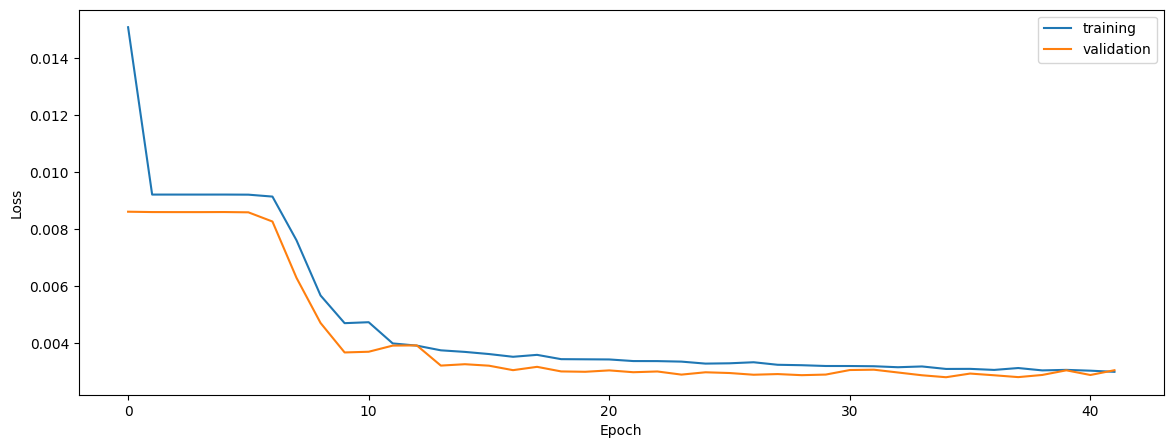

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train.append(predictInBatches(model,train[0],architecture['batch_size']))
val.append(predictInBatches(model,val[0],architecture['batch_size']))
test.append(predictInBatches(model,test[0],architecture['batch_size']))

print('train')
print(getPearson(train[1],train[4]))
print(getPearson(val[1],val[4]))
print(getPearson(test[1],test[4]))

train
0.819836955403848
0.8216201849424071
0.8111894956774839


In [8]:
print(props['space'])
print(getPearson(train[1],train[4],train[3][0]))
print(getPearson(val[1],val[4],val[3][0]))
print(getPearson(test[1],test[4],test[3][0]))

normalized
0.8208357119262278
0.8338650453800858
0.8171293166847269


In [9]:
print('normalized' if props['space'] == 'native' else 'native')
print(getPearson(train[1][train[2]],train[4][train[2]],train[3][1]))
print(getPearson(val[1][val[2]],val[4][val[2]],val[3][1]))
print(getPearson(test[1][test[2]],test[4][test[2]],test[3][1]))

native
0.8190349217782346
0.8312819790093092
0.8132819286524394


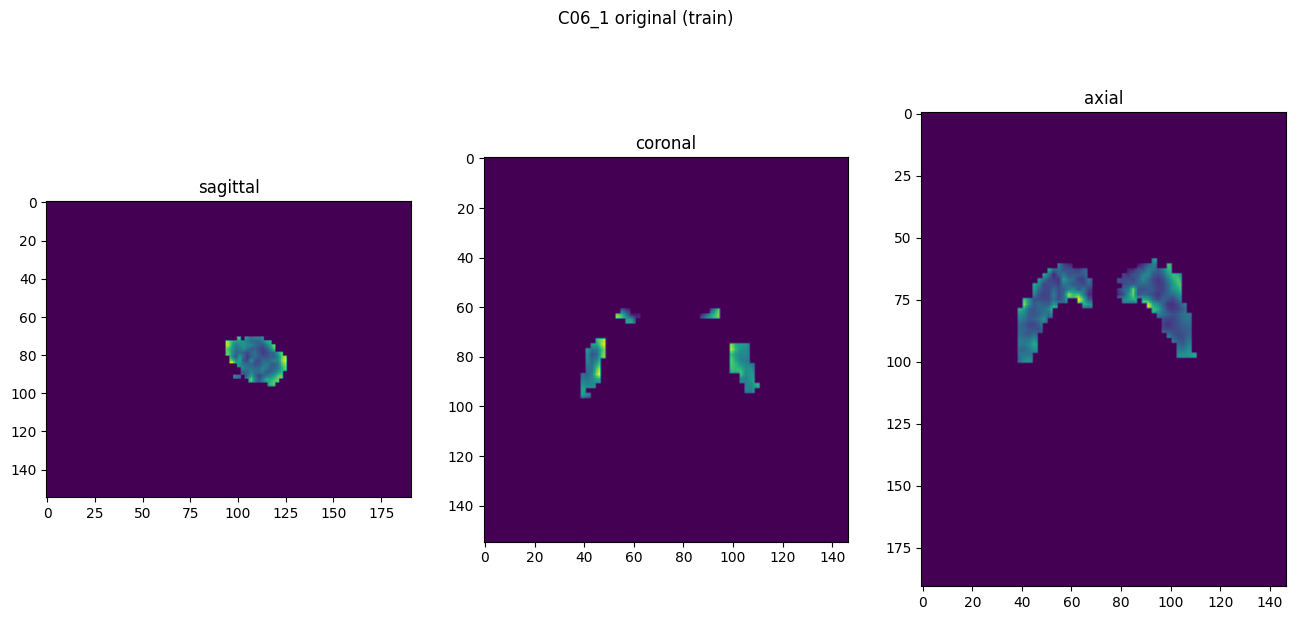

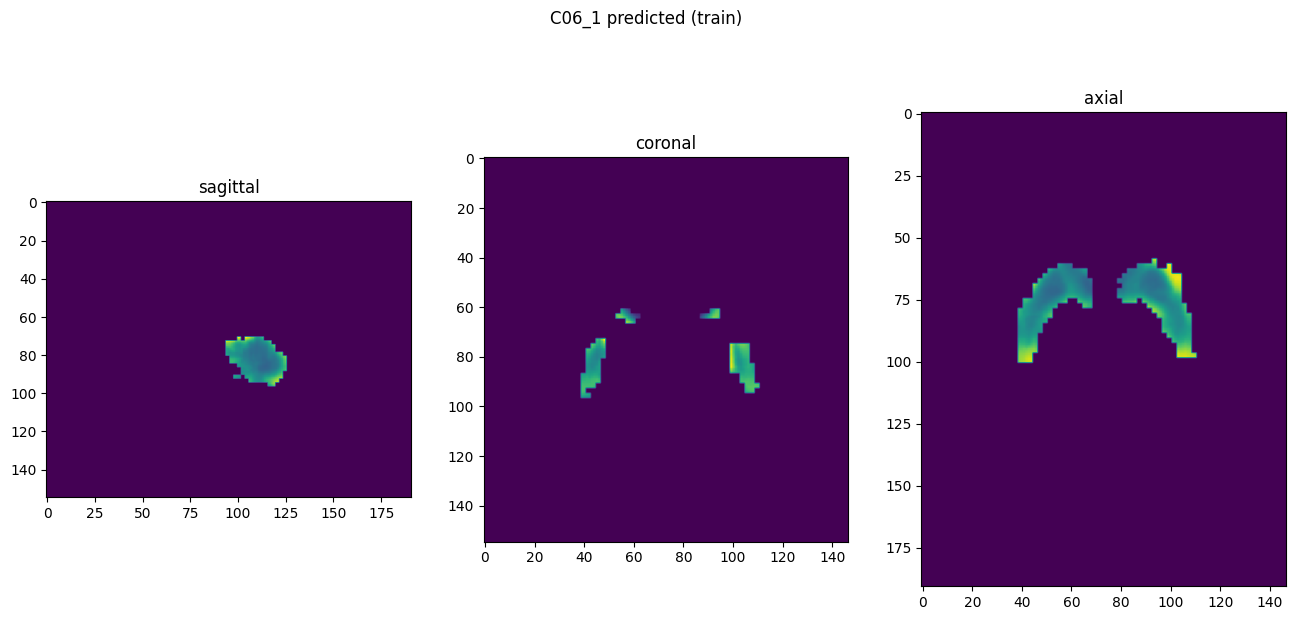

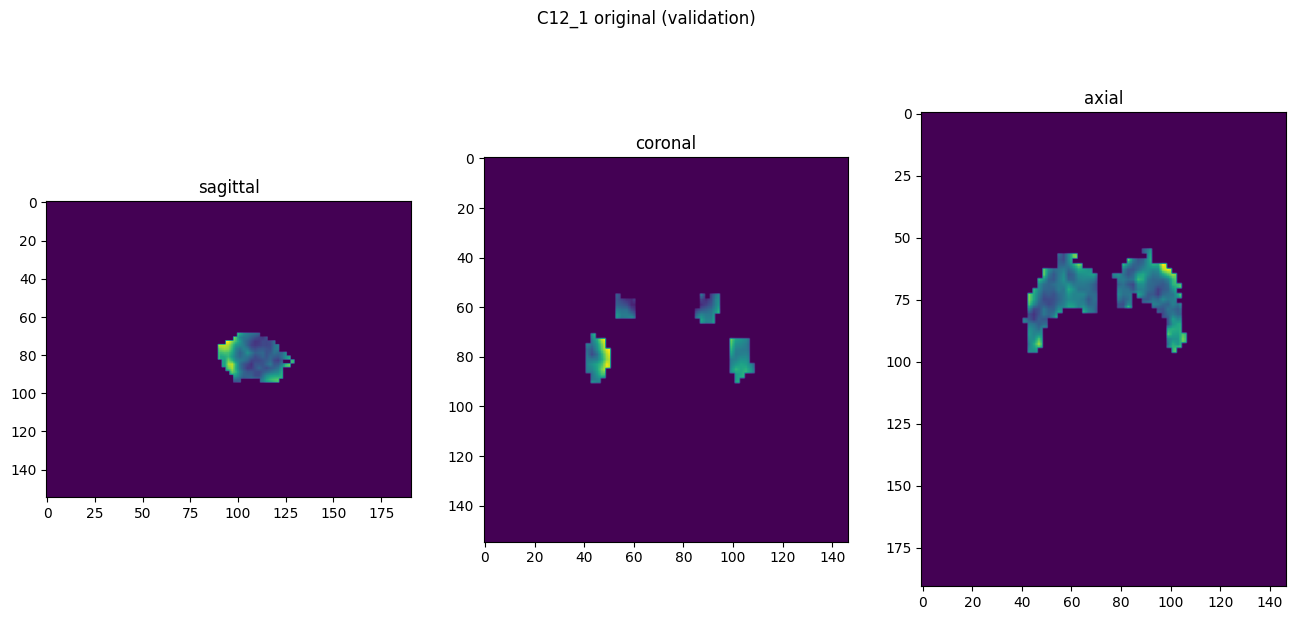

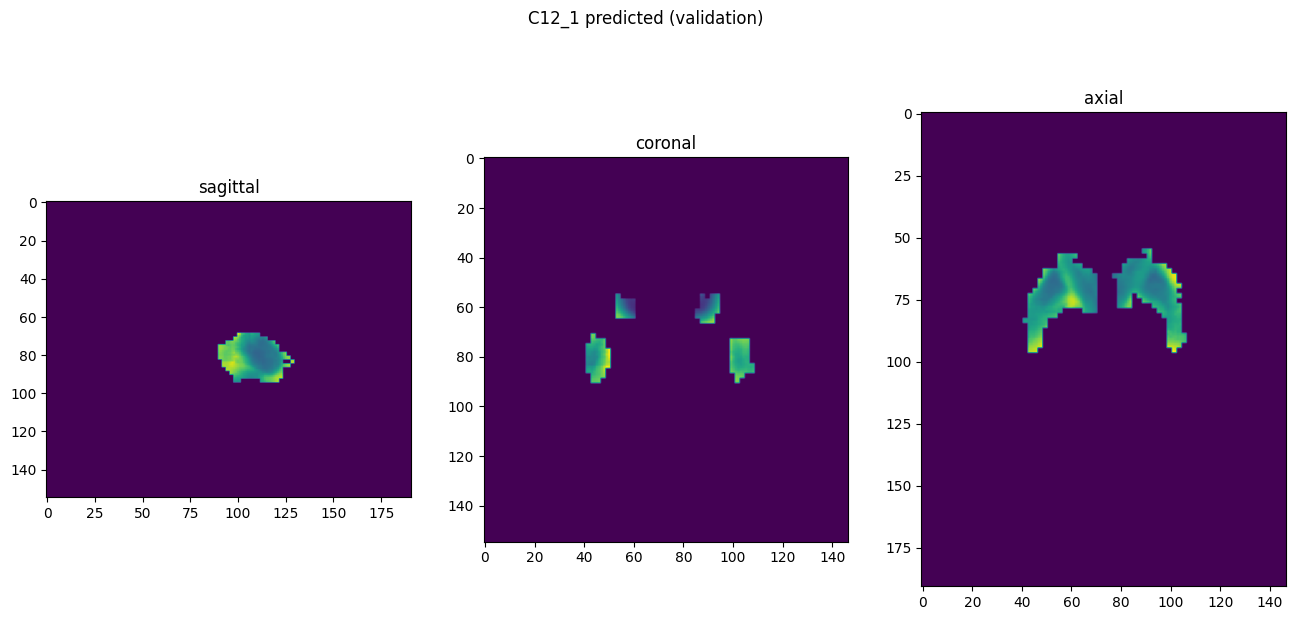

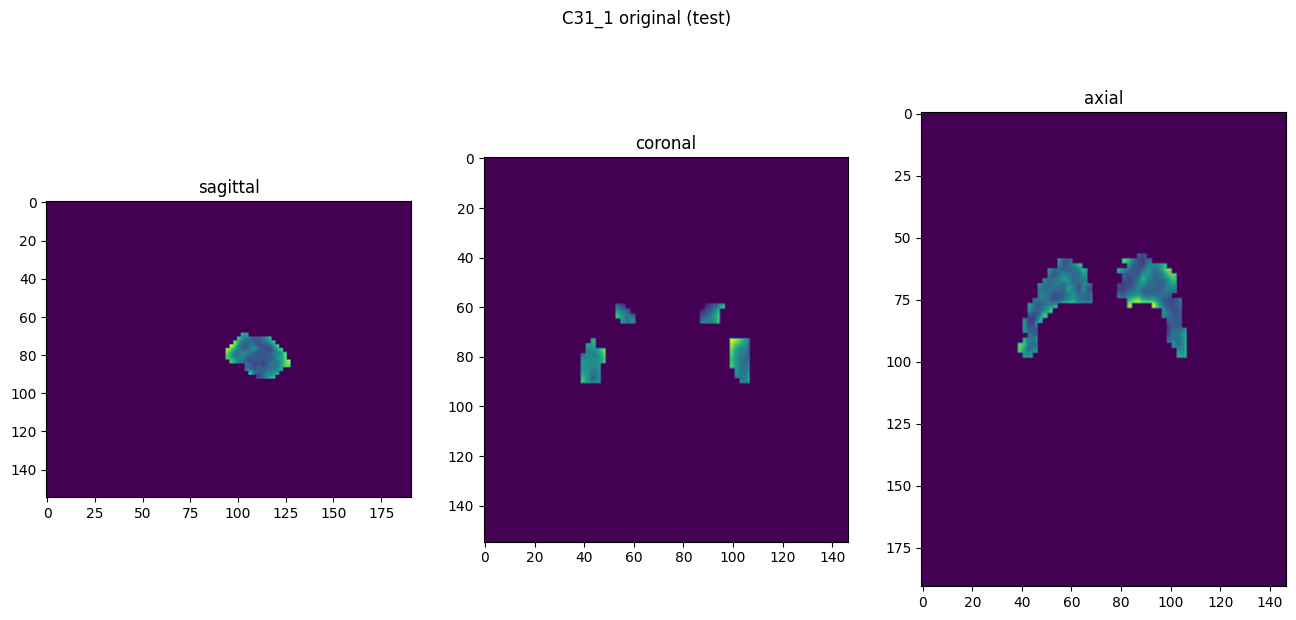

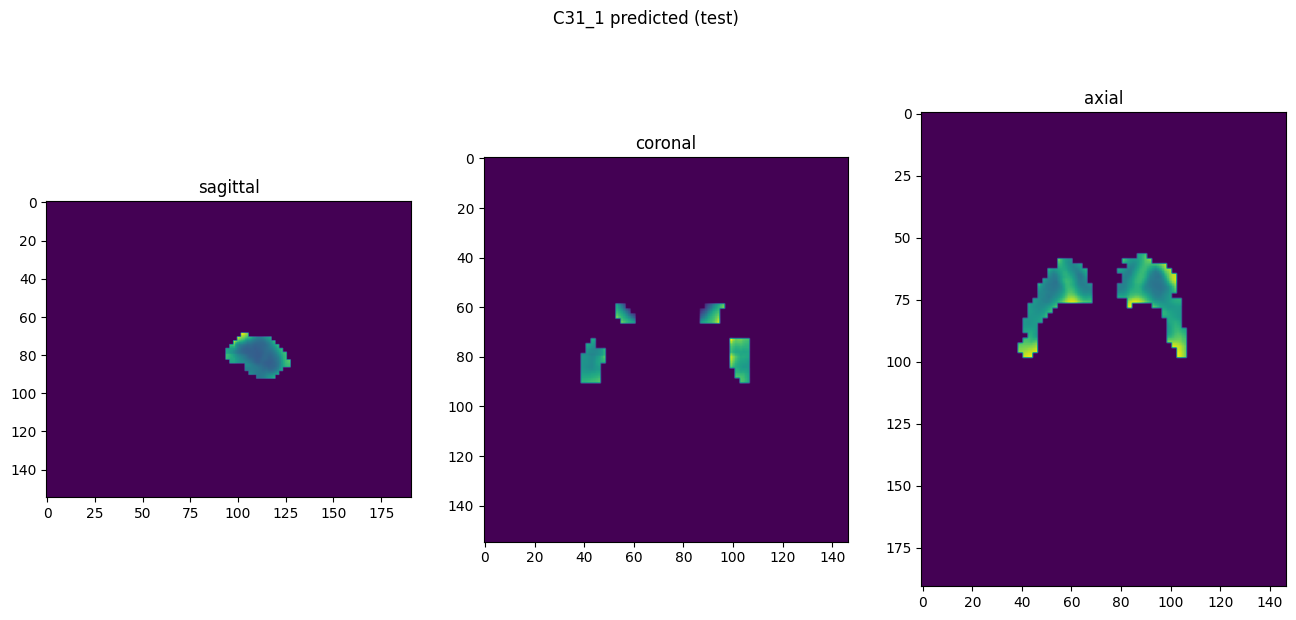

In [10]:
showResults(model, gen, threshold=None, background=False)